In [8]:
!pip install mpl_finance -i https://pypi.tuna.tsinghua.edu.cn/simple some-package

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
You should consider upgrading via the '/Users/bytedance/workplace/env/py3/bin/python -m pip install --upgrade pip' command.


In [19]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [20]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
import requests
import json
import datetime
from hs_udata import stock_quote_daily
from mpl_finance import candlestick_ohlc

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [21]:
def get_klines(stock_code):
    # url = 'http://33.push2his.eastmoney.com/api/qt/stock/kline/get?cb=jQuery11240262763897597486_1655023814001&secid=1.601788&ut=fa5fd1943c7b386f172d6893dbfba10b&fields1=f1%2Cf2%2Cf3%2Cf4%2Cf5%2Cf6&fields2=f51%2Cf52%2Cf53%2Cf54%2Cf55%2Cf56%2Cf57%2Cf58%2Cf59%2Cf60%2Cf61&klt=101&fqt=0&end=20500101&lmt=120&_=1655023814030'
    url1 = 'http://33.push2his.eastmoney.com/api/qt/stock/kline/get?cb=jQuery11240262763897597486_1655023814001&secid=1.'
    url2 = '&ut=fa5fd1943c7b386f172d6893dbfba10b&fields1=f1%2Cf2%2Cf3%2Cf4%2Cf5%2Cf6&fields2=f51%2Cf52%2Cf53%2Cf54%2Cf55%2Cf56%2Cf57%2Cf58%2Cf59%2Cf60%2Cf61&klt=101&fqt=0&end=20500101&lmt=120&_=1655023814030'
    url = url1 + str(stock_code) + url2
    headers = {
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate',
        'Accept-Language': 'zh-CN,zh;q=0.9',
        'Cache-Control': 'no-cache',
        'Connection': 'keep-alive',
        'Cookie': 'qgqp_b_id=562d311e47faaceeb672652074c504e5; st_si=64093144335367; em_hq_fls=old; st_asi=delete; HAList=a-sh-603829-%u6D1B%u51EF%u80A1%u4EFD%2Ca-sh-601788-%u5149%u5927%u8BC1%u5238%2Ca-sz-300059-%u4E1C%u65B9%u8D22%u5BCC; st_pvi=82200143593863; st_sp=2022-06-03%2012%3A52%3A42; st_inirUrl=https%3A%2F%2Fwww.baidu.com%2Flink; st_sn=645; st_psi=20220612165023768-113200301201-7334803799',
        'Host': '33.push2his.eastmoney.com',
        'Pragma': 'no-cache',
        'Referer': 'http://quote.eastmoney.com/',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.64 Safari/537.36'
    }
    resp = requests.get(url ,headers=headers)
    if resp.status_code != 200:
        print('request error: ', stock_code)
        return resp.status_code, '', '', []
    json_data = json.loads(resp.text.split('(')[1].split(')')[0])
    data = json_data['data']
    code = data['code']
    name = data['name']
    klines = data['klines']
    return 200, code, name, klines

In [22]:
def print_klines(stock_code, name, klines, index):
    klins_list = []
    for s in klines:
        tmp = []
        splits = s.split(',')
        tmp.append(splits[0])
        for i in range(1,7):
            tmp.append(float(splits[i]))
        klins_list.append(tmp)
#     print(klins_list[0])
#     len(klins_list)
    klins_list = klins_list[-100:]
    data_pd = pd.DataFrame(klins_list, range(len(klins_list)), ['date', 'open_price', 'close_price', 'high_price', 'low_price',  'hands', 'business_amount'])
    data_pd['Date'] = pd.to_datetime(data_pd['date'], format="%Y-%m-%d").apply(lambda x:mdates.date2num(x))
    data_price = data_pd.set_index('date')
    # 绘制成交量
    fig = plt.figure(figsize=(12,10))
    grid = plt.GridSpec(12, 10, wspace=0.5, hspace=0.5)
    # 绘制k线
    ohlc = data_price[['Date', 'open_price', 'high_price', 'low_price', 'close_price']]
    ohlc.loc[:,'Date'] = range(len(ohlc))
    ax1 = fig.add_subplot(grid[0:8,0:12])
    candlestick_ohlc(ax1, ohlc.values.tolist(), width=0.7, colorup='red', colordown='green')
    # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.xticks(rotation=30)
    plt.title(str(index)+' '+stock_code+' '+name, fontsize = 14)
    plt.xlabel('日 期', fontsize = 14)
    plt.ylabel('价格（元）', fontsize = 14)
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    # 绘制成交量
    data_volume = data_price[['Date', 'close_price', 'open_price', 'business_amount']]
    data_volume['color'] = data_volume.apply(lambda row: 1 if row['close_price'] >= row['open_price'] else 0, axis=1)
    data_volume.Date = ohlc.Date

    ax2 = fig.add_subplot(grid[8:10,0:12])
    ax2.bar(data_volume.query('color==1')['Date'], data_volume.query('color==1')['business_amount'], color='r')
    ax2.bar(data_volume.query('color==0')['Date'], data_volume.query('color==0')['business_amount'], color='g')
    plt.xticks(rotation=30)
    plt.xlabel('日 期', fontsize=14)

    # 去除非交易日的间隔
    date_list = ohlc.index.tolist()
    xticks_len = round(len(date_list)/(len(ax2.get_xticks())-1))
    xticks_num = range(0, len(date_list),xticks_len)
    xticks_str = list(map(lambda x:date_list[int(x)], xticks_num))
    ax2.set_xticks(xticks_num)
    ax2.set_xticklabels(xticks_str)
    plt.show()

In [23]:
print(get_klines(688348))

(200, '688348', '昱能科技', ['2022-06-08,301.00,290.10,311.00,266.00,135801,3828438608.00,27.61,77.98,127.10,74.46', '2022-06-09,292.00,296.10,311.00,290.30,58852,1768401088.00,7.14,2.07,6.00,32.27', '2022-06-10,299.80,339.98,341.69,299.76,43211,1392461168.00,14.16,14.82,43.88,23.69', '2022-06-13,336.50,356.00,363.90,329.00,35770,1241268944.00,10.27,4.71,16.02,19.61', '2022-06-14,350.97,377.00,385.98,339.50,39462,1411240368.00,13.06,5.90,21.00,21.64', '2022-06-15,372.00,365.98,376.98,354.05,30195,1102061136.00,6.08,-2.92,-11.02,16.56', '2022-06-16,365.98,383.80,385.49,363.19,18730,700052000.00,6.09,4.87,17.82,10.27', '2022-06-17,380.00,383.21,398.80,374.44,17804,690031952.00,6.35,-0.15,-0.59,9.76', '2022-06-20,383.23,386.00,407.87,377.03,20342,797325168.00,8.05,0.73,2.79,11.15', '2022-06-21,385.11,396.30,402.00,372.00,14940,581561840.00,7.77,2.67,10.30,8.19', '2022-06-22,396.00,435.20,463.60,396.00,22168,969242000.00,17.06,9.82,38.90,12.15', '2022-06-23,436.01,460.00,461.66,433.33,18060,81

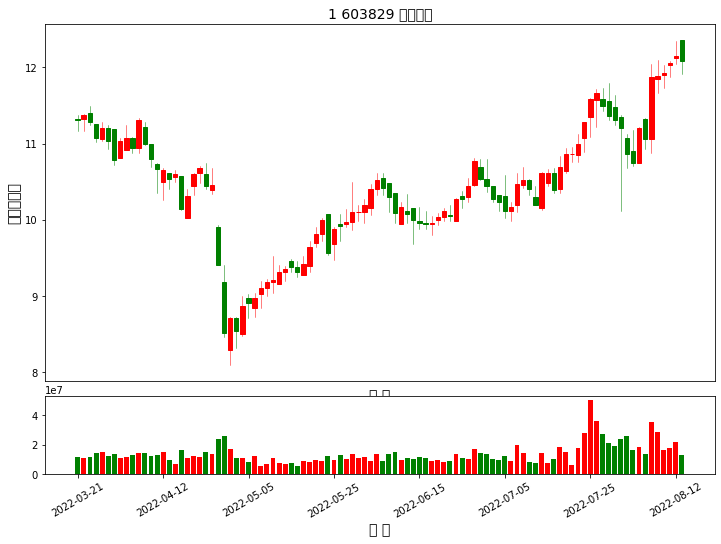

In [24]:
status_code, code, name, klines = get_klines(603829)
# print(klines)
if status_code == 200:
    print_klines(code, name, klines, 1)


In [15]:
def request_all_code(index):
    # requests all code
    url1 = 'http://49.push2.eastmoney.com/api/qt/clist/get?cb=jQuery11240743188493001389_1655043876846&pn='
    url2 = '&pz=20&po=1&np=1&ut=bd1d9ddb04089700cf9c27f6f7426281&fltt=2&invt=2&wbp2u=|0|0|0|web&fid=f3&fs=m:1+t:2,m:1+t:23&fields=f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f12,f13,f14,f15,f16,f17,f18,f20,f21,f23,f24,f25,f22,f11,f62,f128,f136,f115,f152&_=1655043876847'
    url = url1 + str(index) + url2
    headers = {
        'Accept': '*/*',
        'Accept-Encoding': 'gzip, deflate',
        'Accept-Language': 'zh-CN,zh;q=0.9',
        'Cache-Control': 'no-cache',
        'Connection': 'keep-alive',
        'Cookie': 'qgqp_b_id=562d311e47faaceeb672652074c504e5; st_si=64093144335367; em_hq_fls=old; st_asi=delete; st_pvi=82200143593863; st_sp=2022-06-03%2012%3A52%3A42; st_inirUrl=https%3A%2F%2Fwww.baidu.com%2Flink; st_sn=762; st_psi=20220612222354561-113200301201-3254873925; HAList=a-sh-601788-%u5149%u5927%u8BC1%u5238%2Ca-sz-300059-%u4E1C%u65B9%u8D22%u5BCC',
        'Host': '49.push2.eastmoney.com',
        'Pragma': 'no-cache',
        'Referer': 'http://quote.eastmoney.com/',
        'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.64 Safari/537.36'
    }

    resp = requests.get(url ,headers=headers)
    if resp.status_code != 200:
        print('request error: ', index)
        return resp.status_code, '', []
    json_data = json.loads(resp.text.split('(')[1].split(')')[0])
    data = json_data['data']
    total = data['total']
    diff = data['diff']
    return 200, total, diff

In [16]:
# 科创板和非科创板各有多少股票
kechuang_num = 0
no_kechuang_num = 0
for i in range(1,110):
    start_idx = (i-1)*20
    status_code1, total, diff = request_all_code(i)
    if status_code1 != 200:
        print('request error', i)
    else:
        for infos in diff:
            start_idx += 1
            stock_code = infos['f12']
            name = infos['f14']
            status_code2, code, name, klines = get_klines(stock_code)
            if status_code2 == 200:
                if code.startswith('688'):
                    kechuang_num += 1
                else:
                    no_kechuang_num += 1


In [17]:
print(kechuang_num, no_kechuang_num)

433 1747


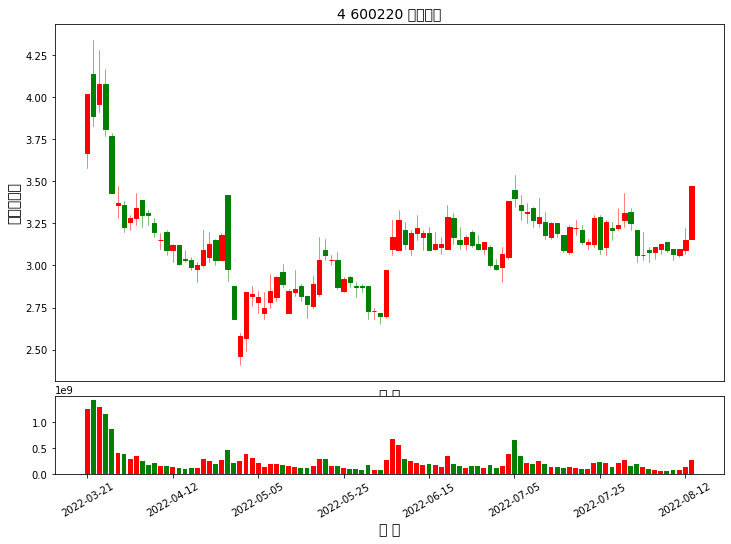

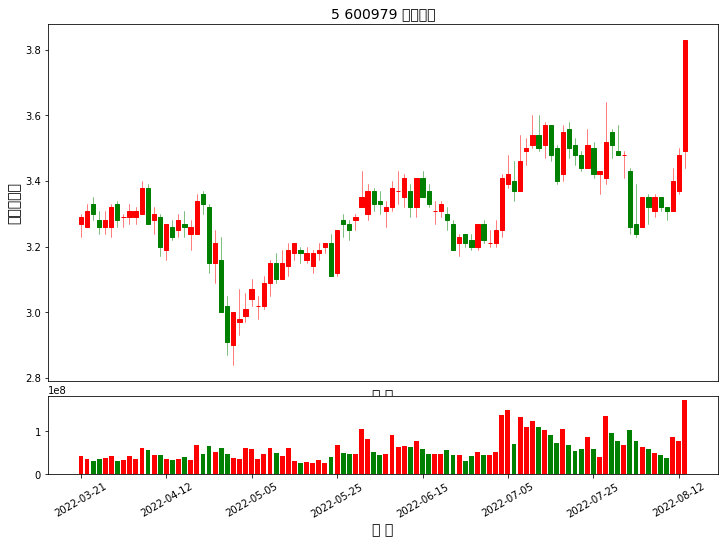

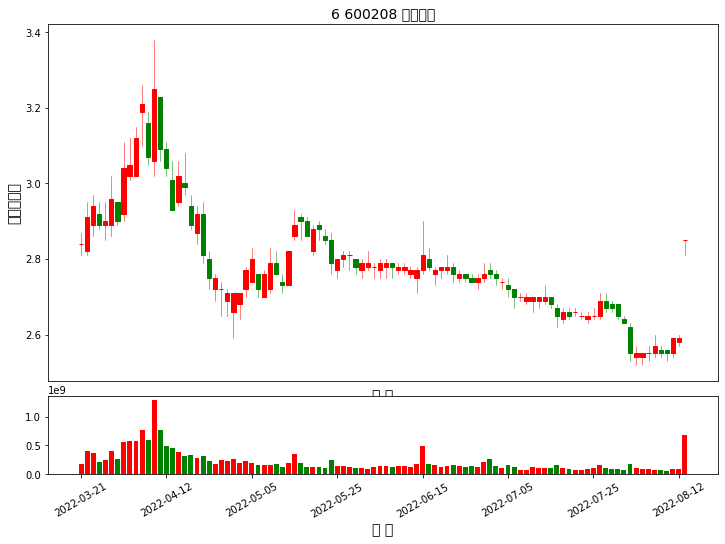

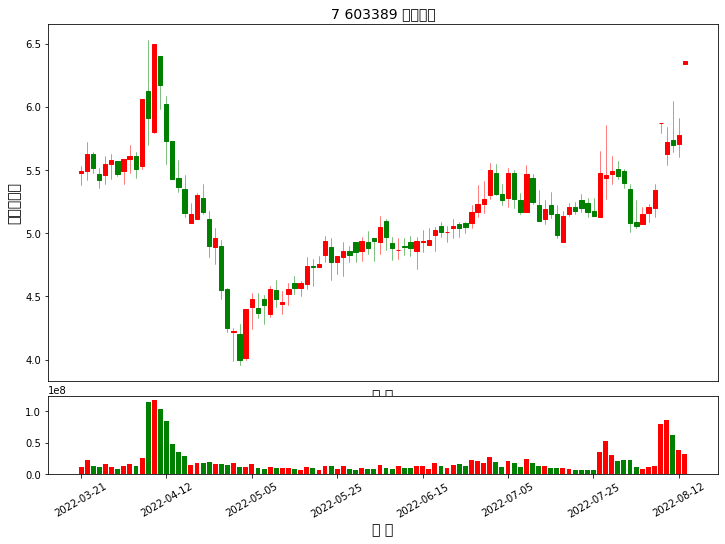

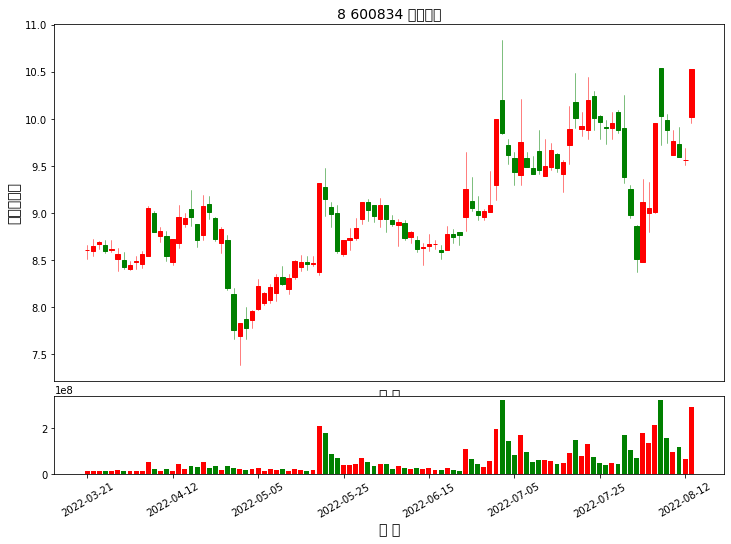

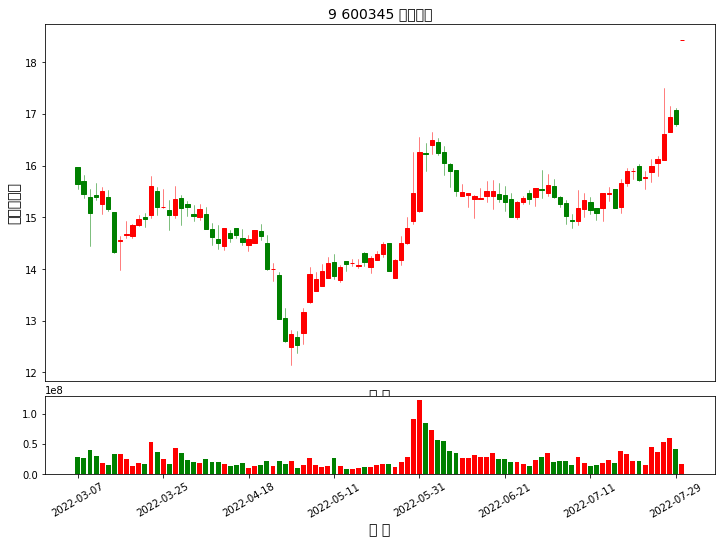

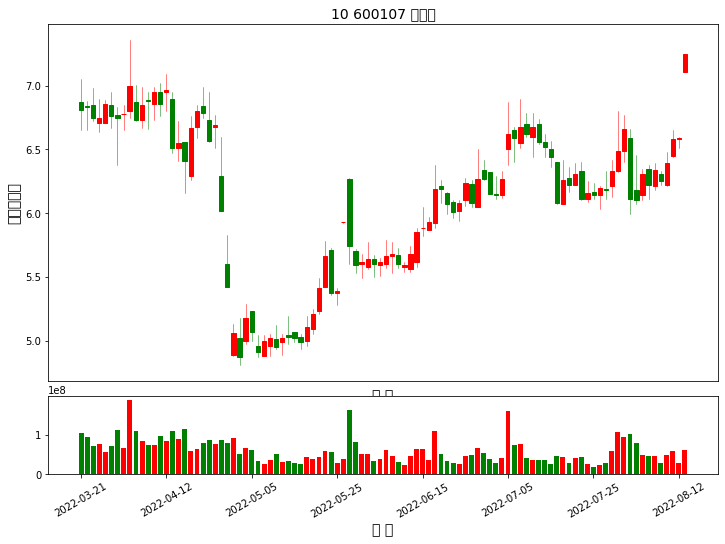

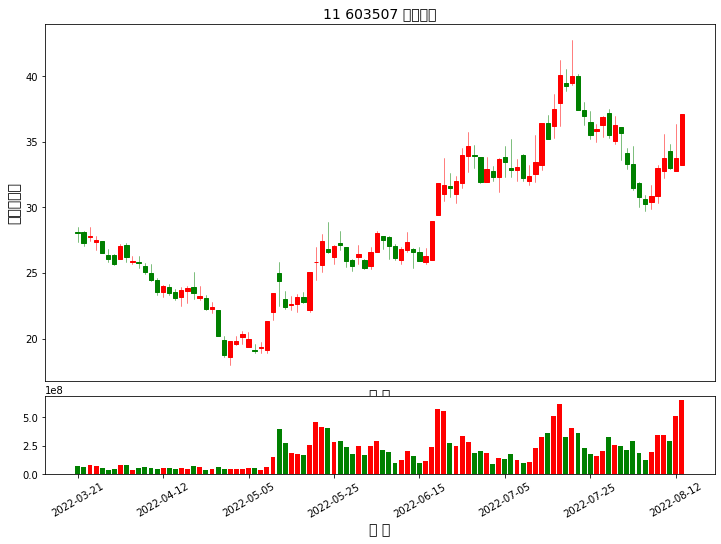

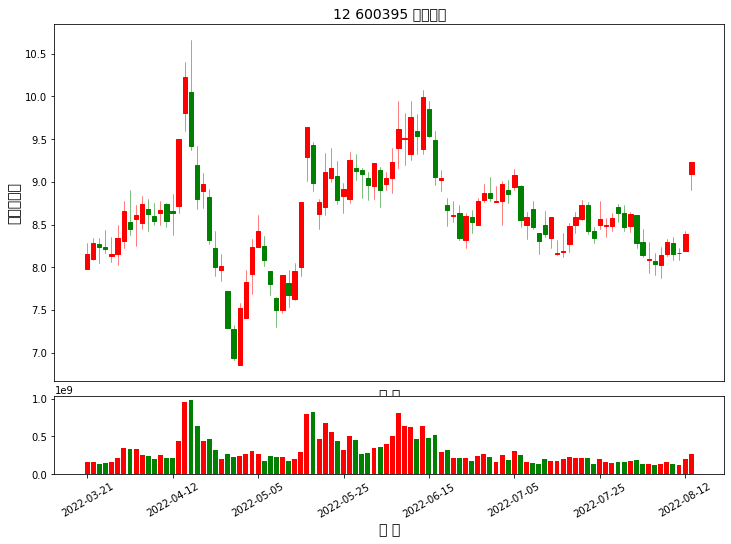

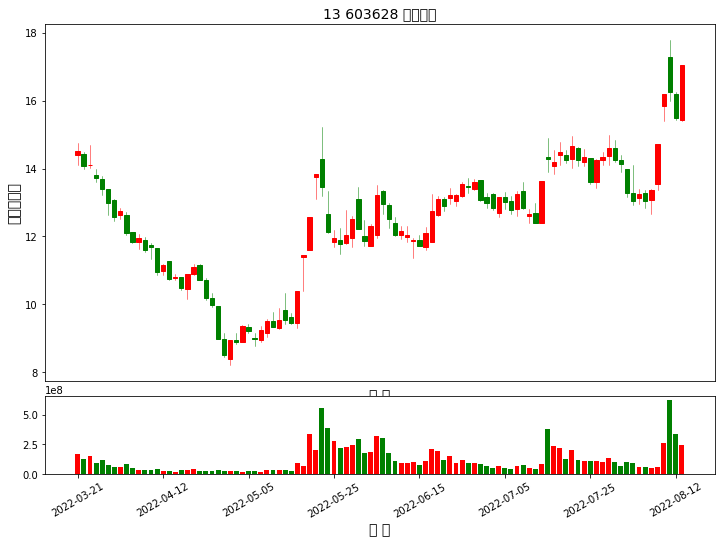

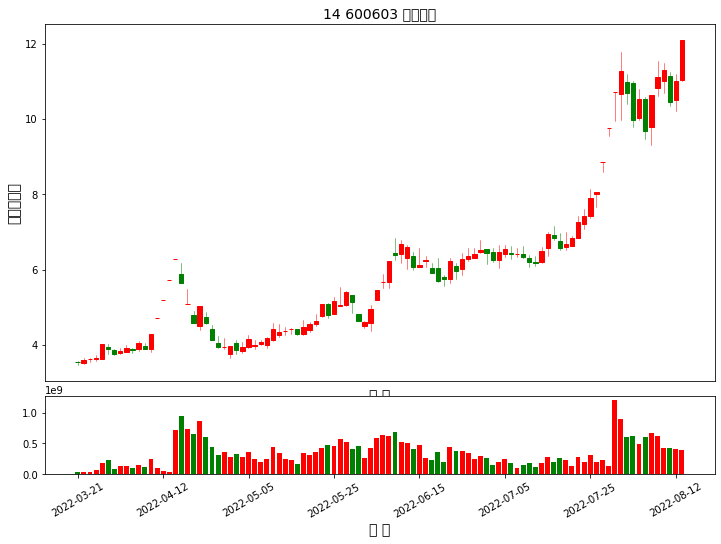

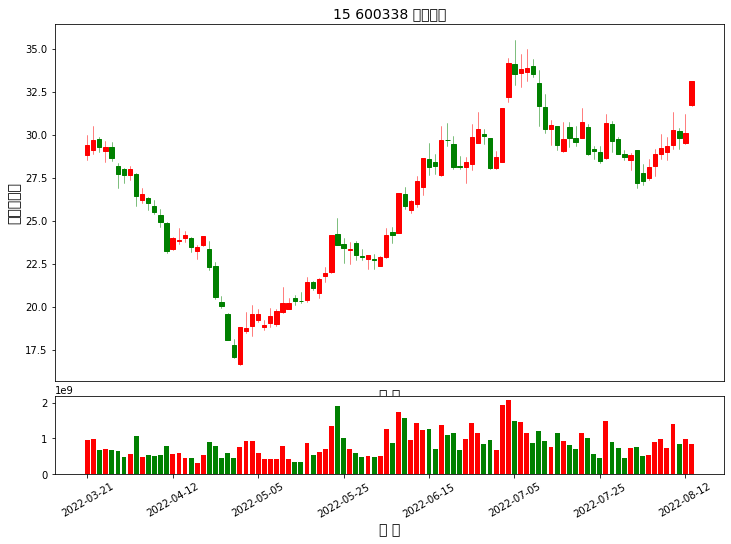

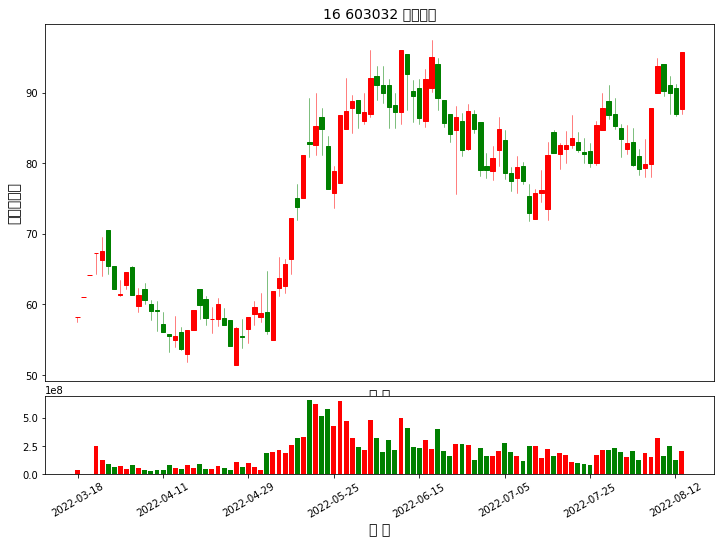

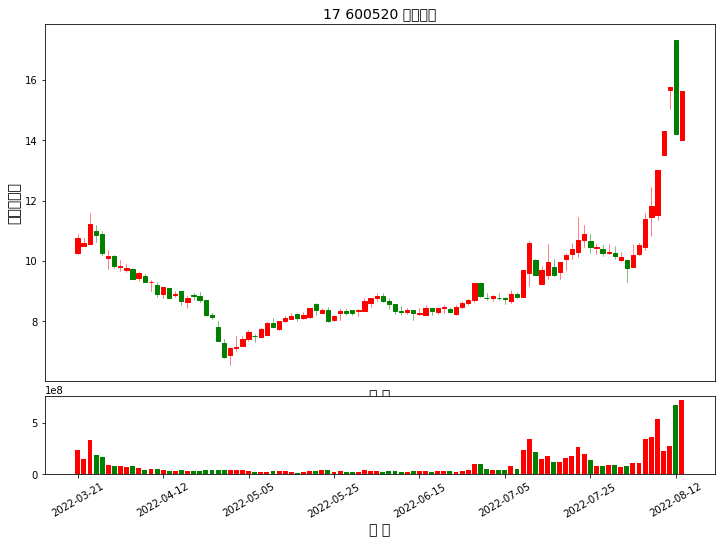

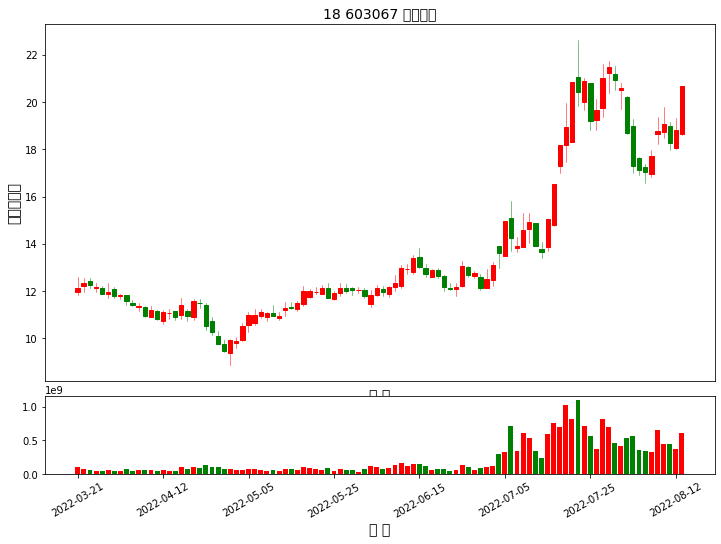

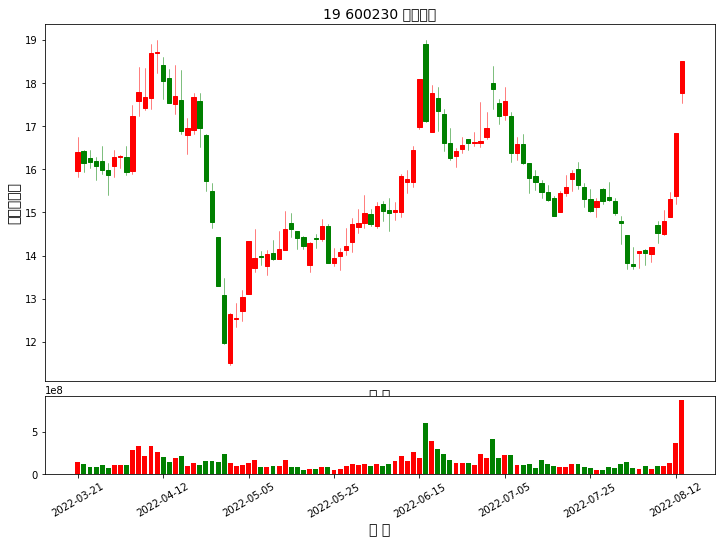

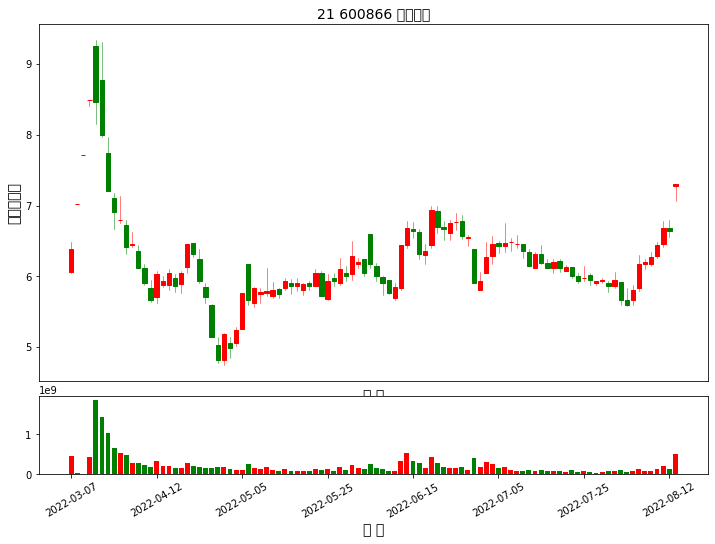

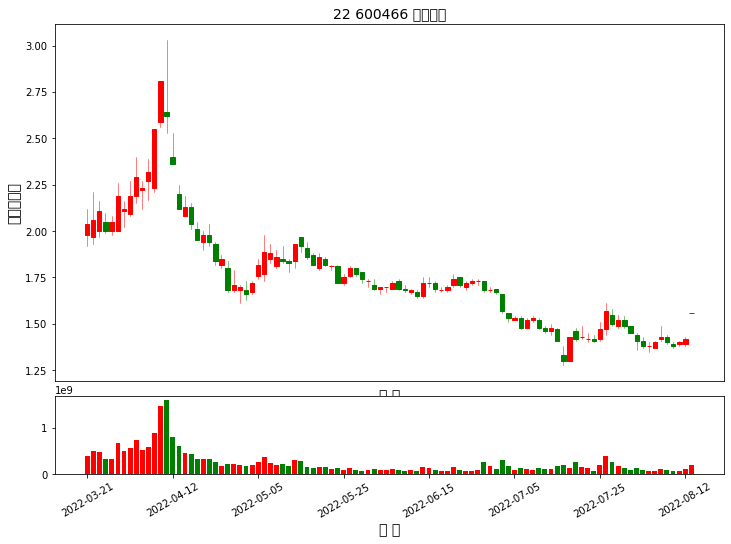

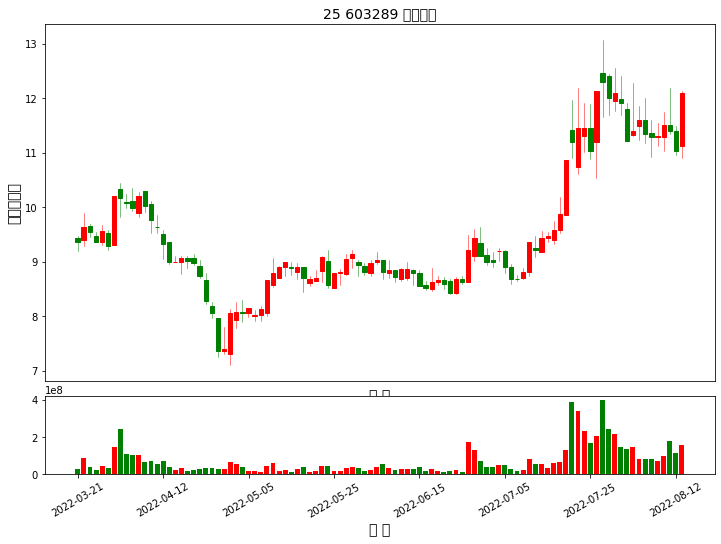

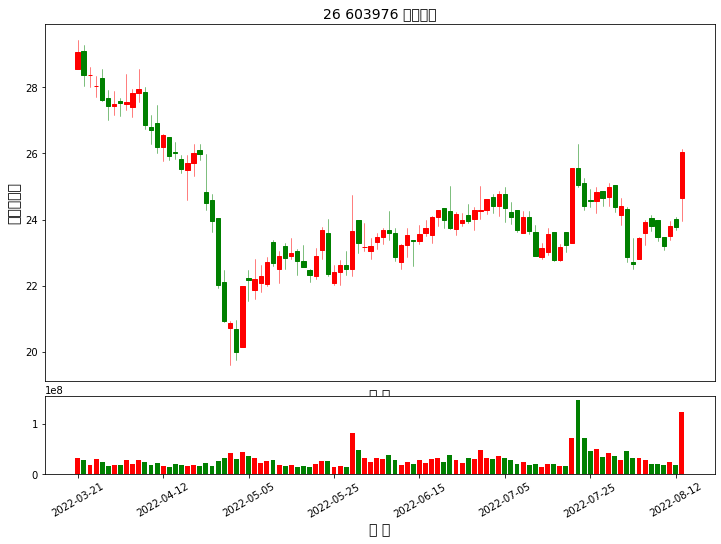

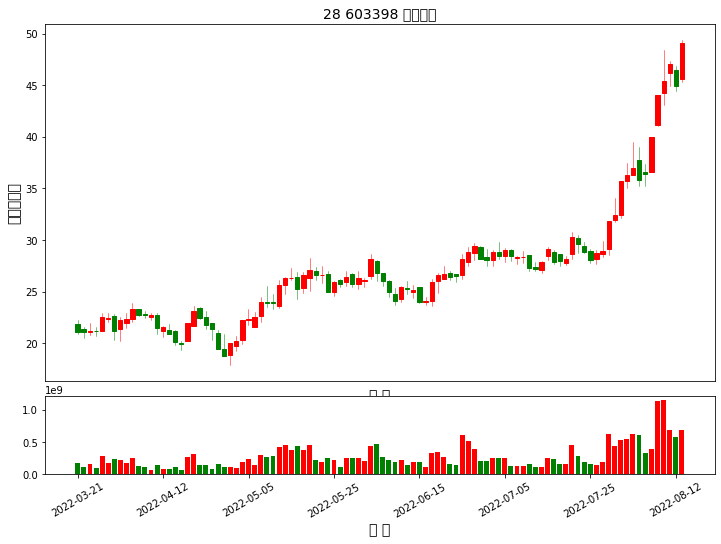

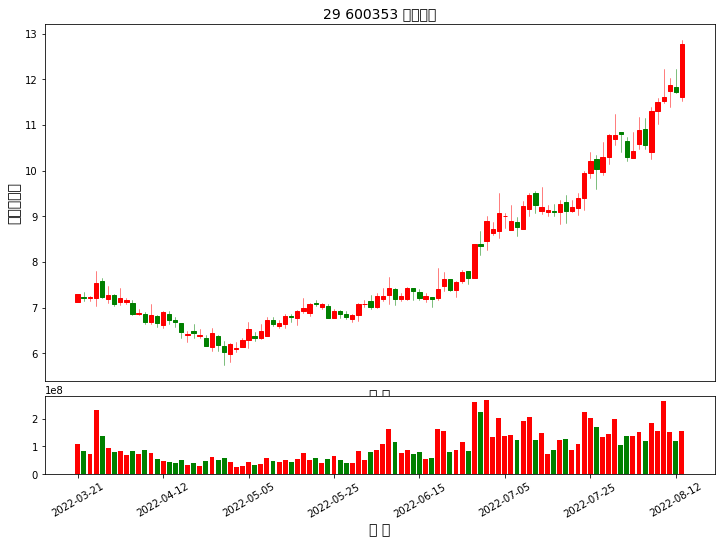

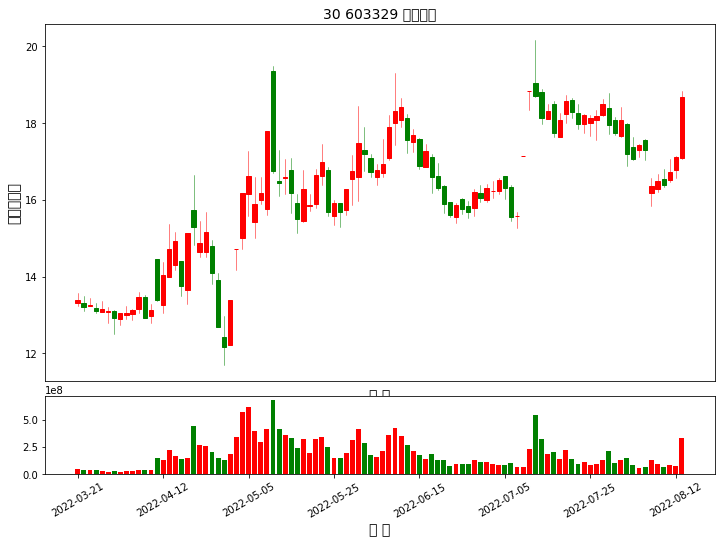

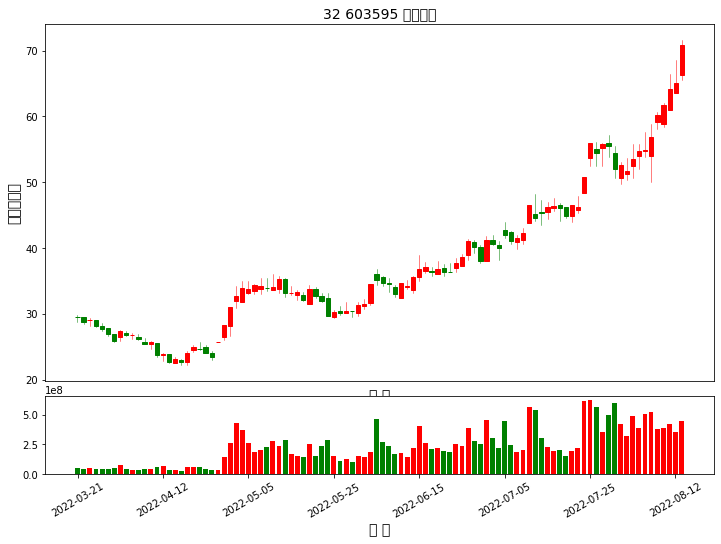

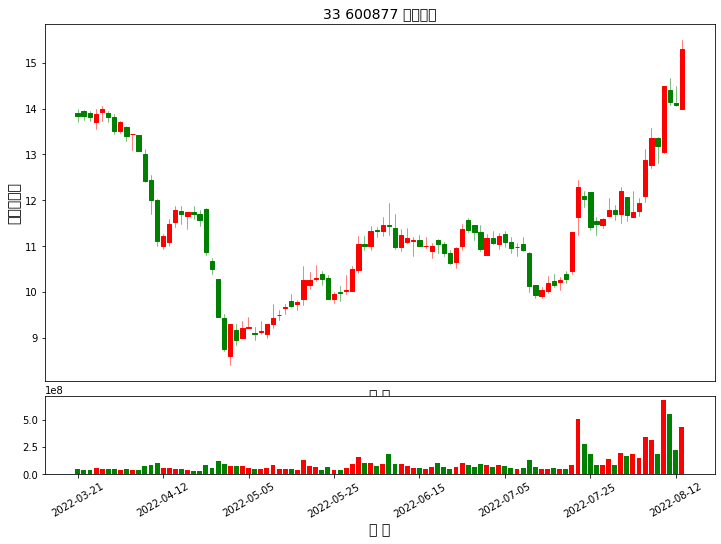

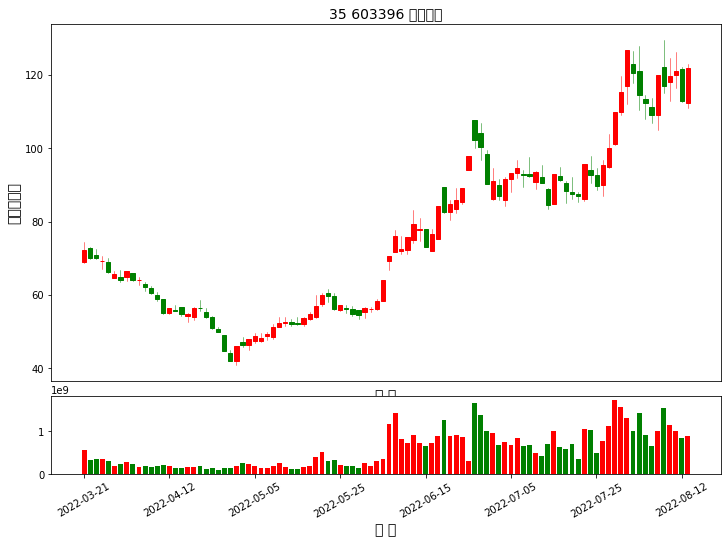

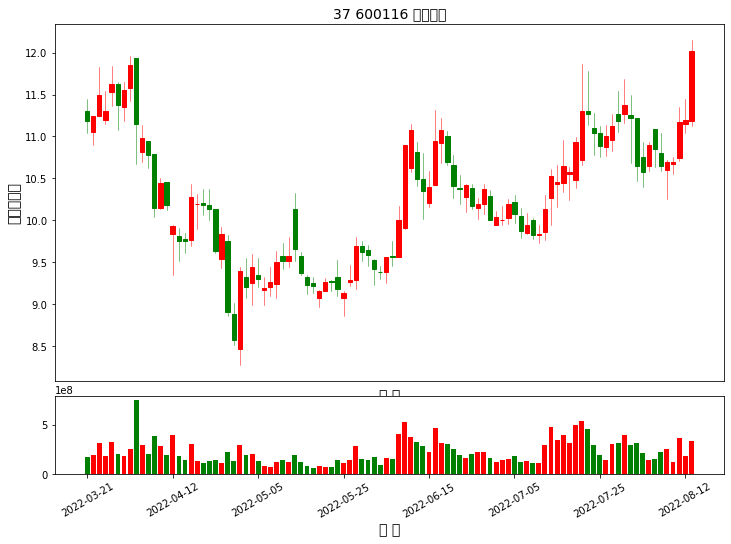

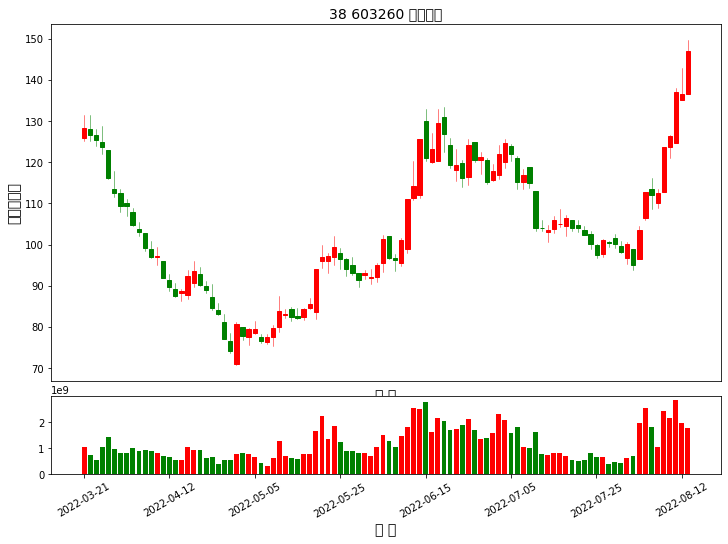

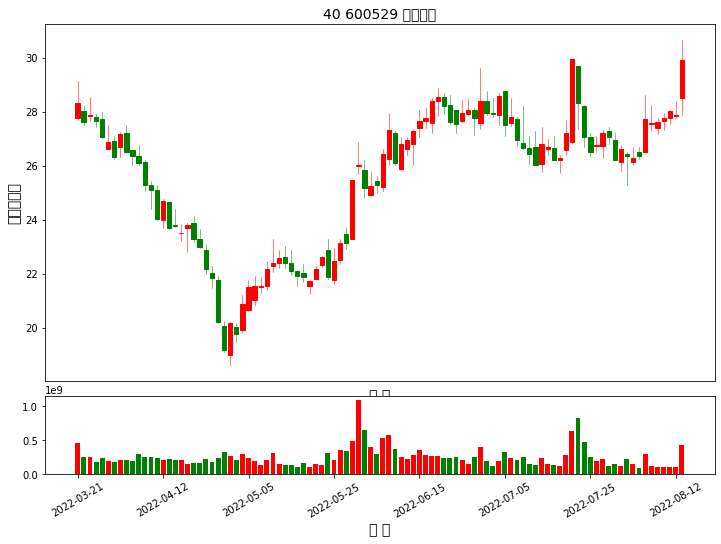

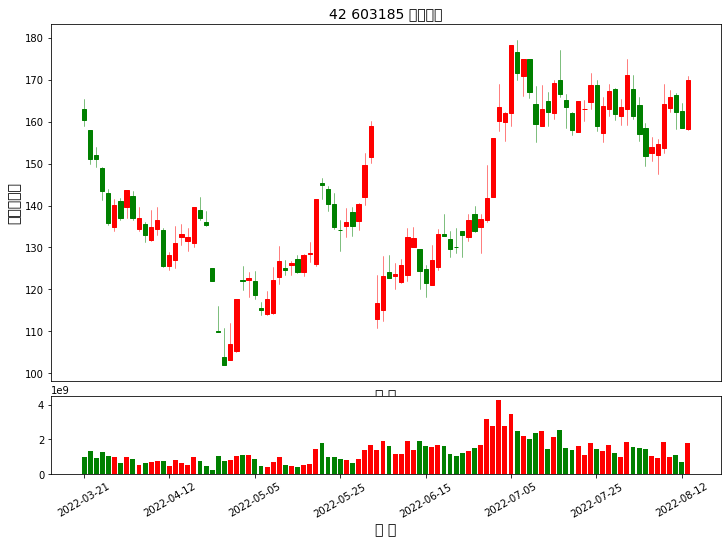

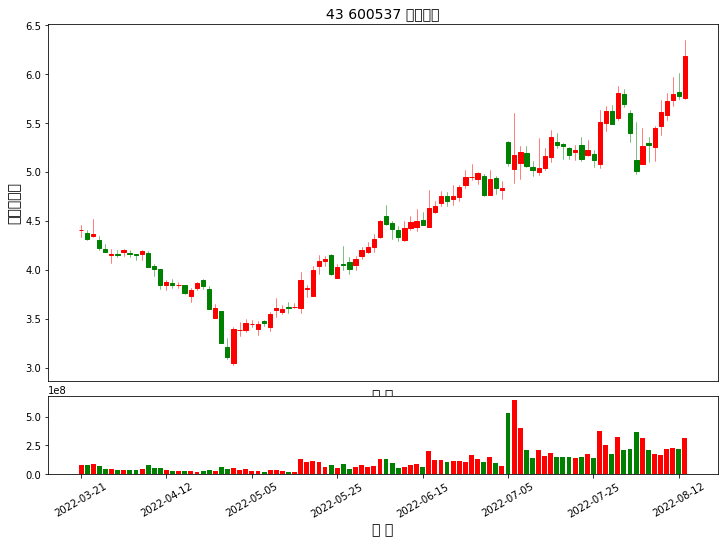

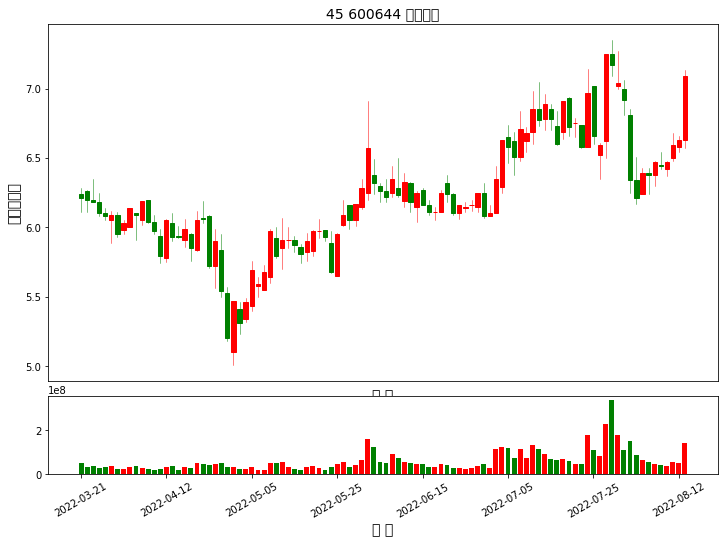

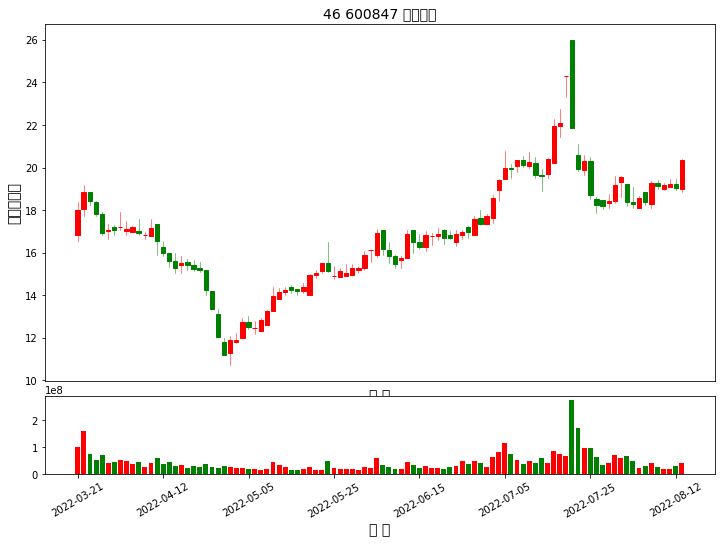

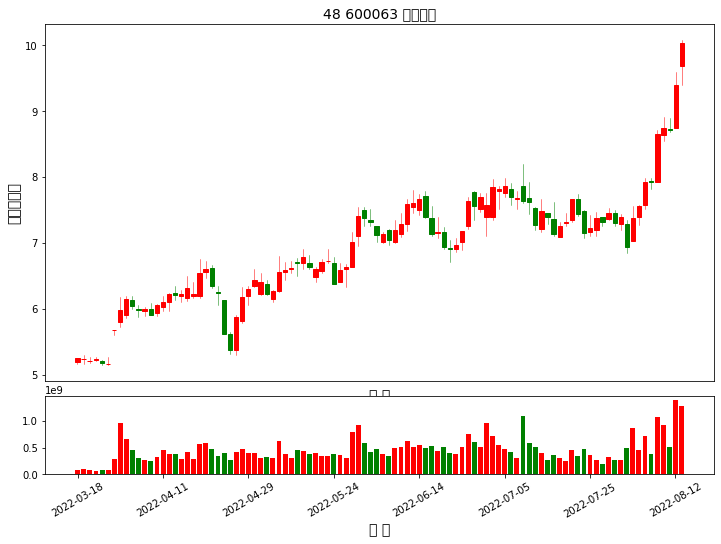

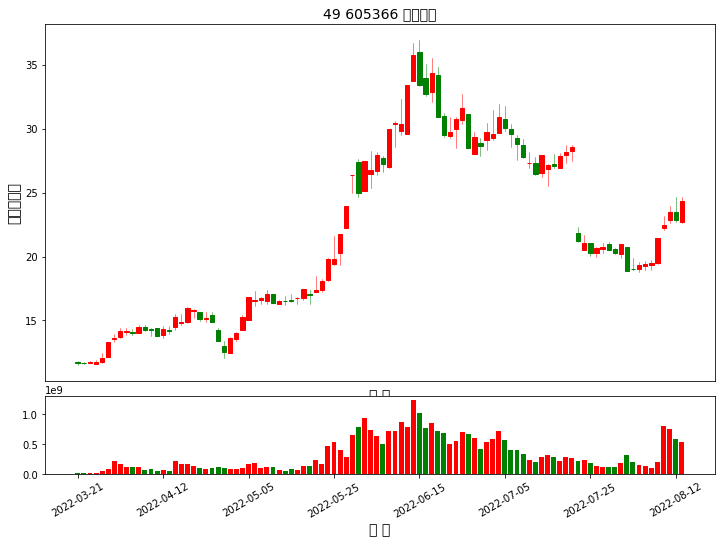

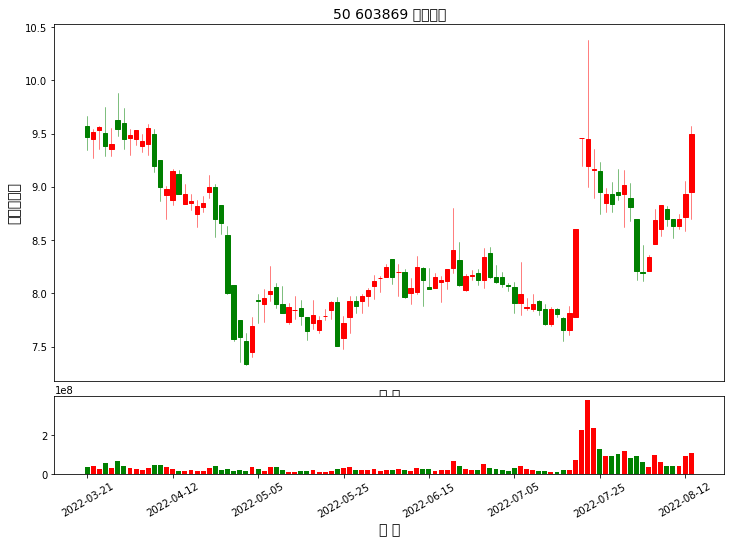

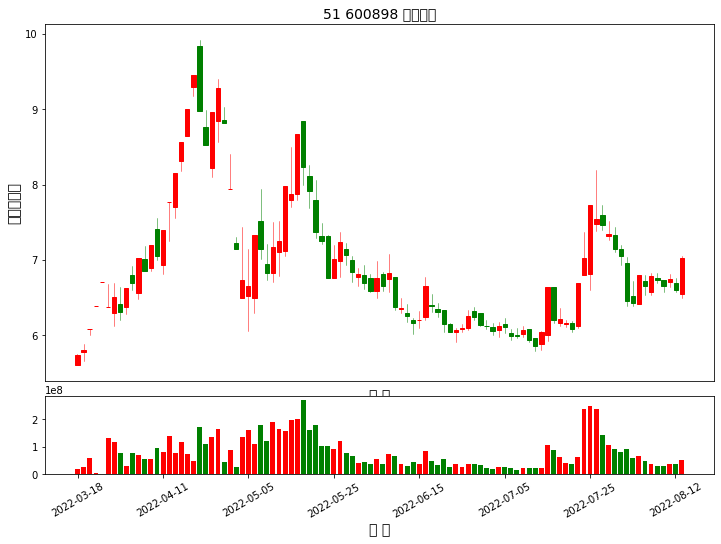

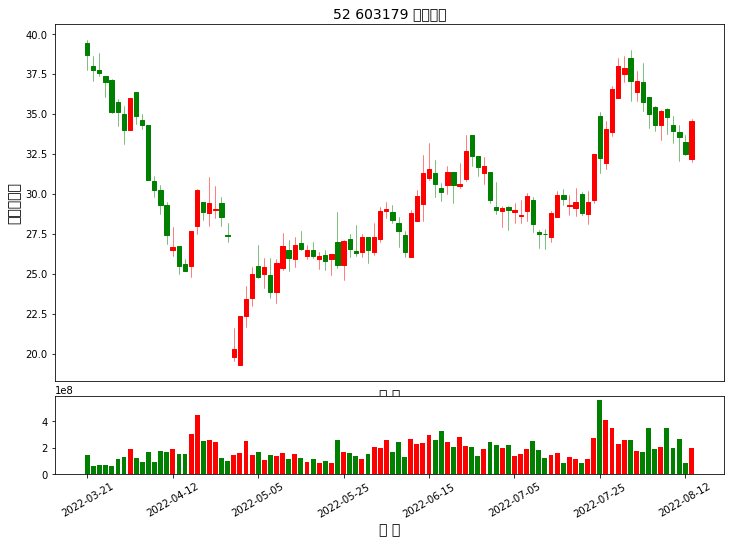

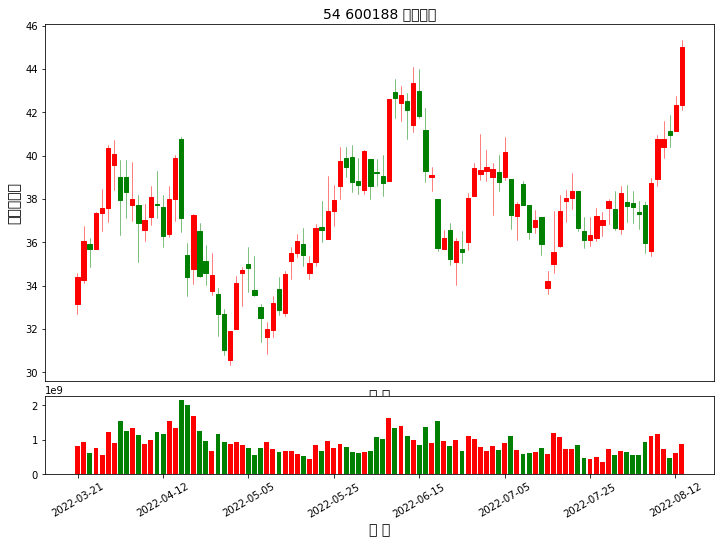

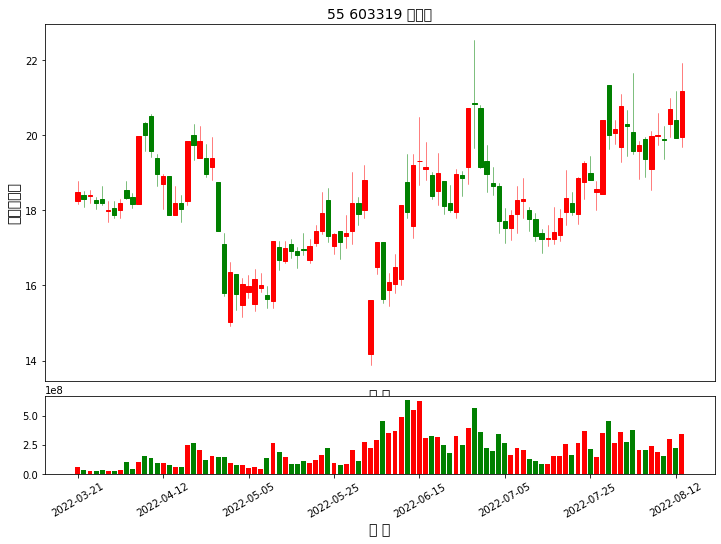

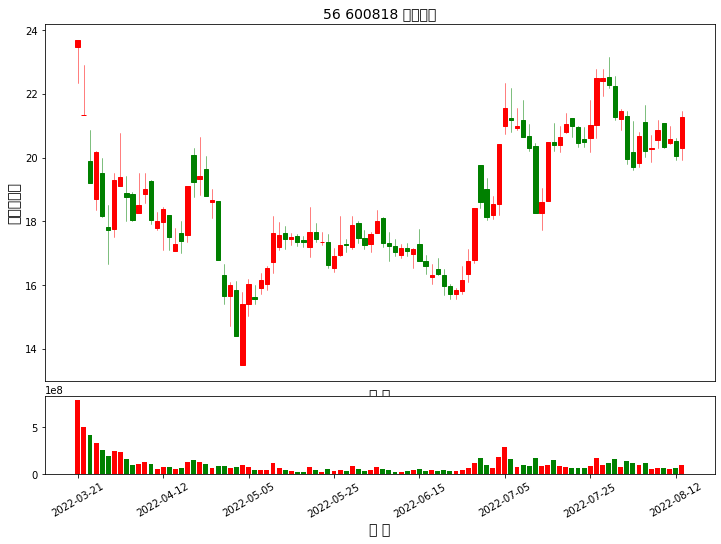

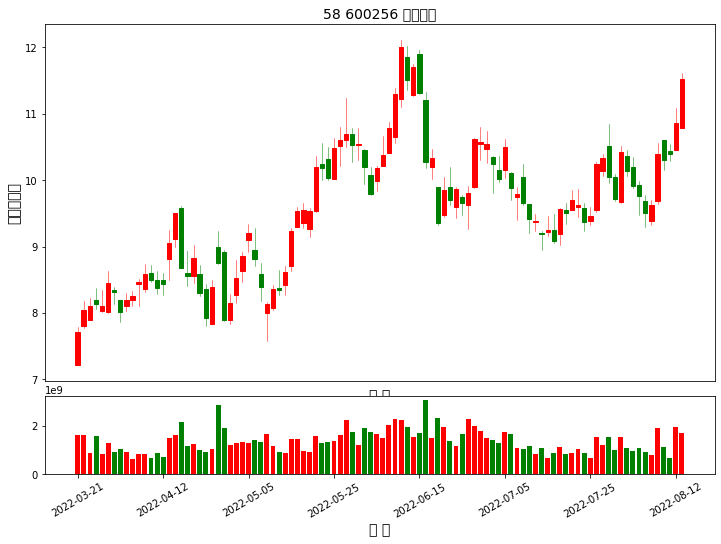

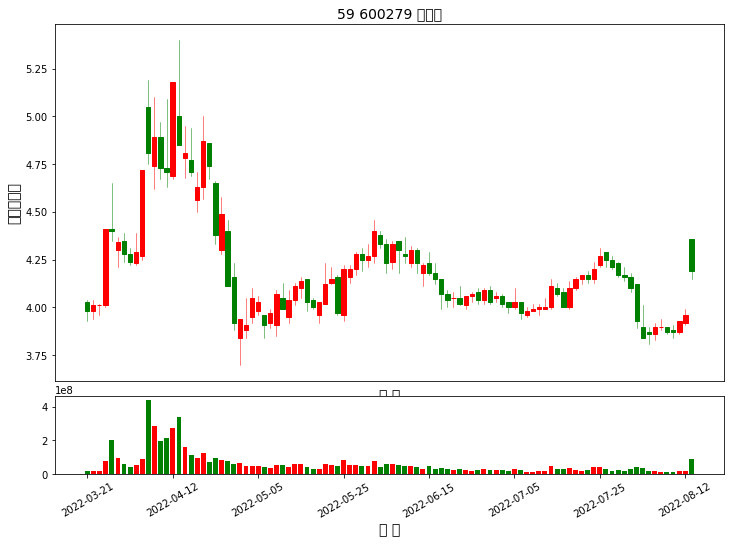

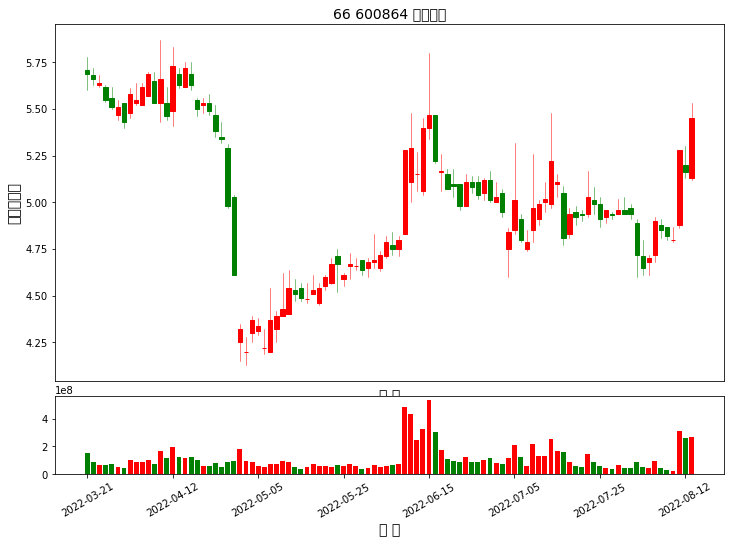

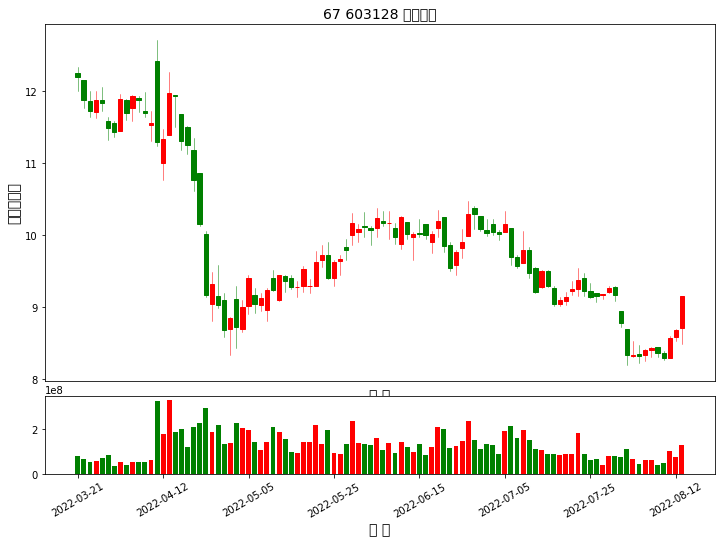

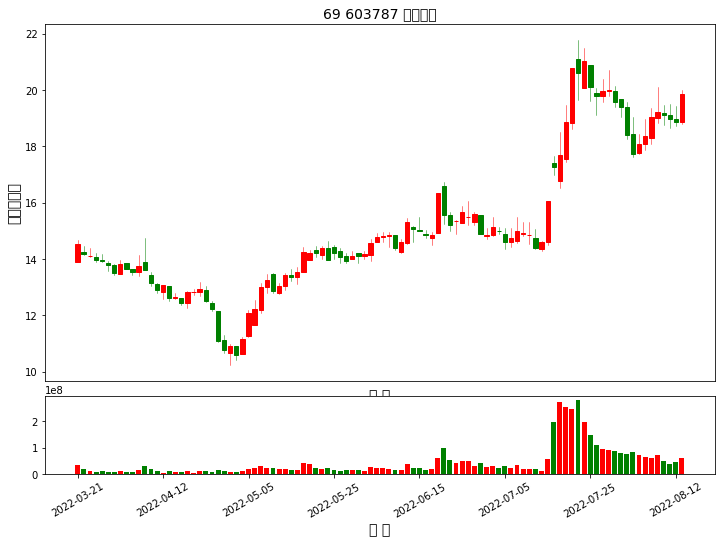

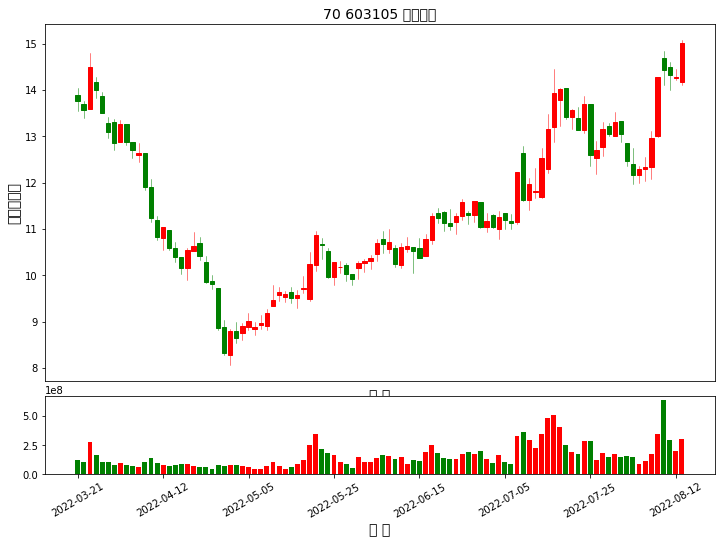

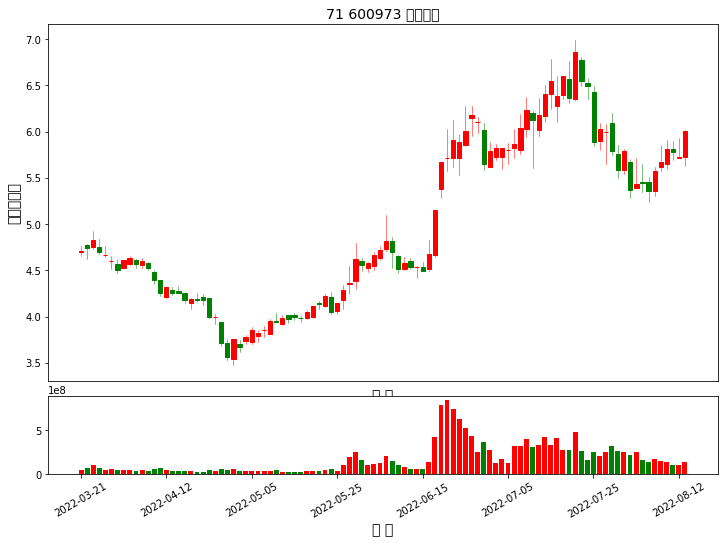

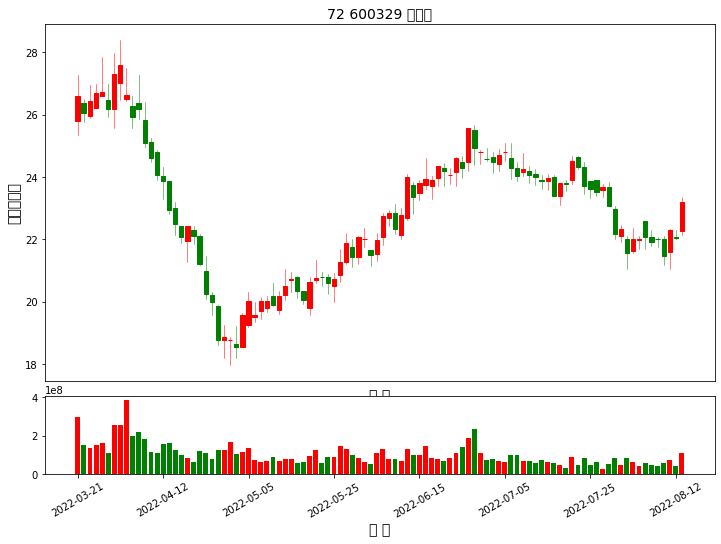

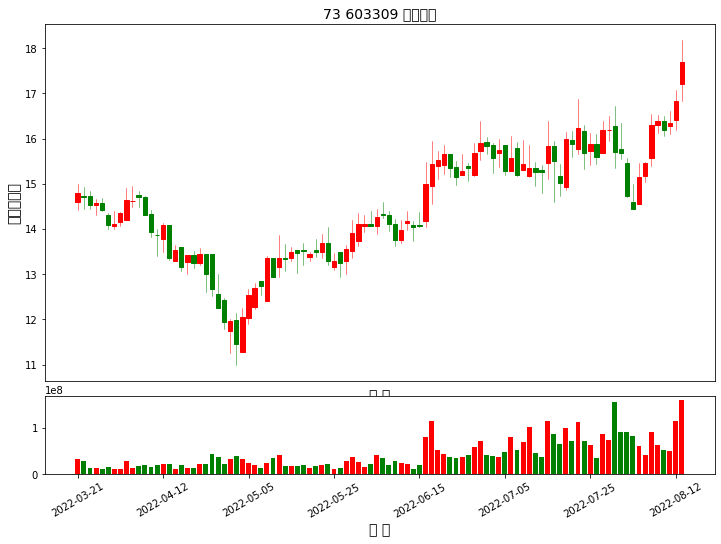

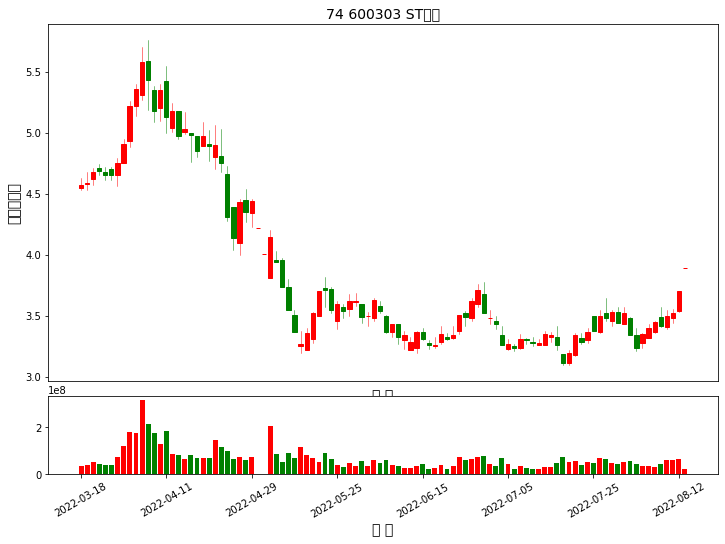

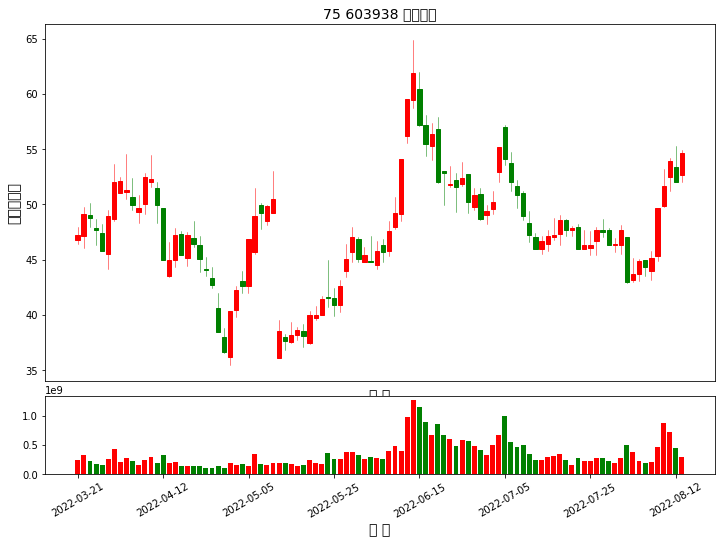

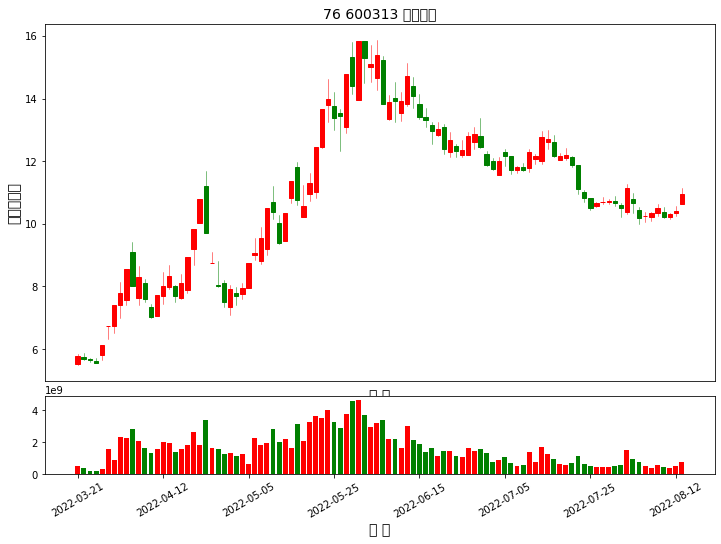

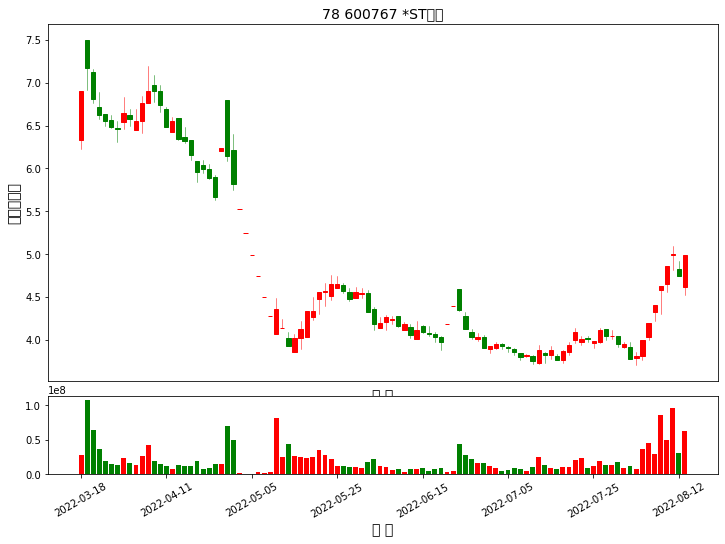

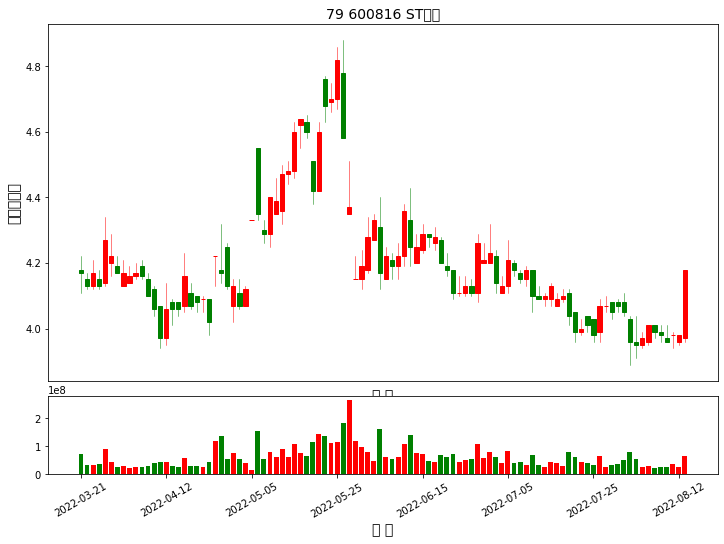

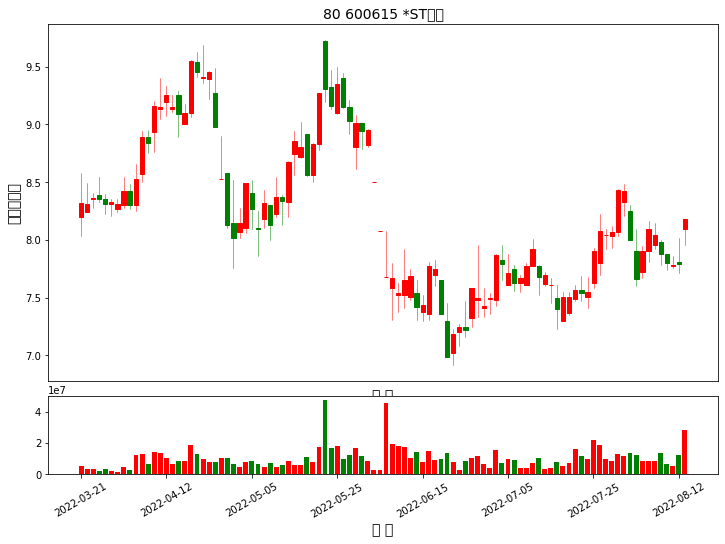

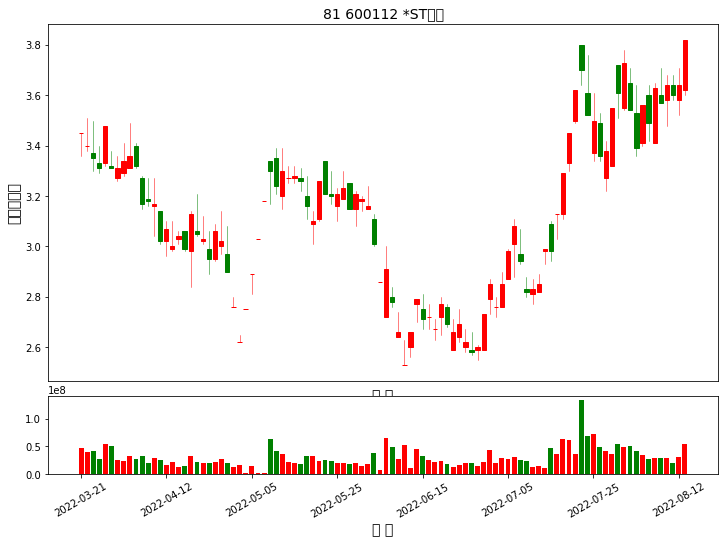

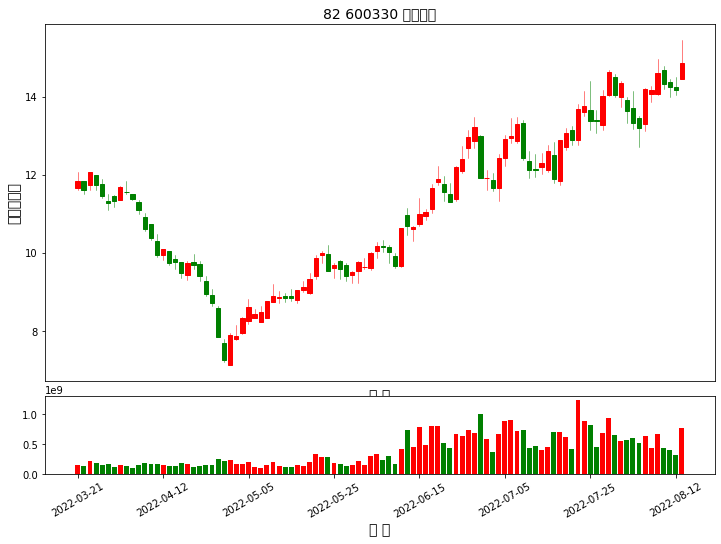

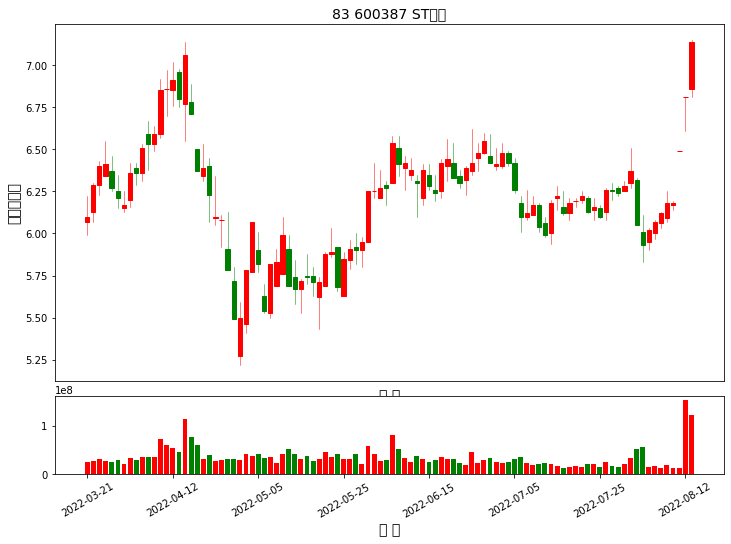

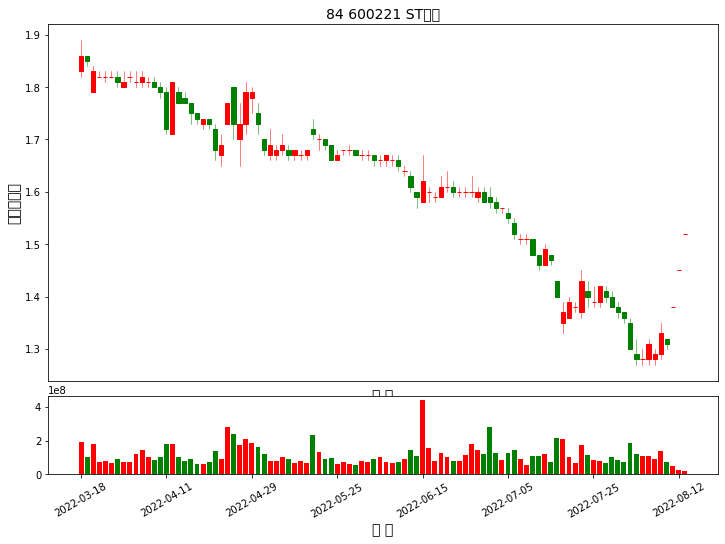

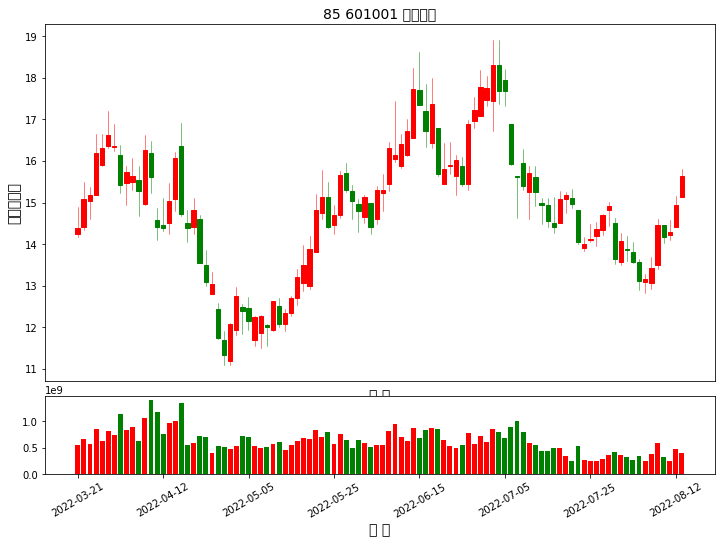

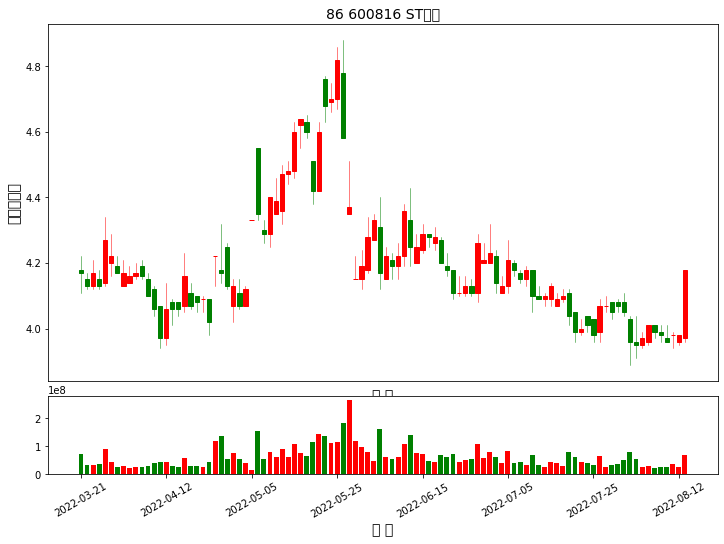

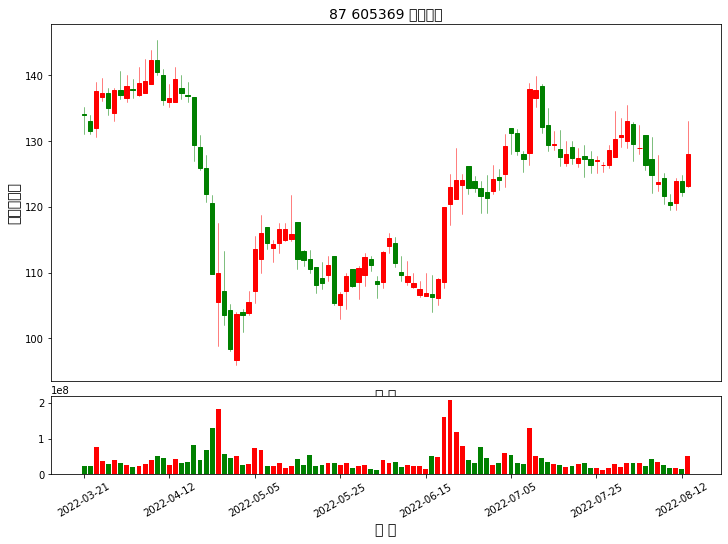

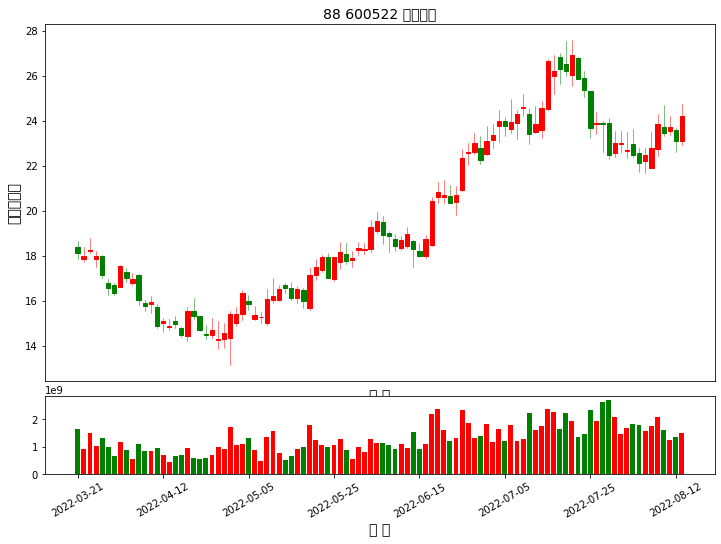

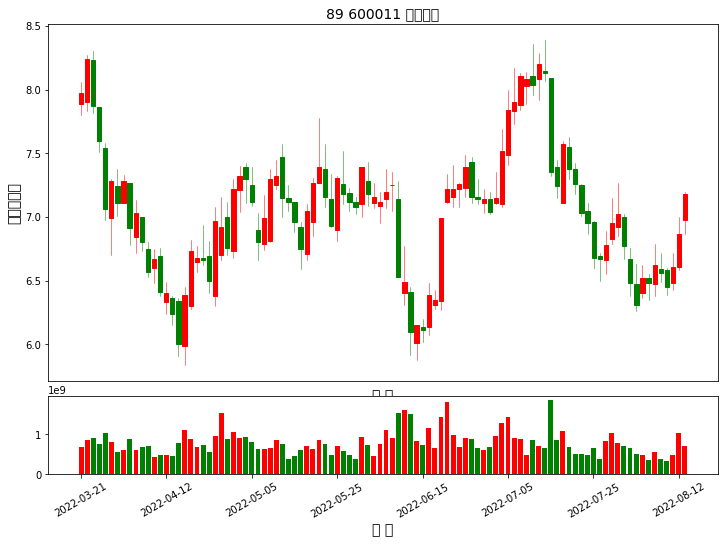

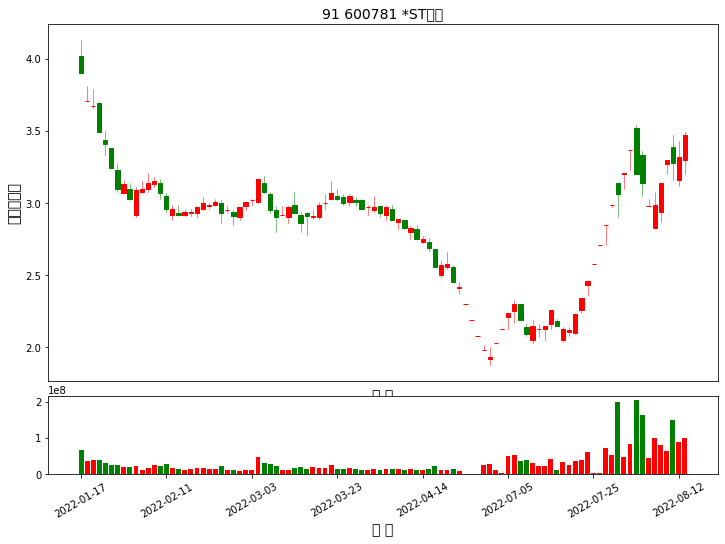

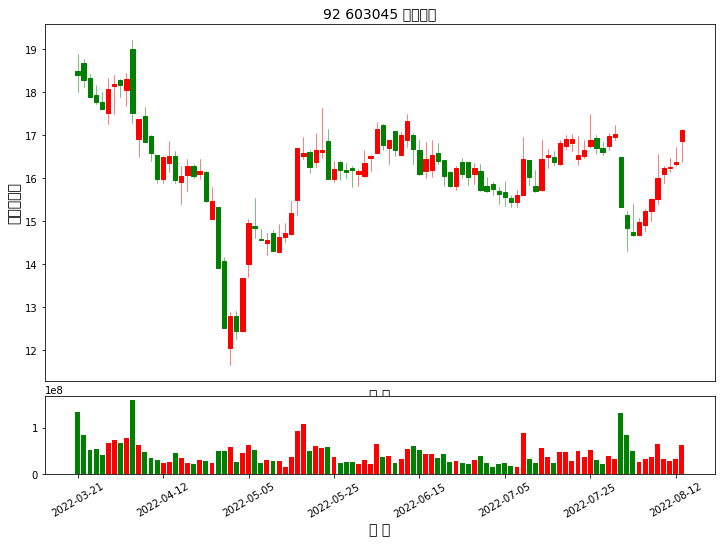

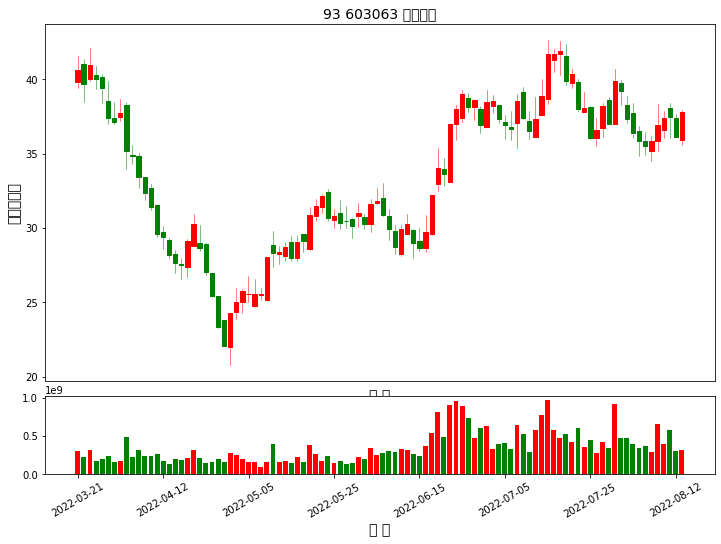

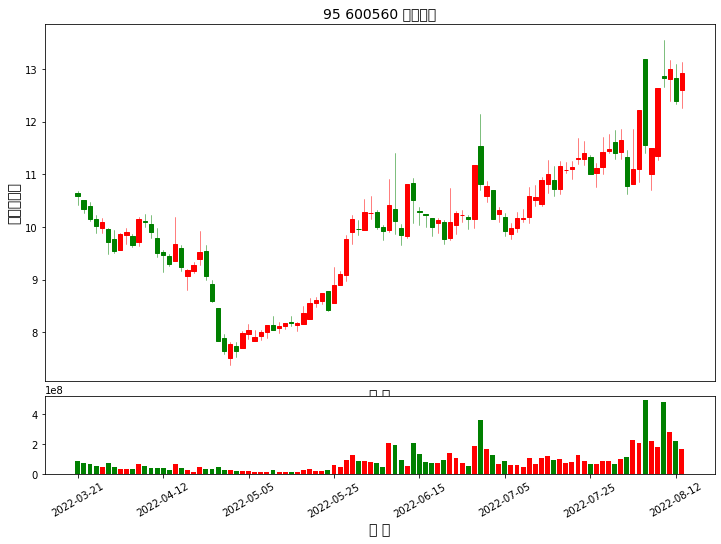

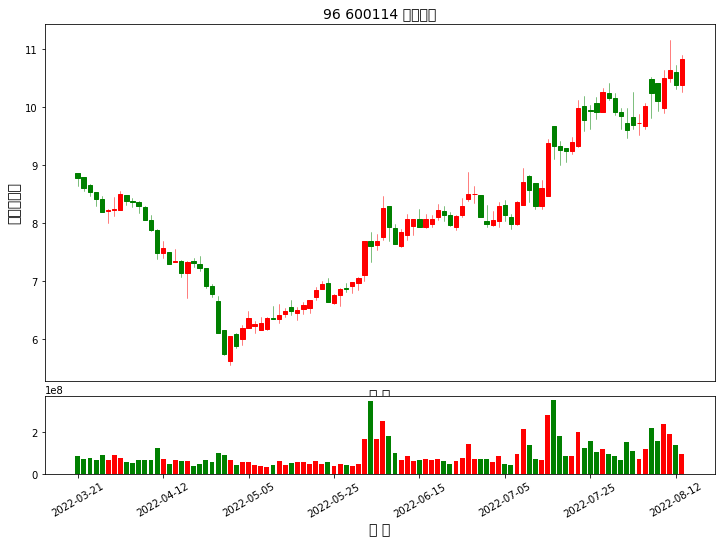

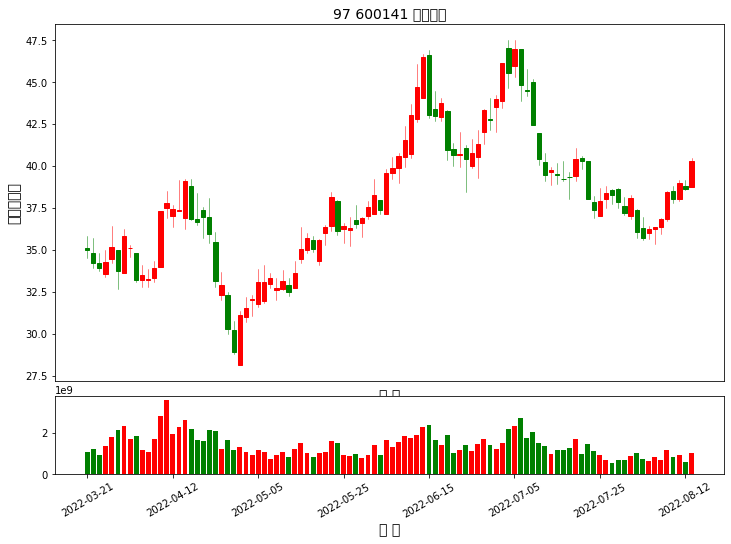

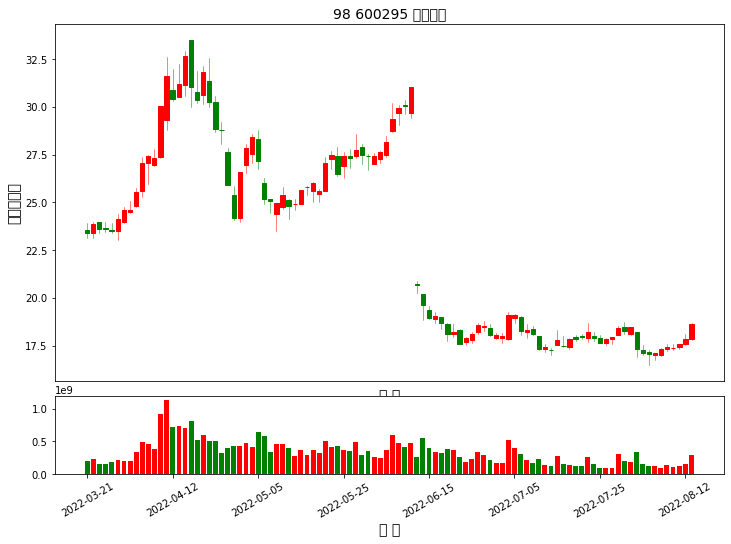

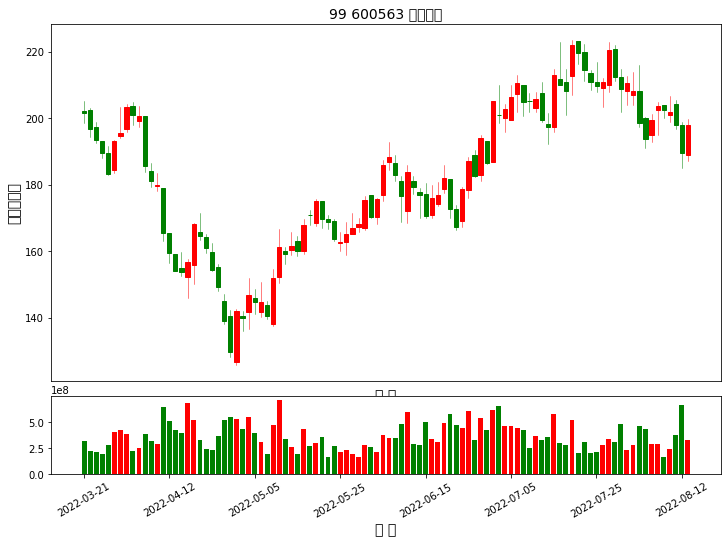

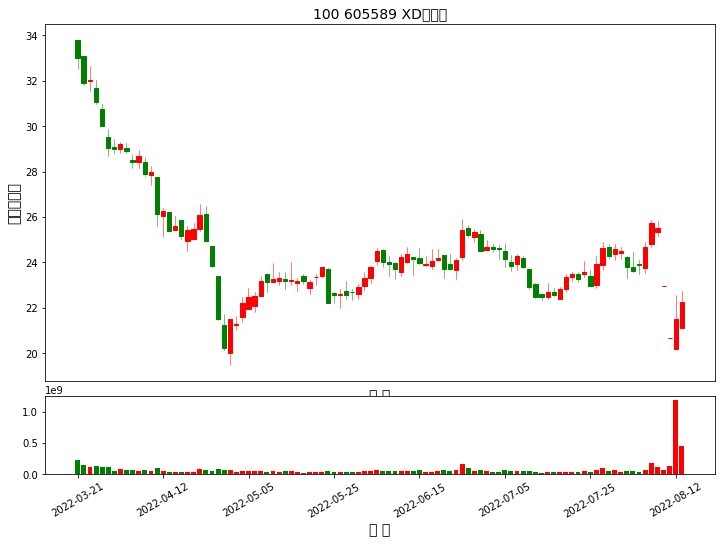

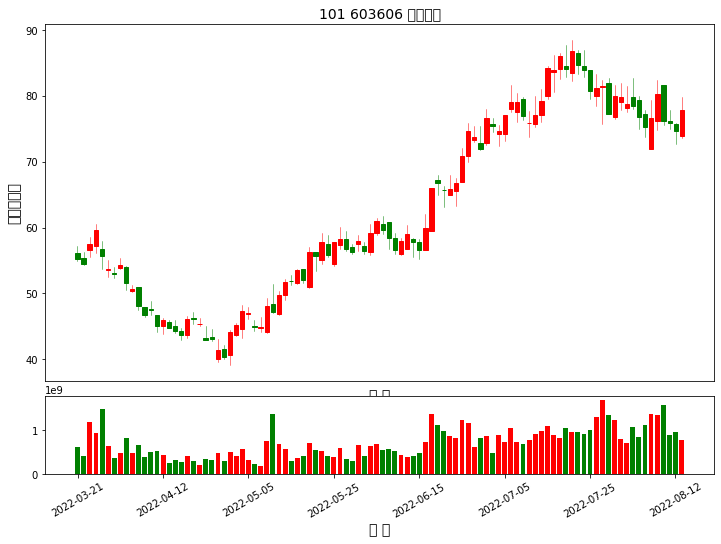

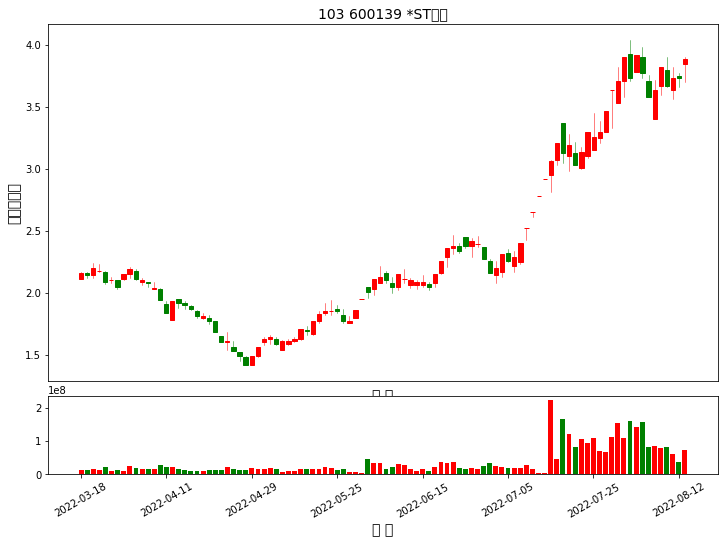

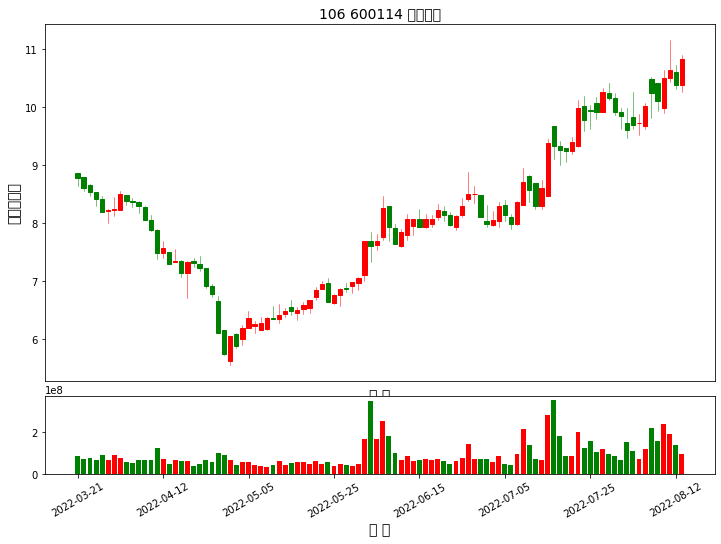

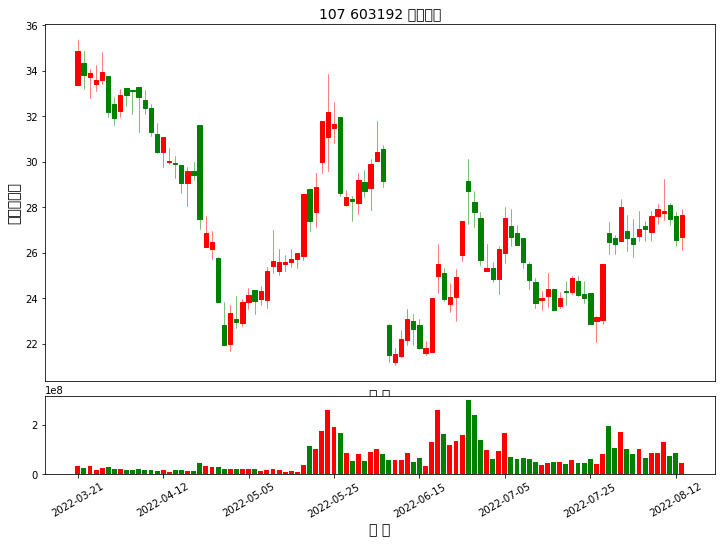

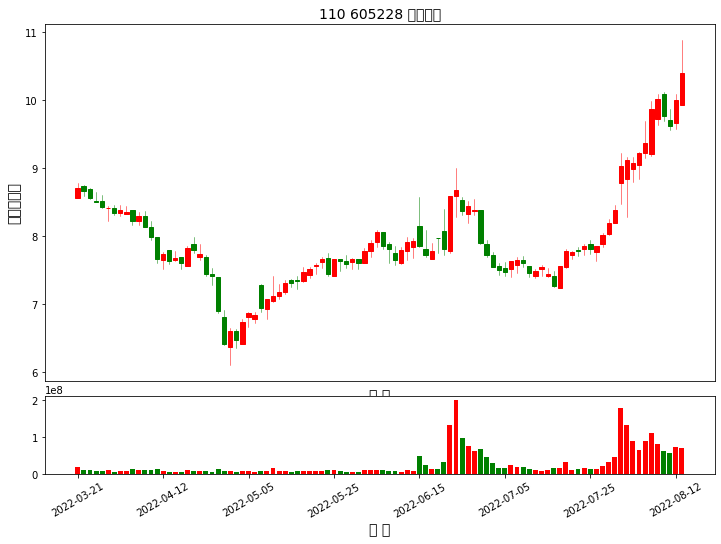

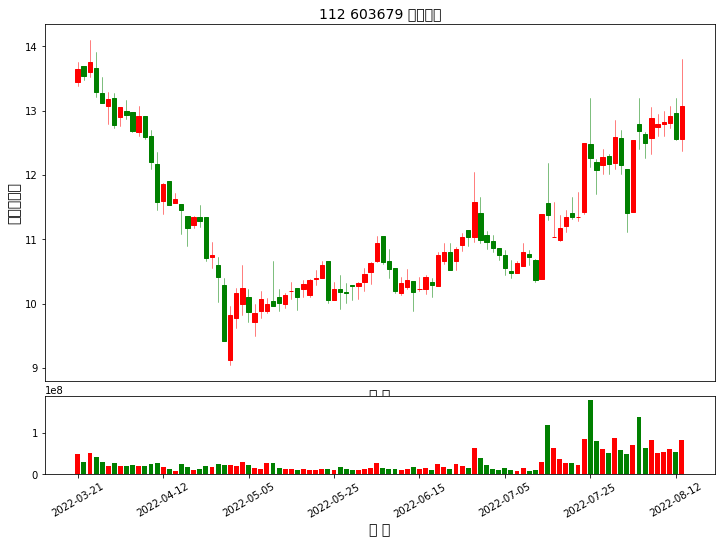

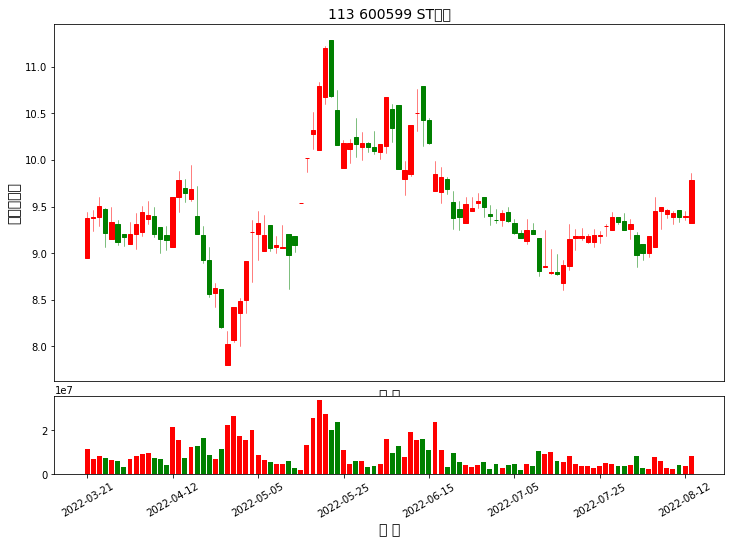

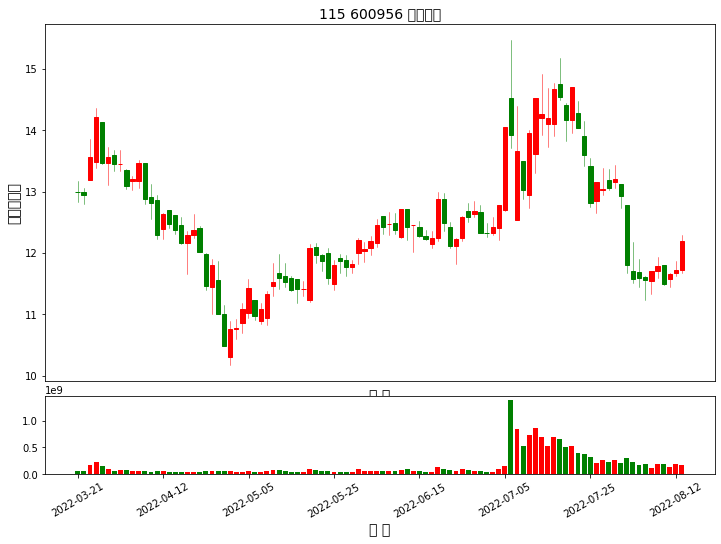

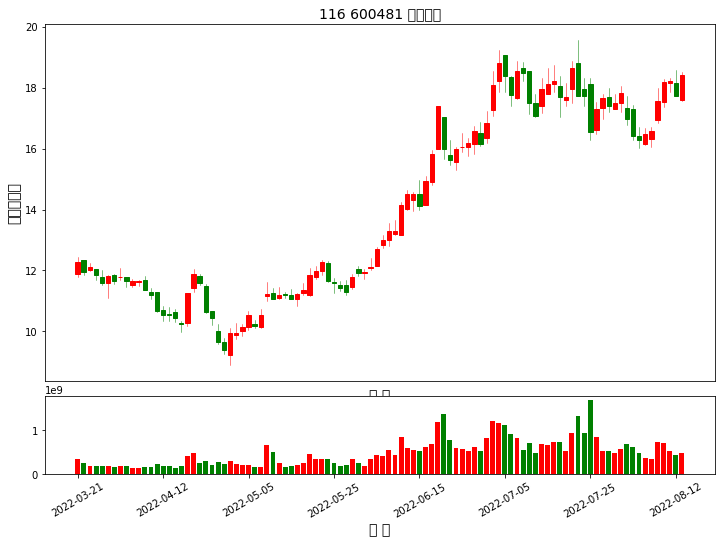

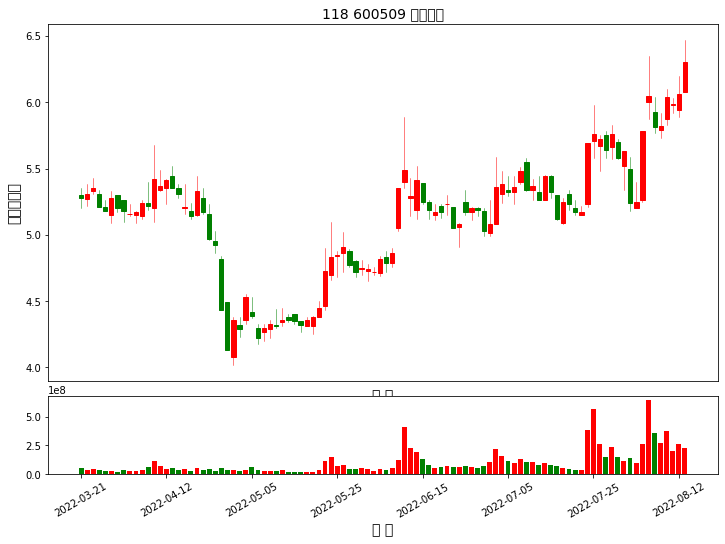

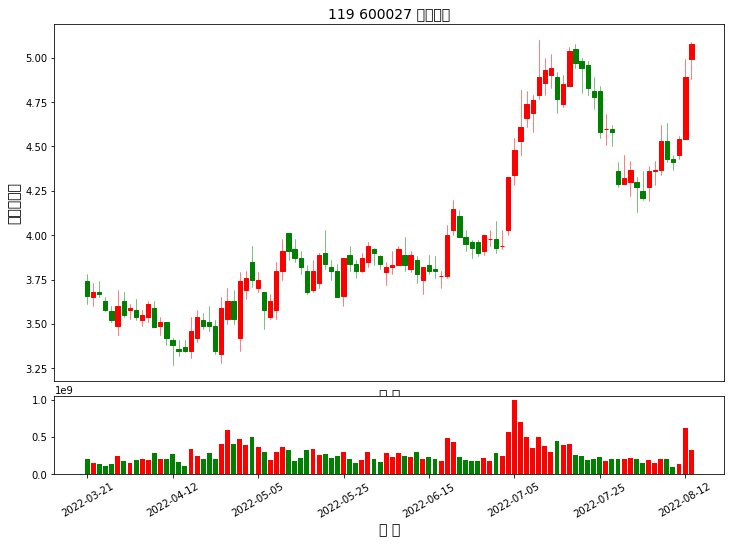

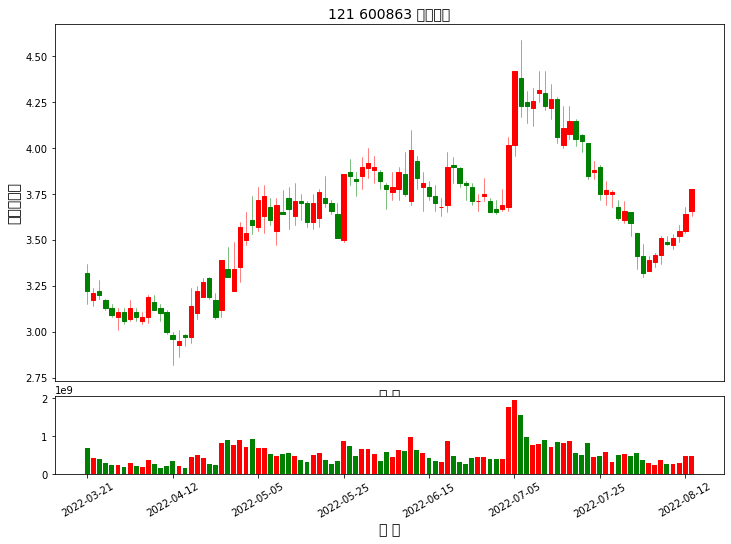

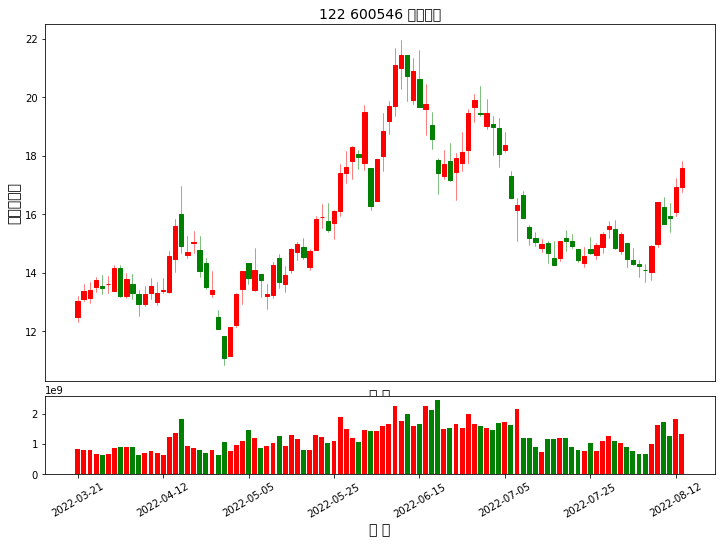

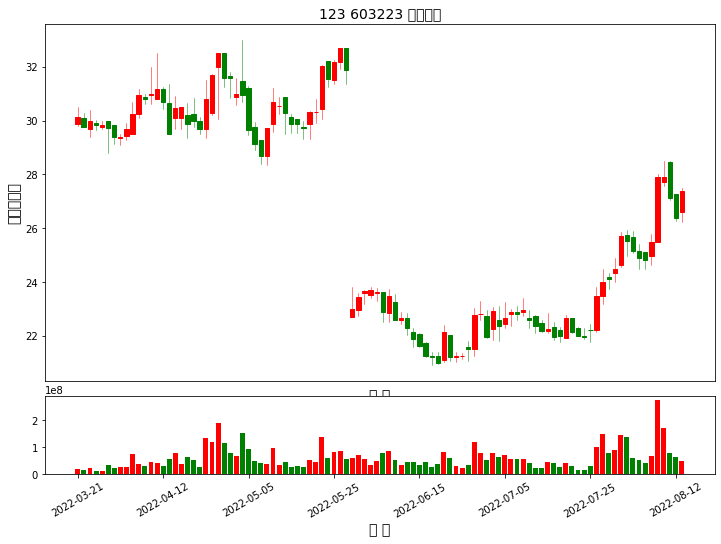

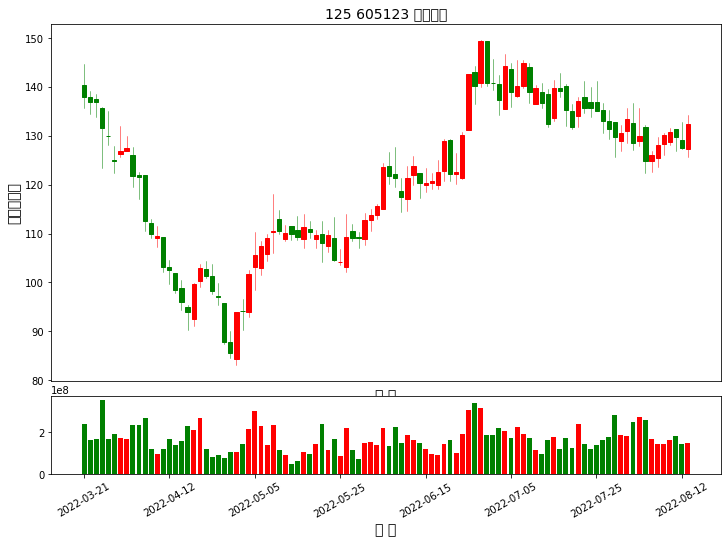

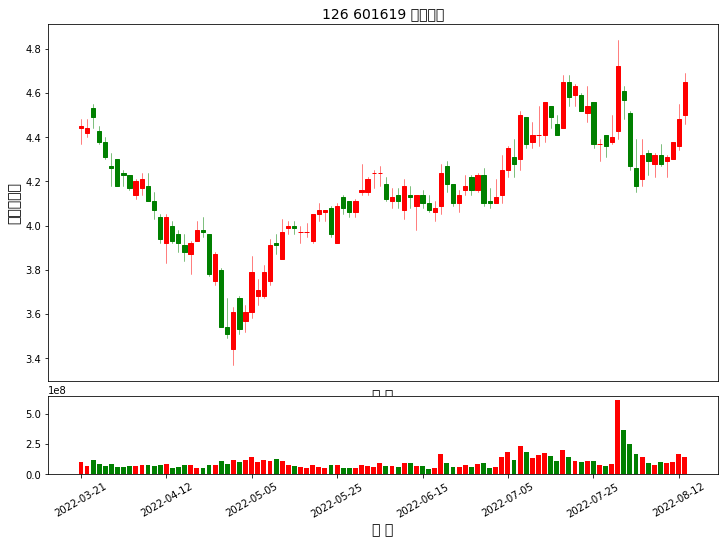

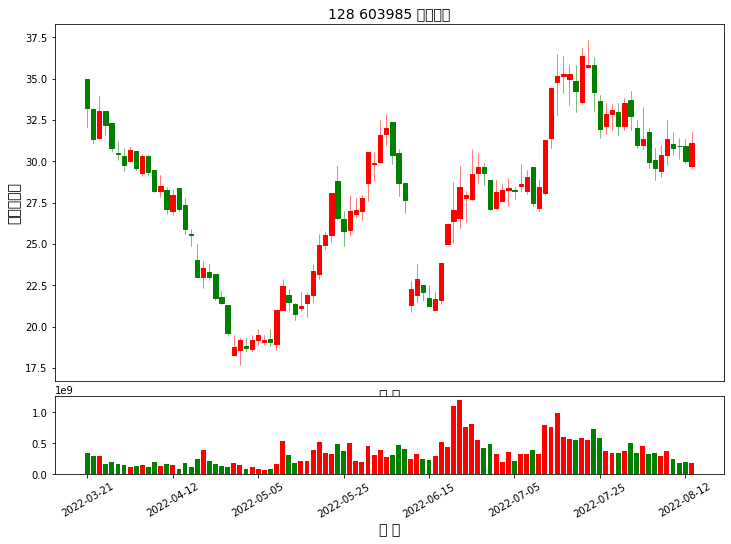

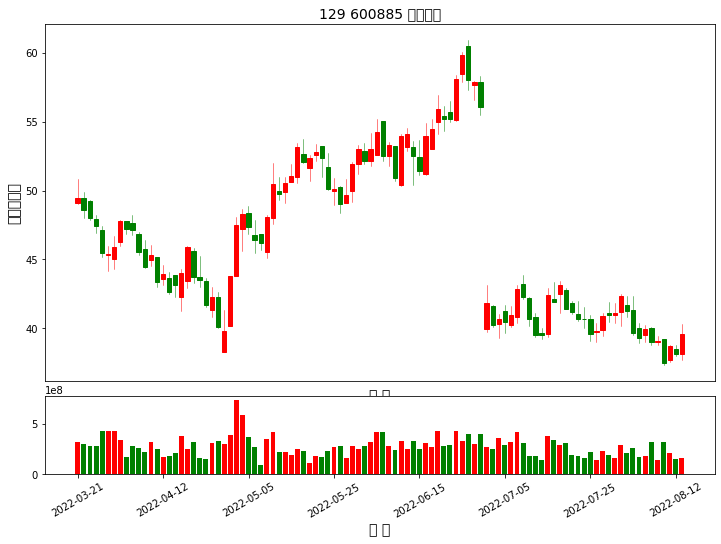

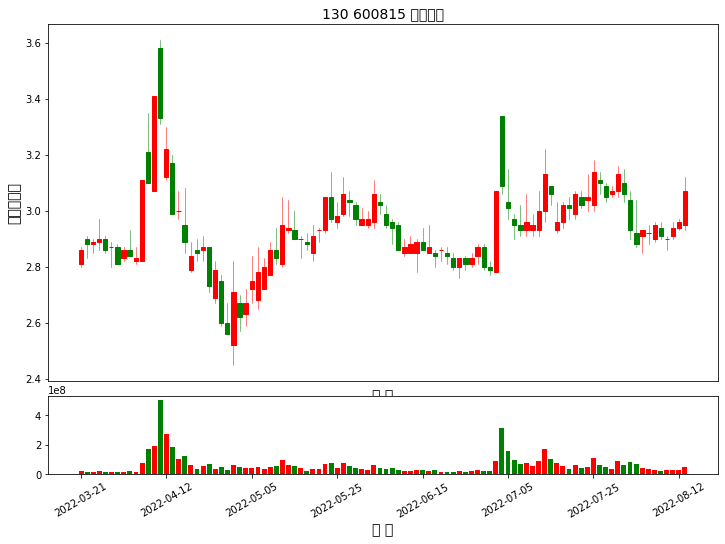

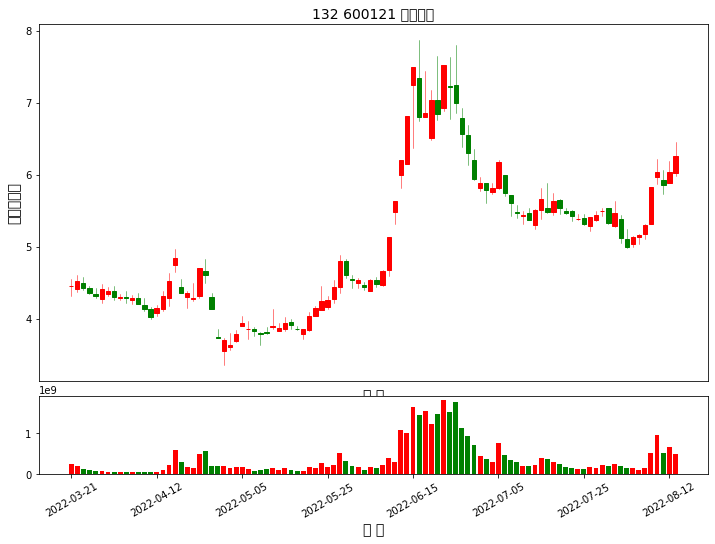

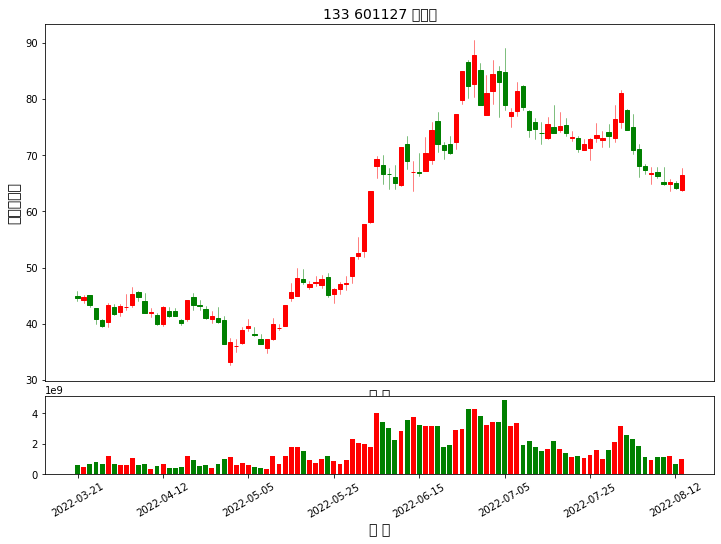

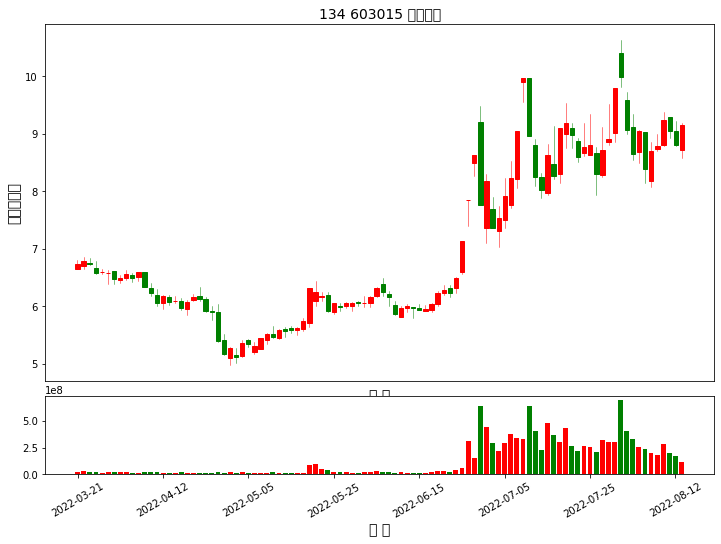

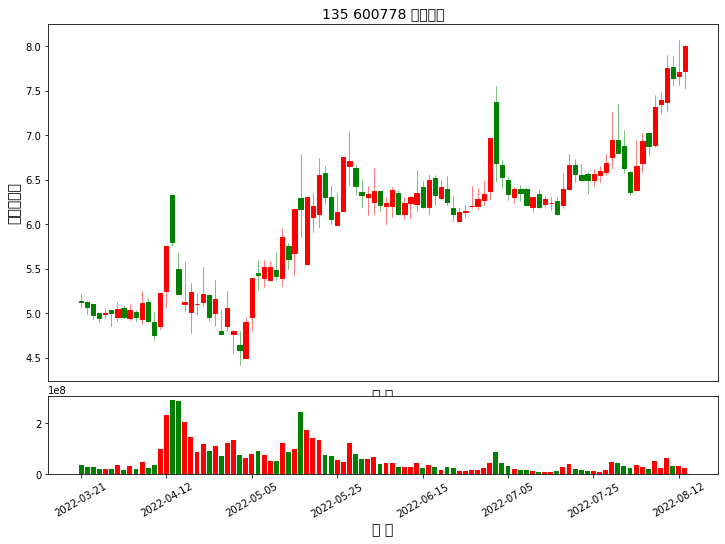

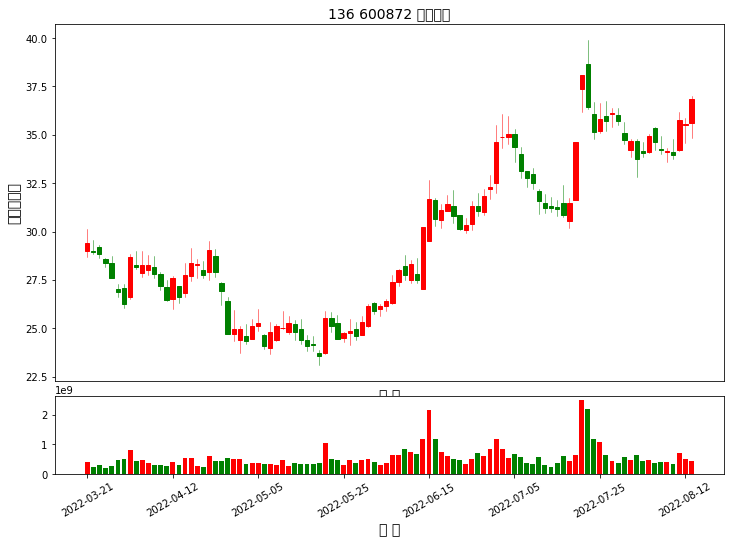

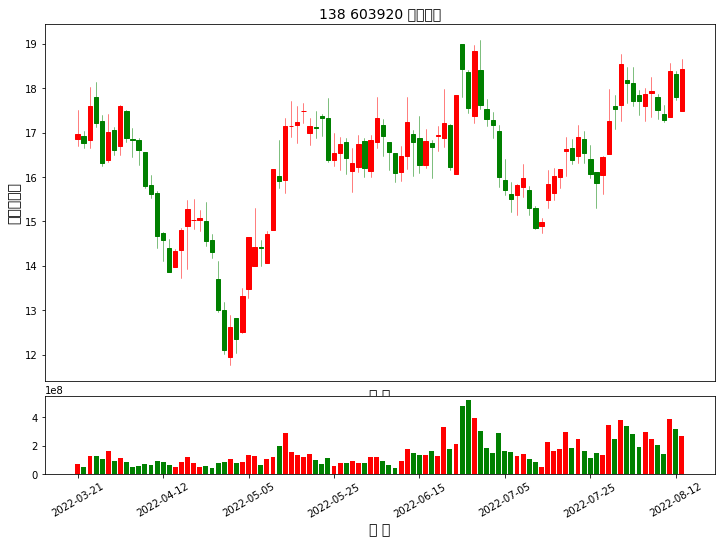

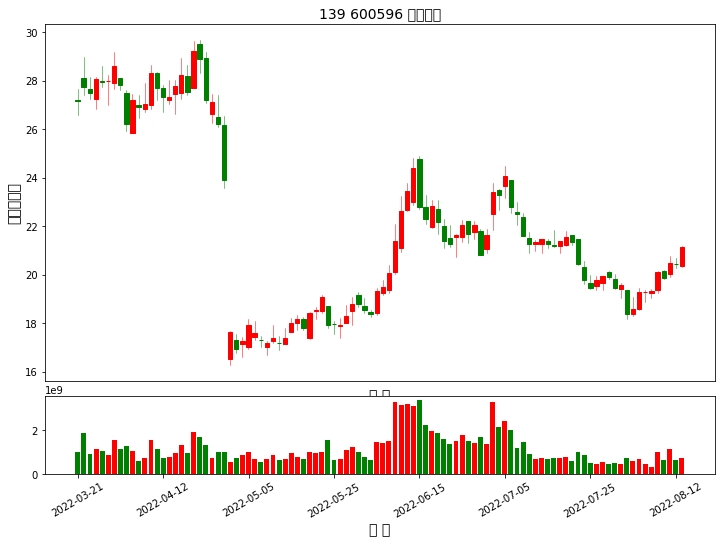

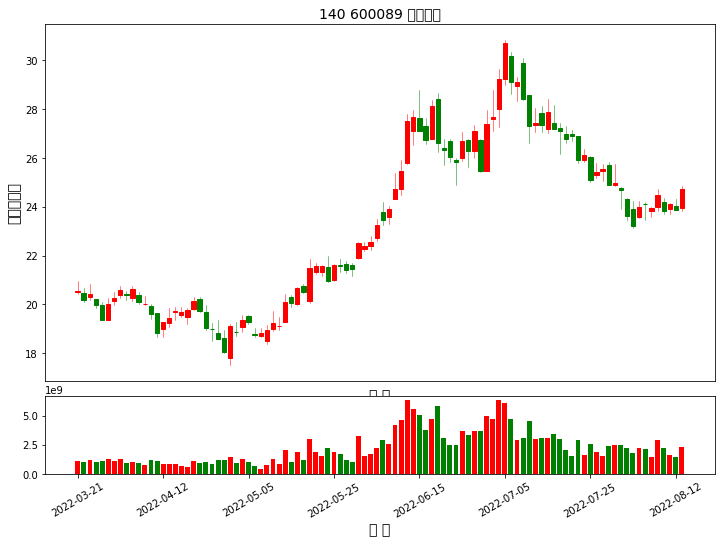

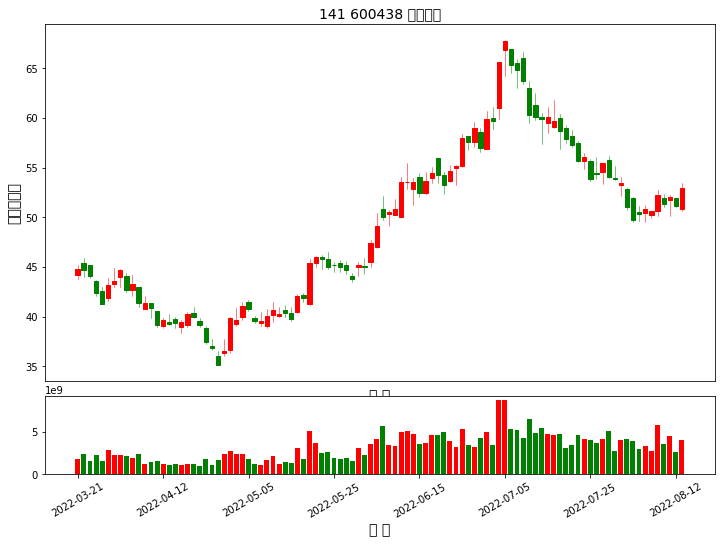

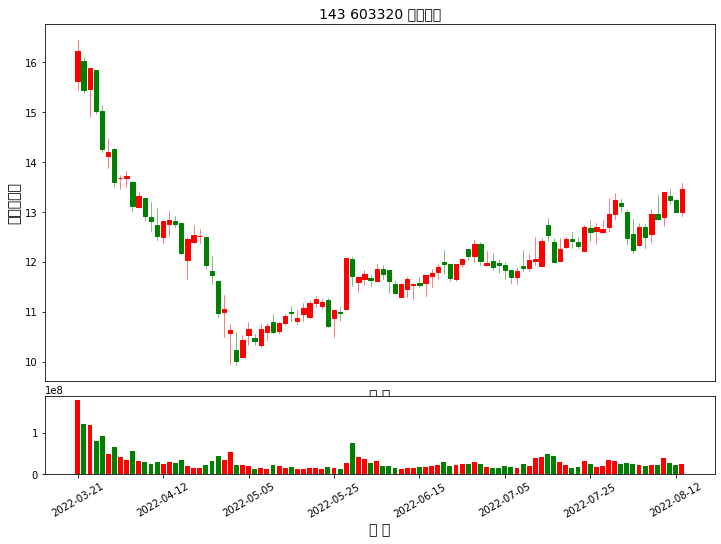

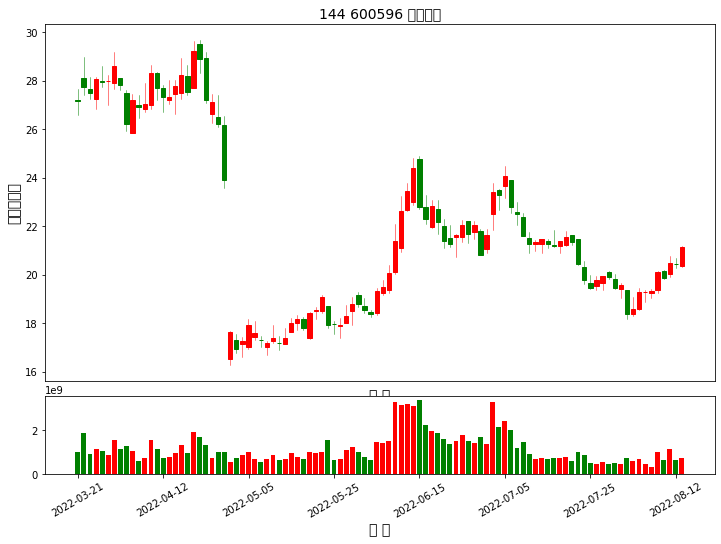

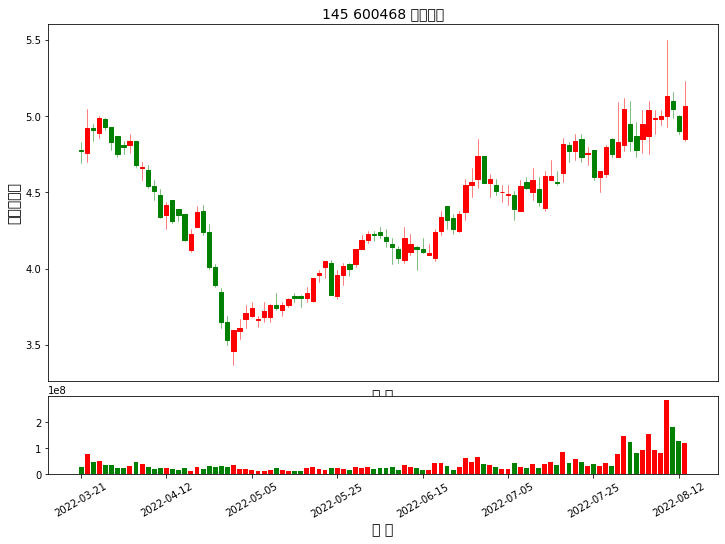

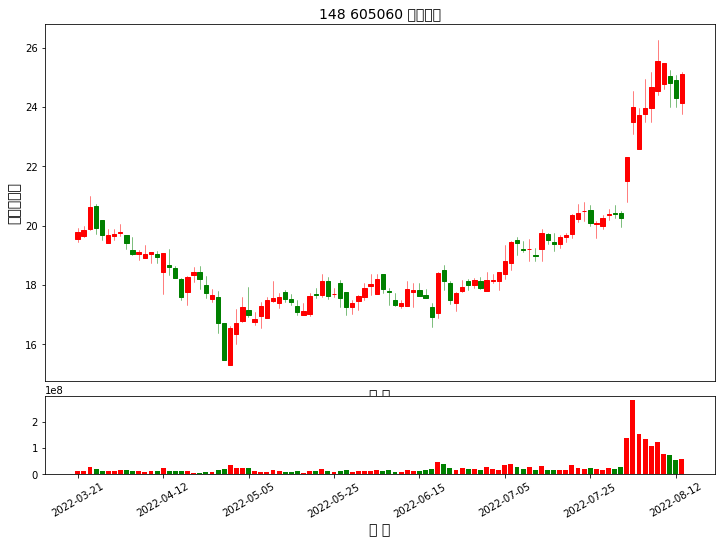

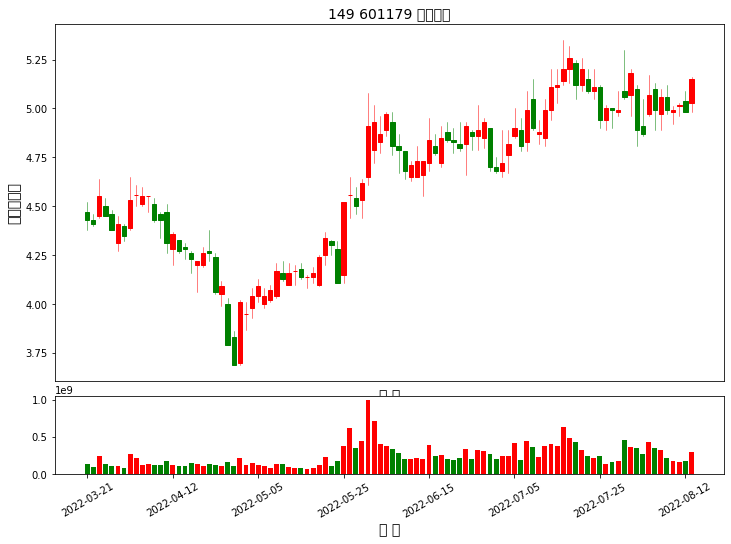

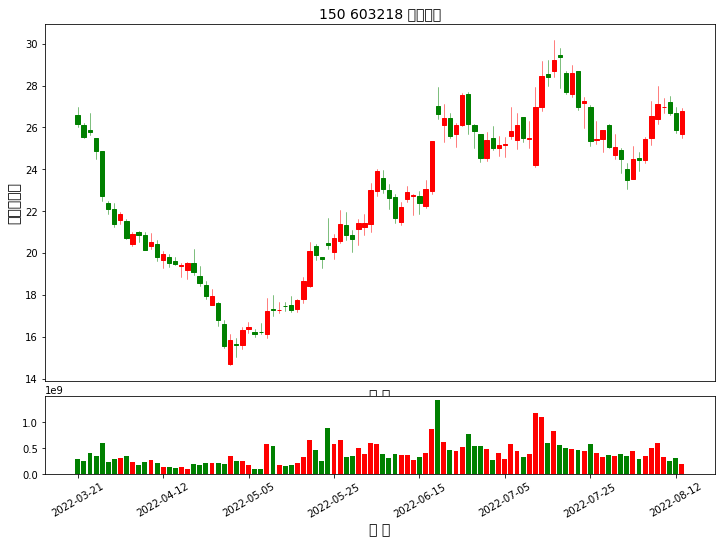

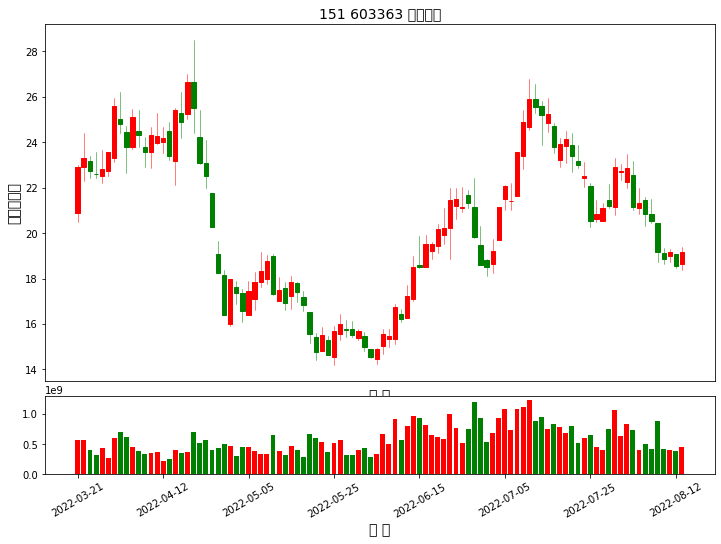

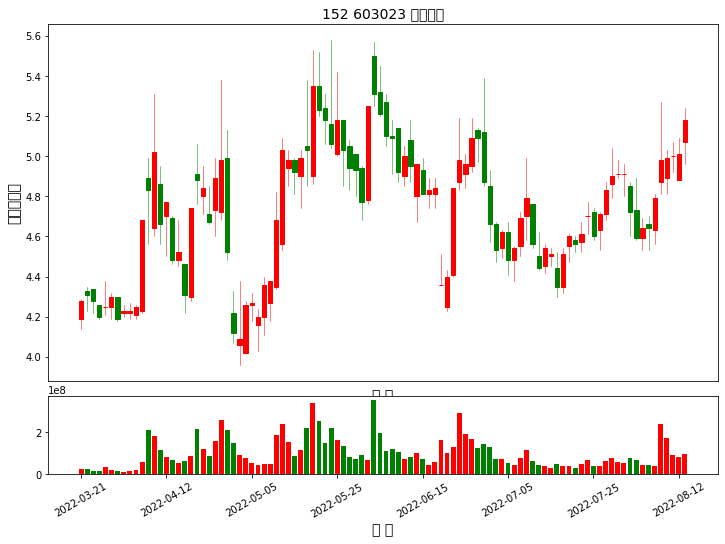

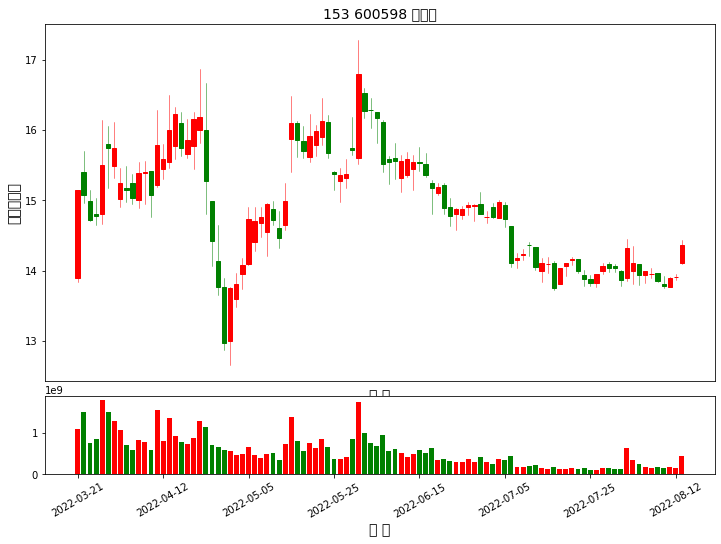

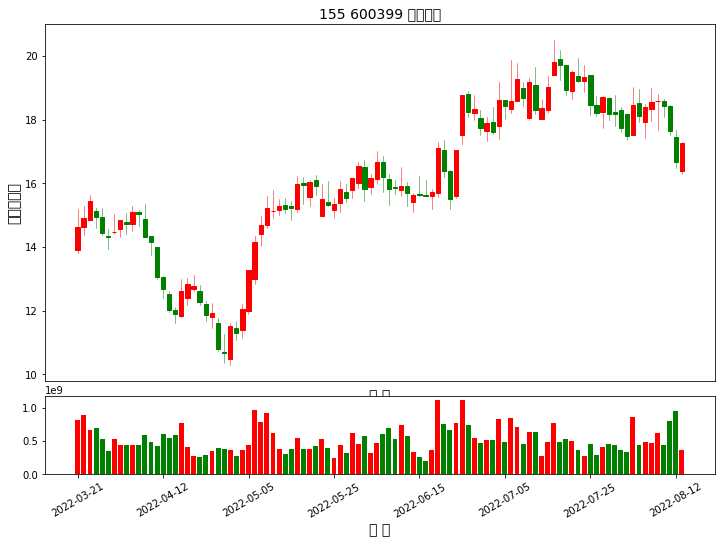

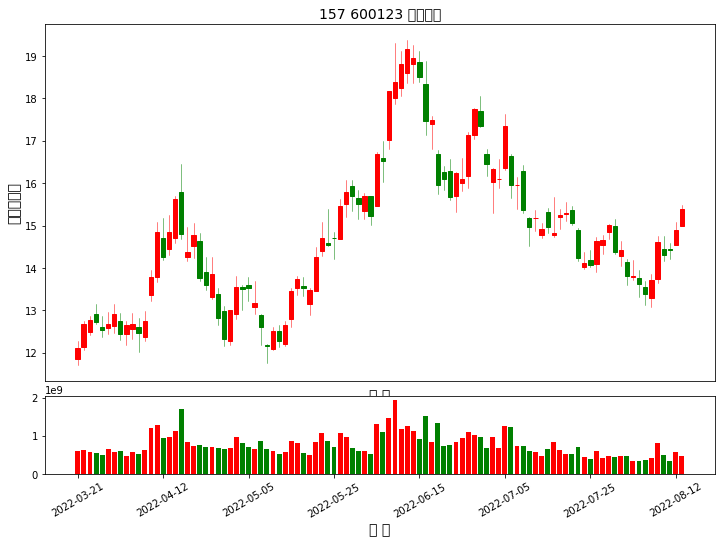

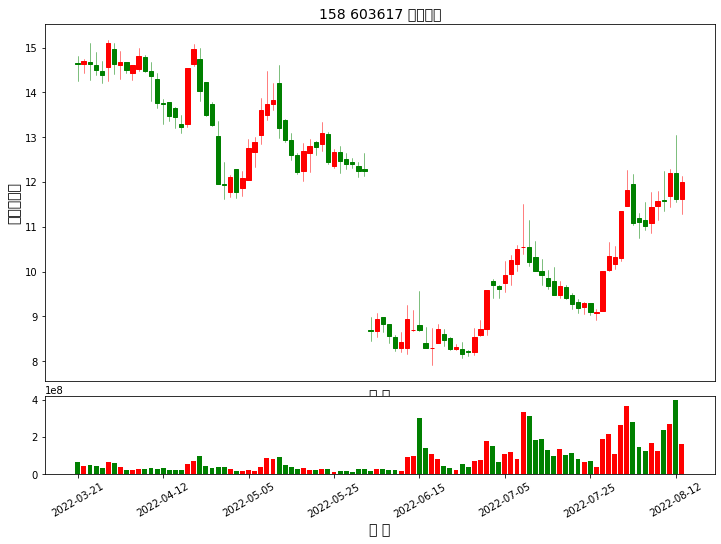

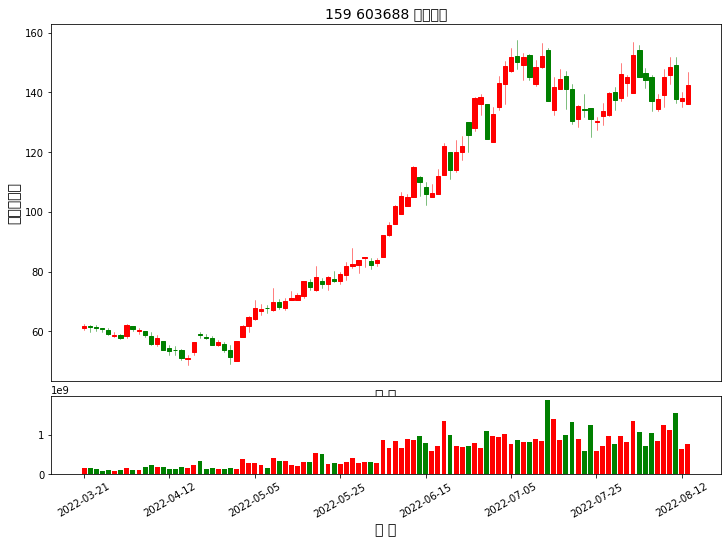

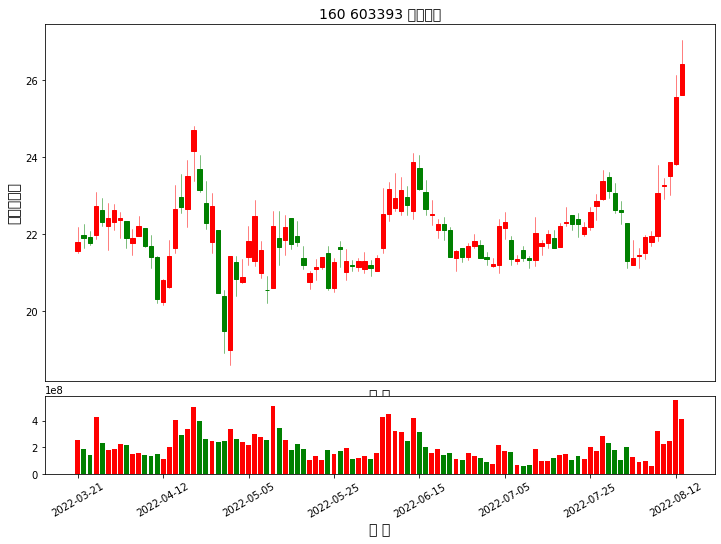

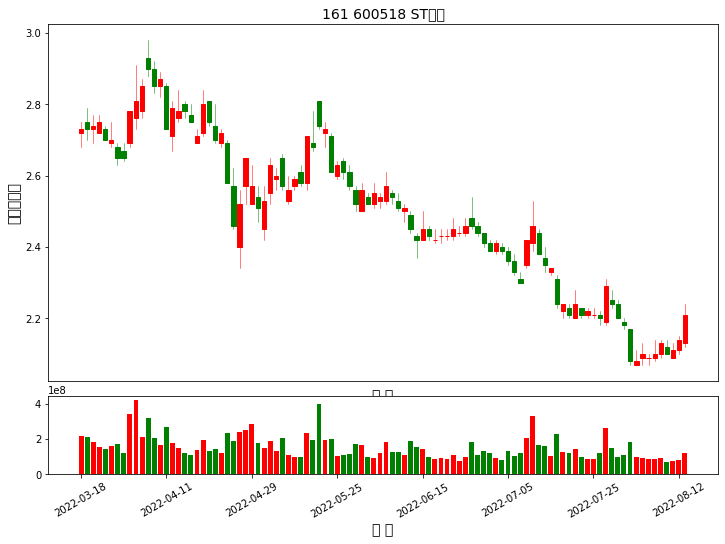

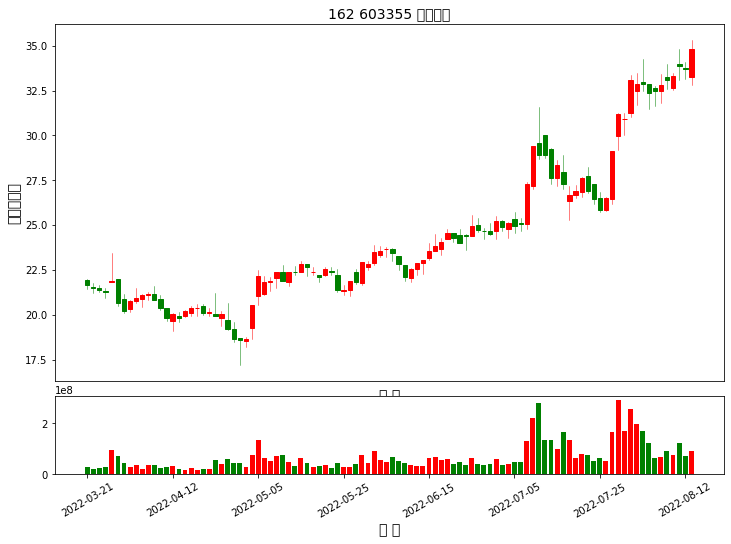

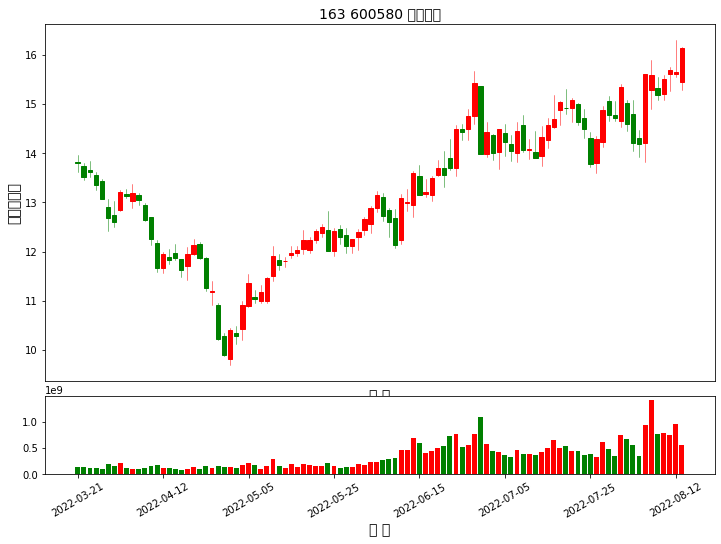

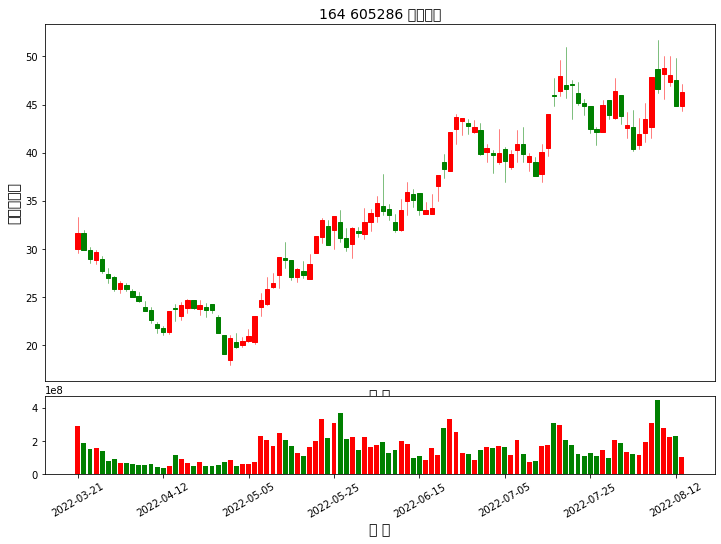

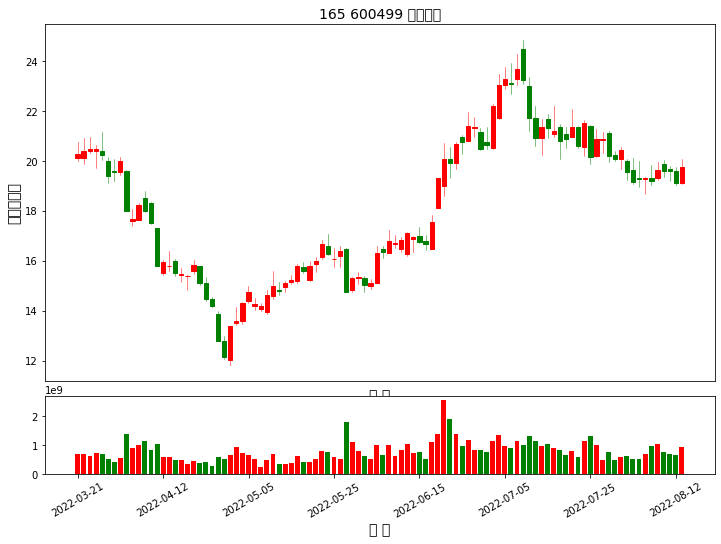

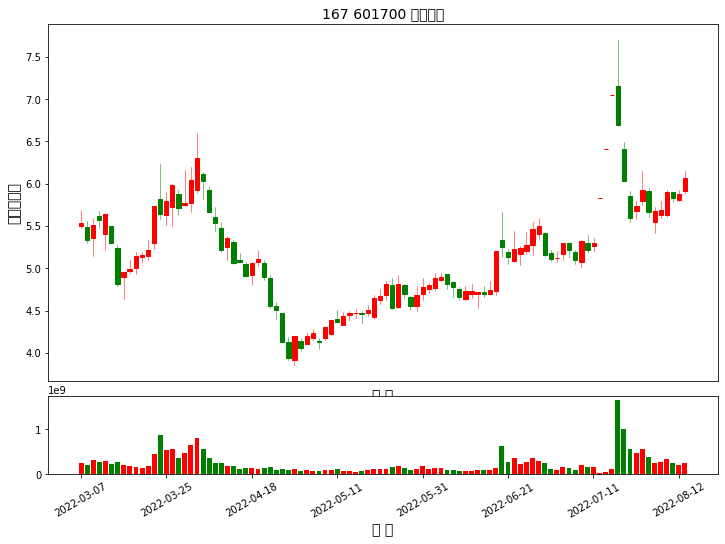

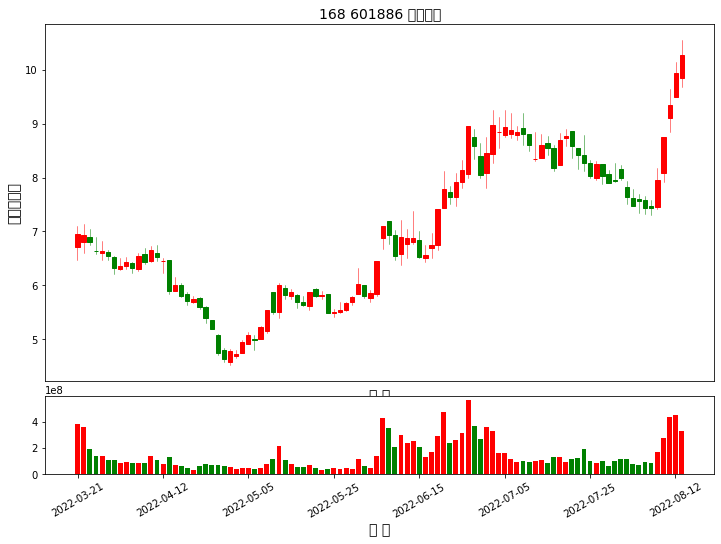

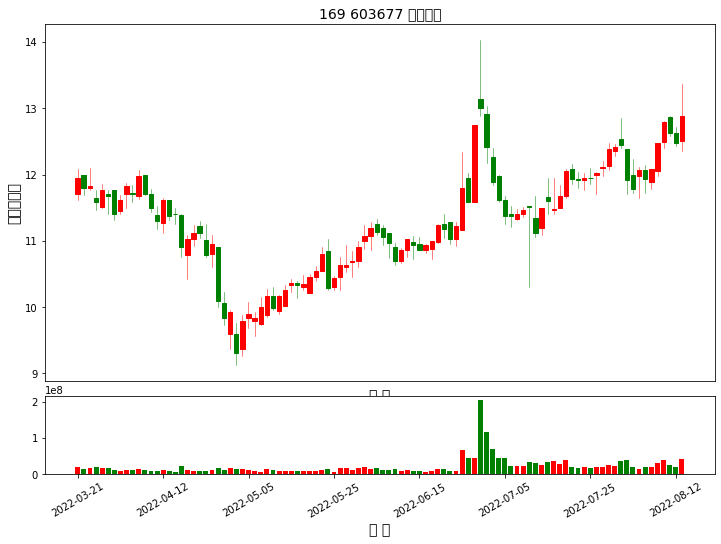

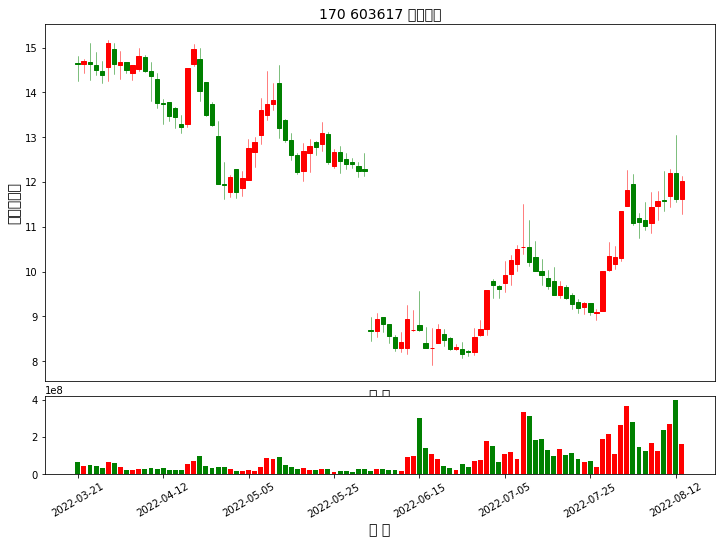

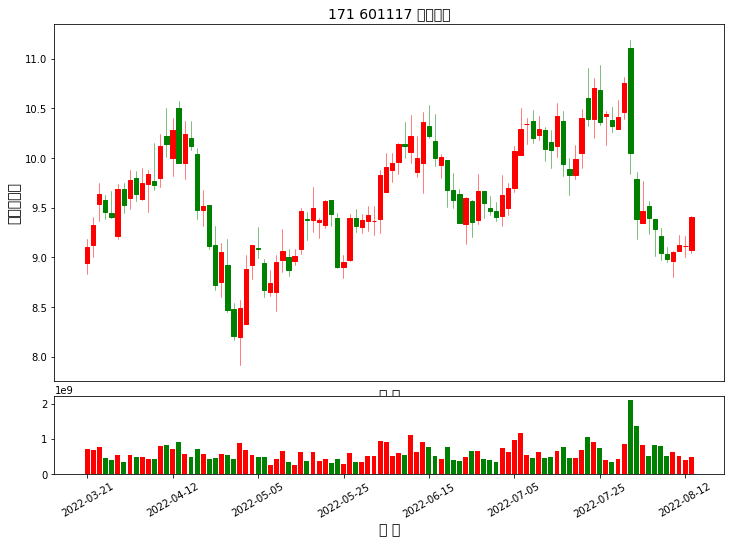

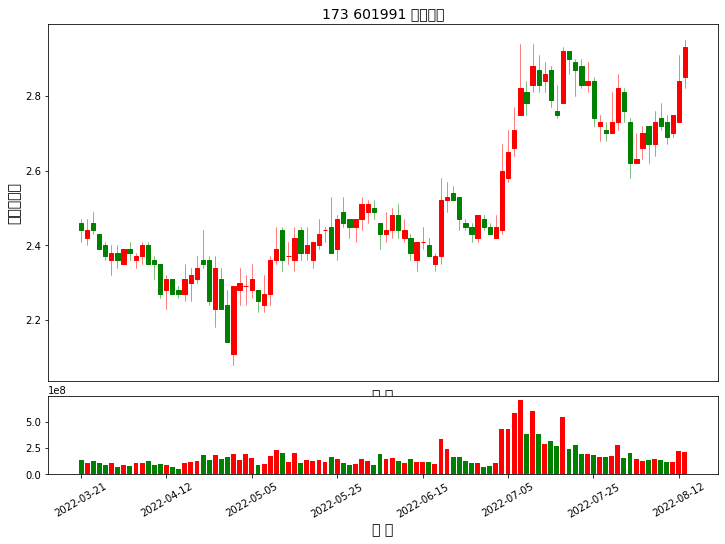

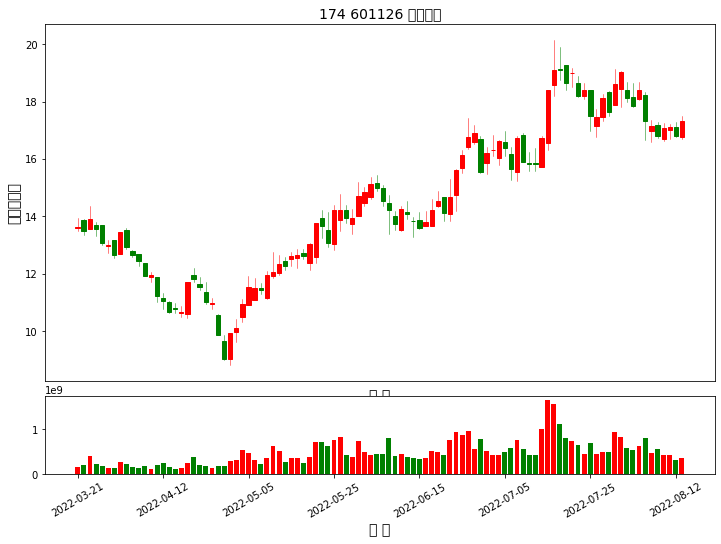

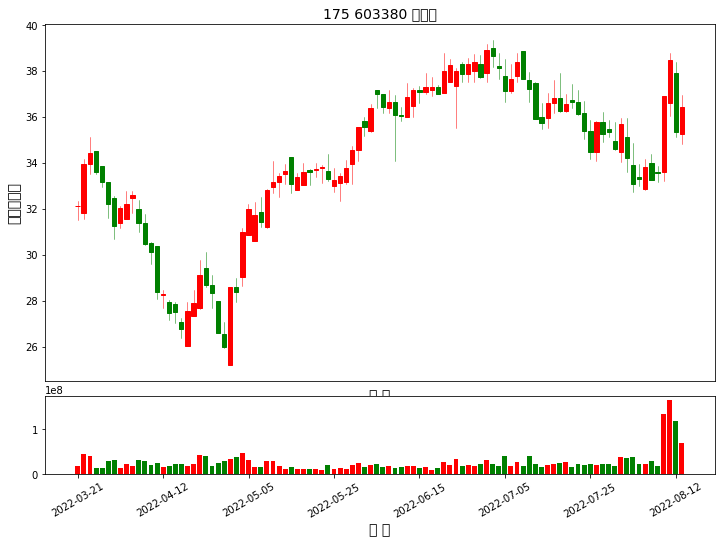

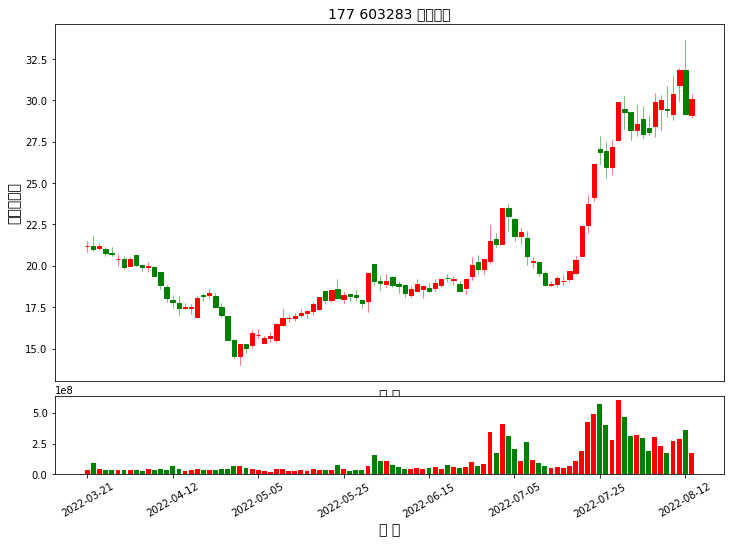

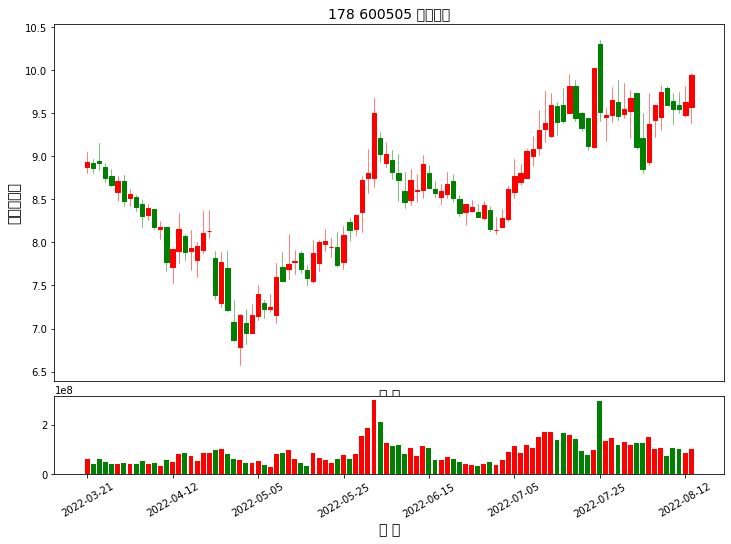

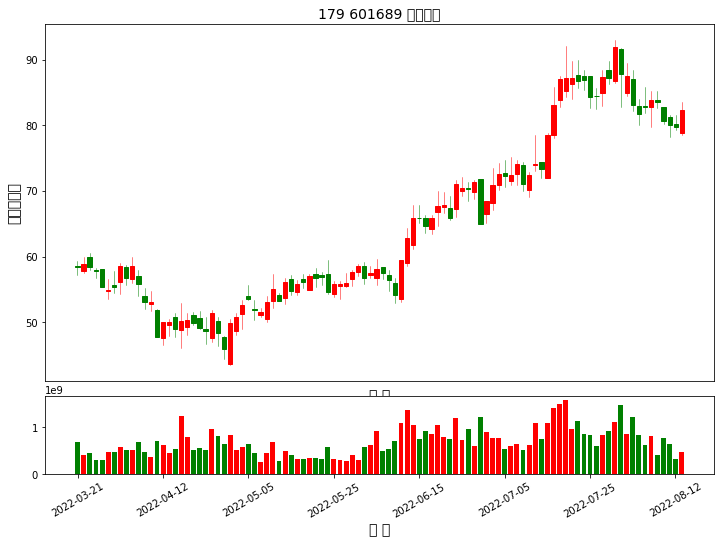

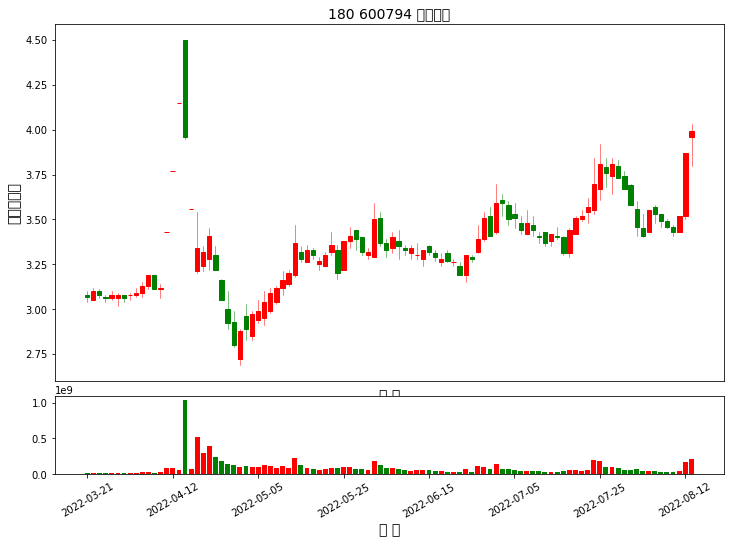

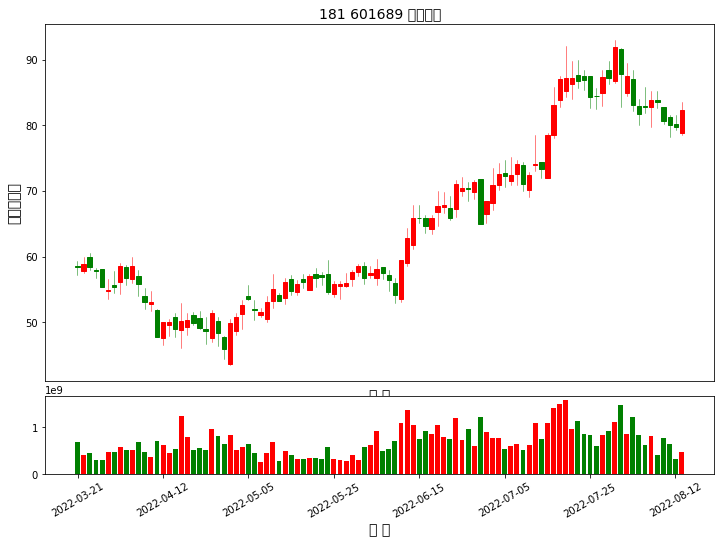

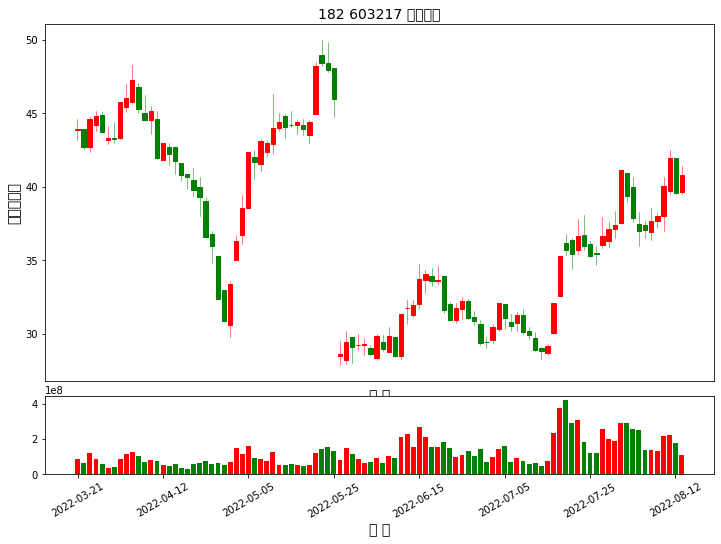

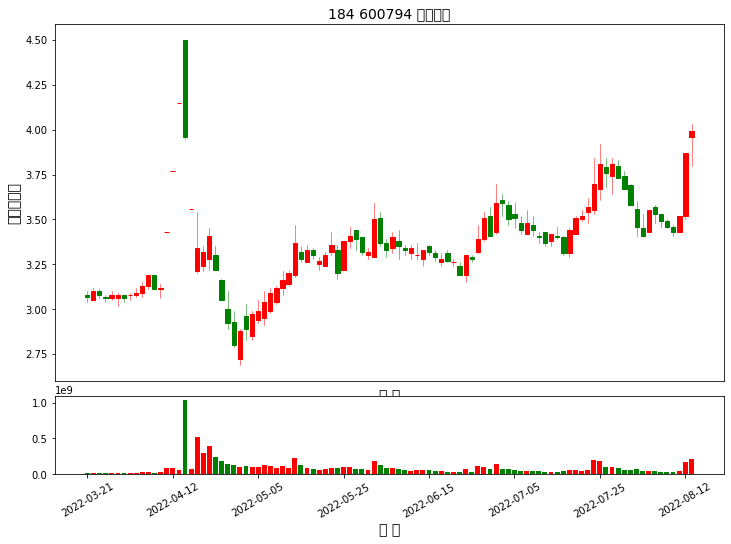

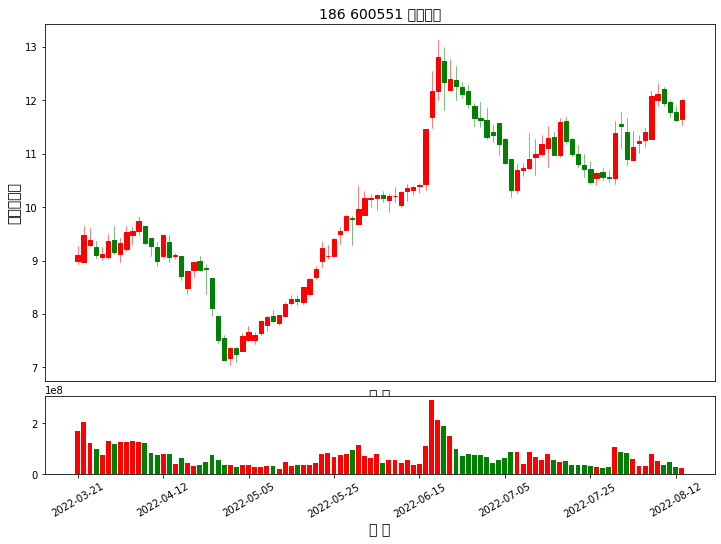

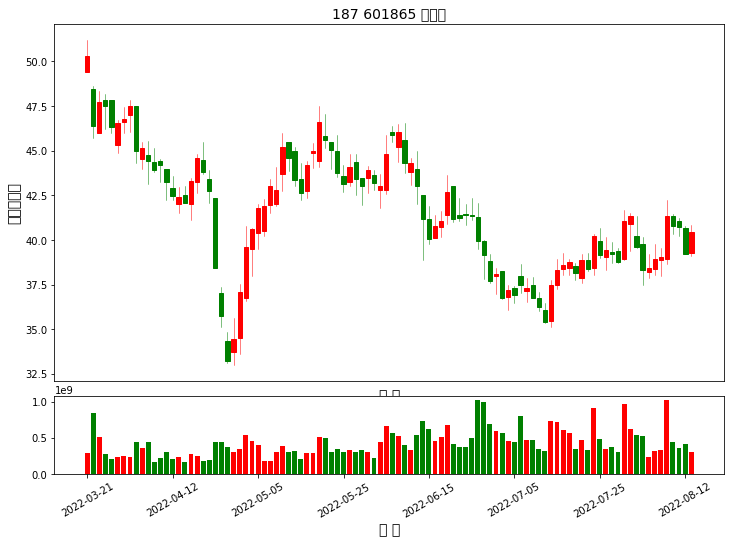

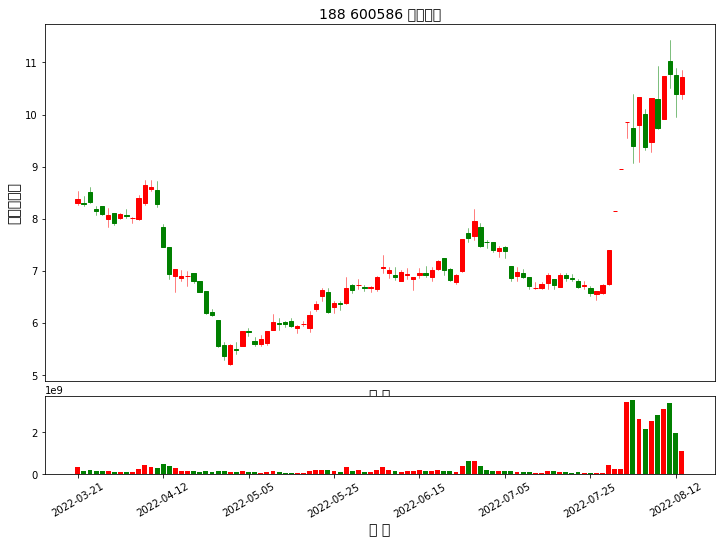

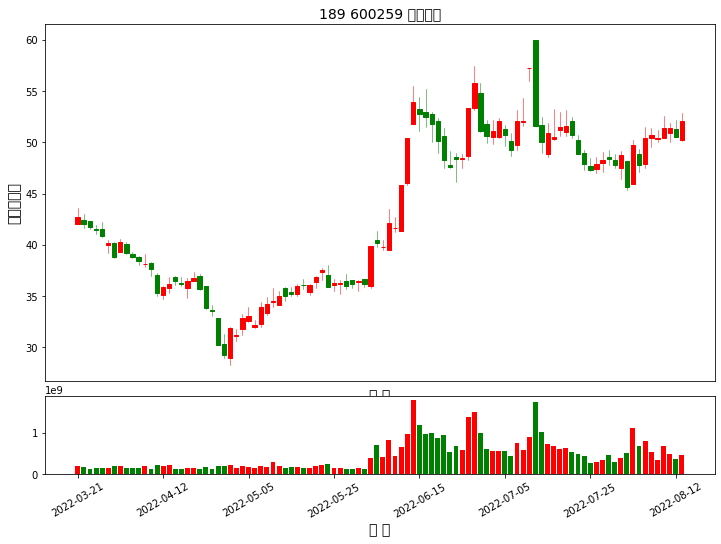

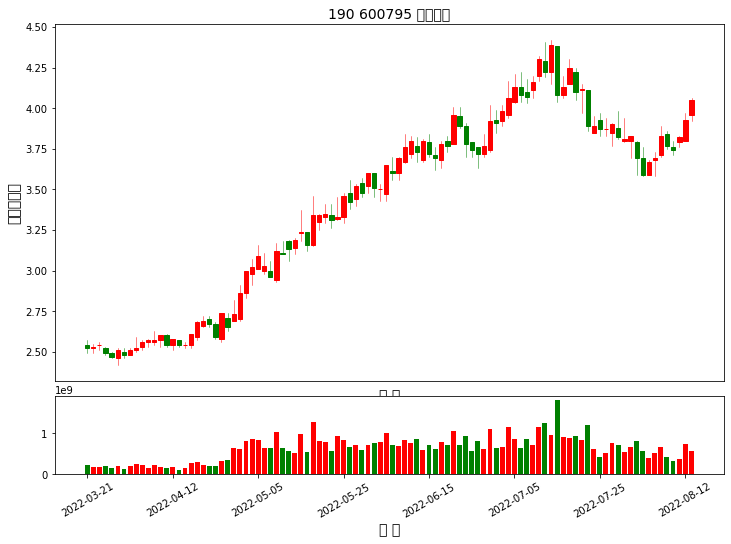

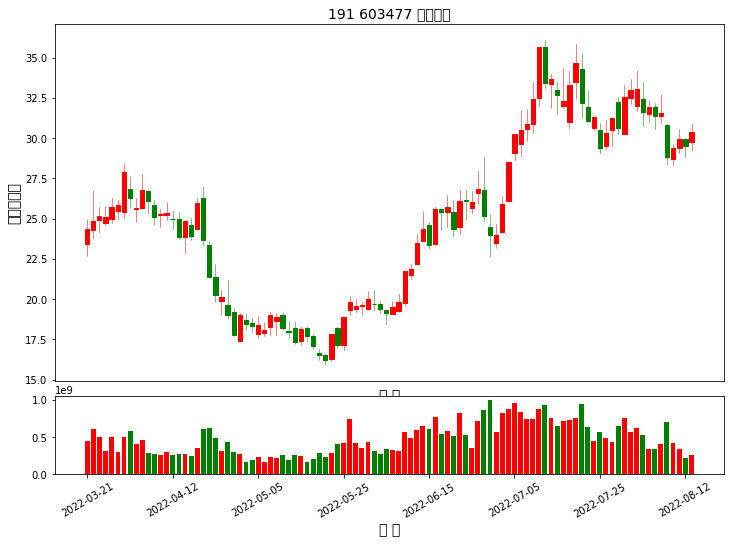

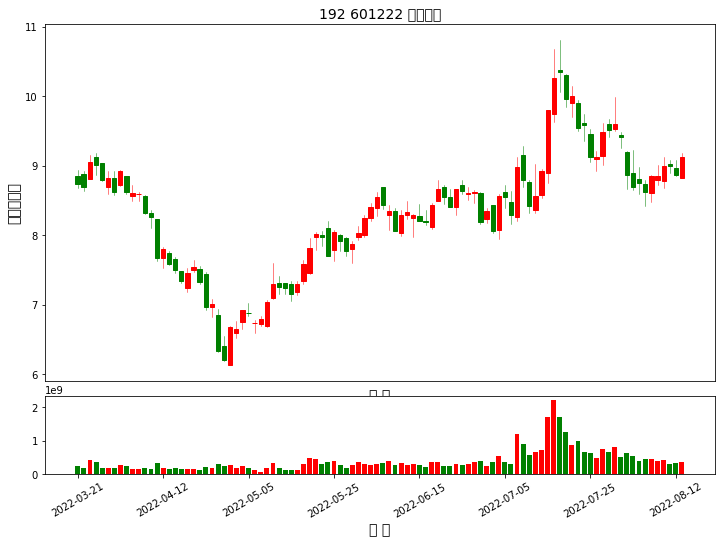

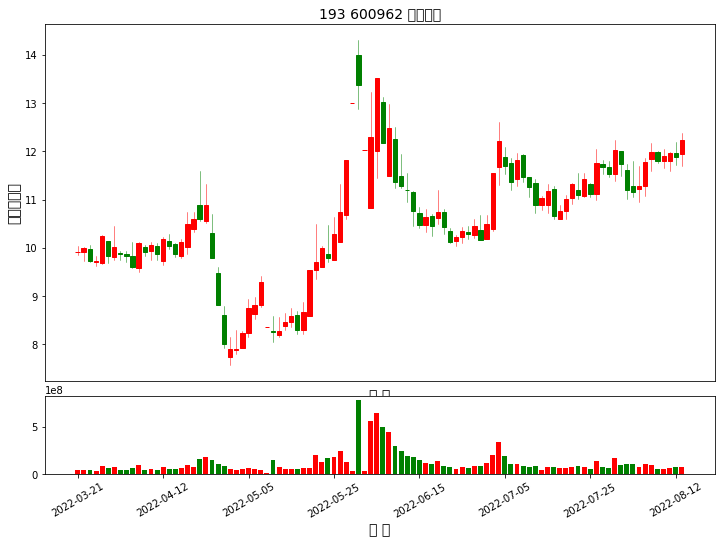

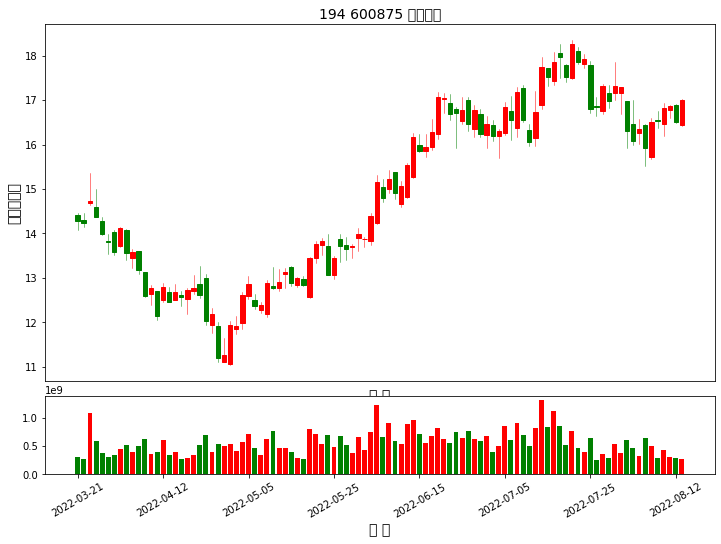

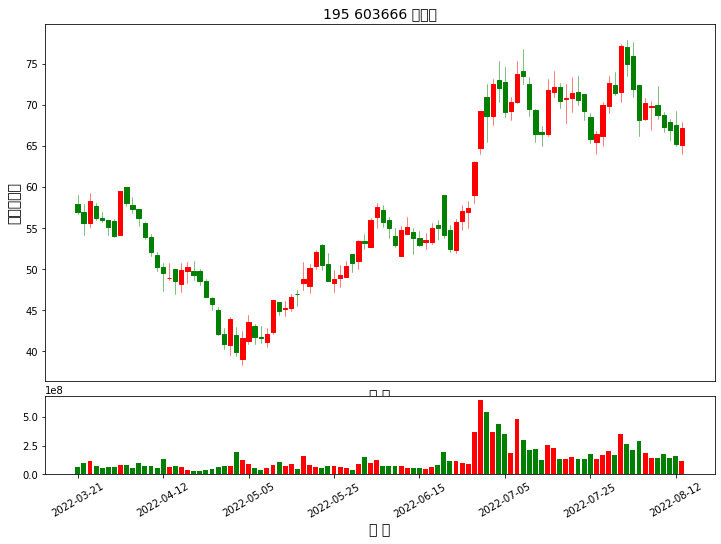

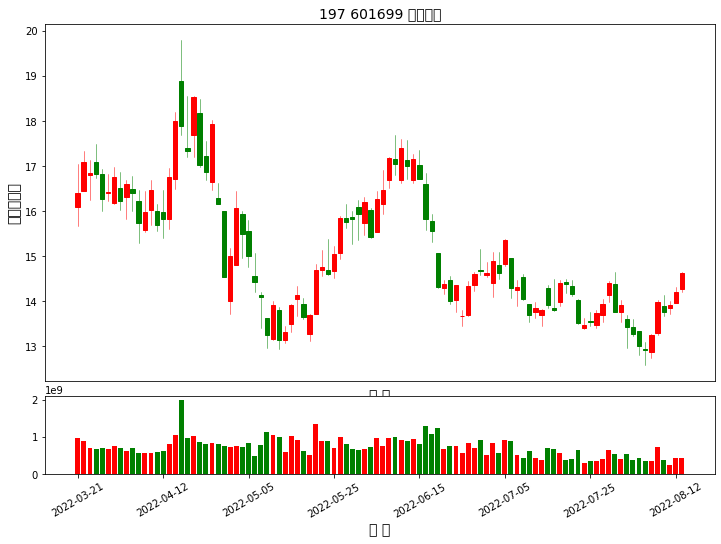

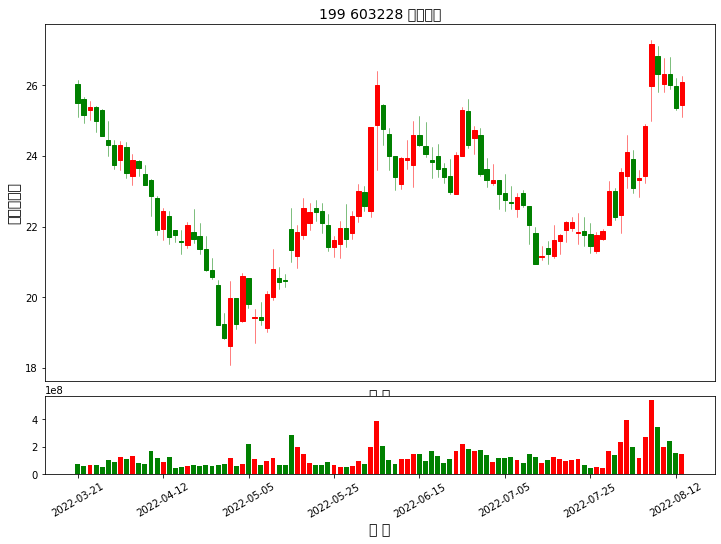

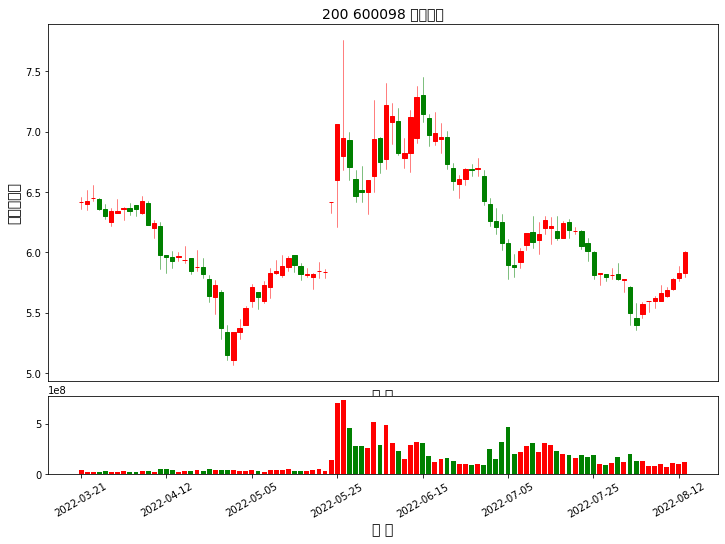

In [25]:
for i in range(1,11):
    start_idx = (i-1)*20
    status_code1, total, diff = request_all_code(i)
    if status_code1 != 200:
        print('request error', i)
    else:
        for infos in diff:
            start_idx += 1
            stock_code = infos['f12']
            name = infos['f14']
            status_code2, code, name, klines = get_klines(stock_code)
            if code.startswith('688'):
                continue
            if len(klines) <= 10:
                continue
            if status_code2 == 200:
                try:
                    print_klines(code, name, klines, start_idx)
                except:
                    print(str(start_idx)+' '+str(code)+' '+name, len(klines))
            else:
                print('request error', stock_code+' '+name)

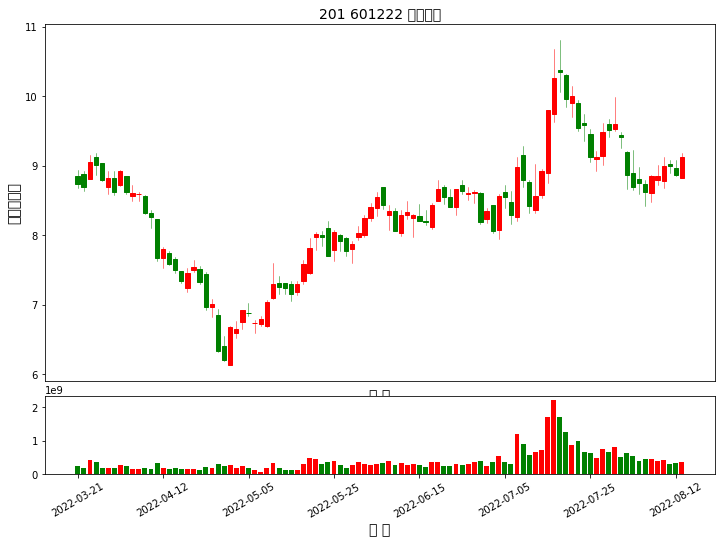

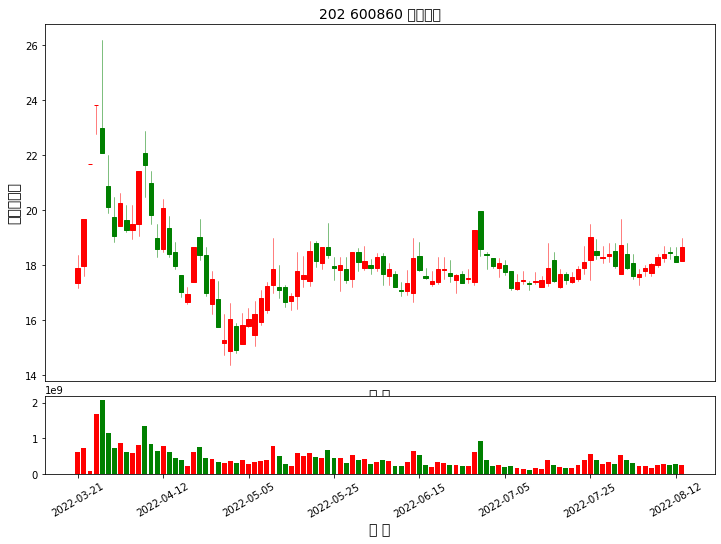

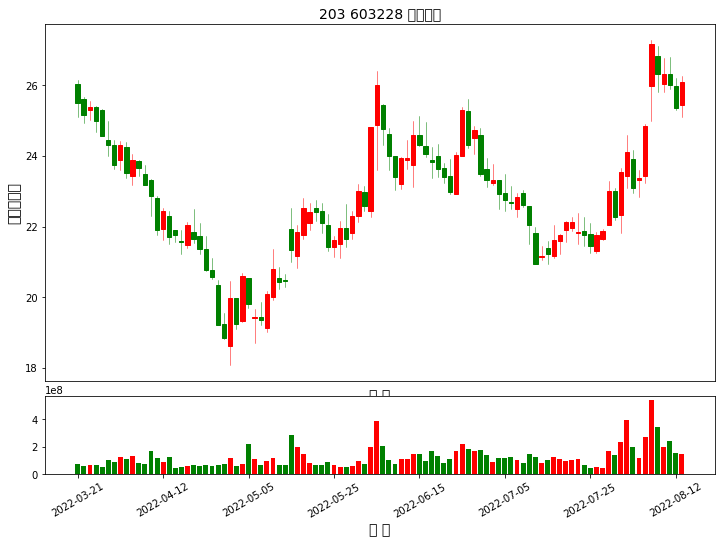

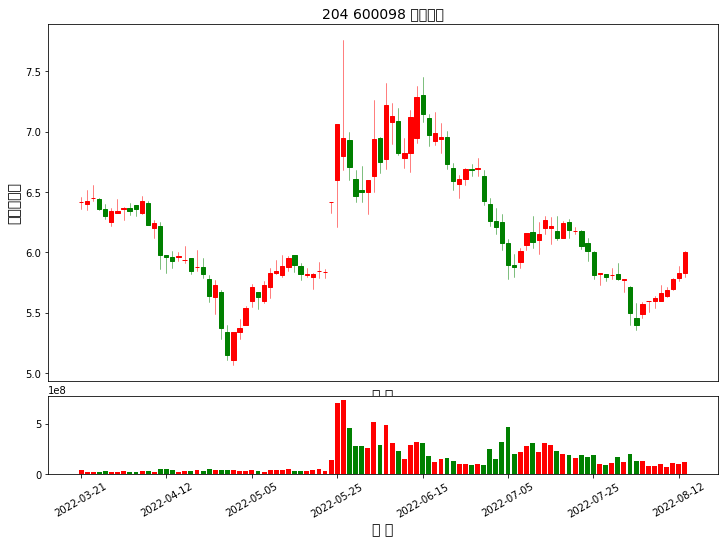

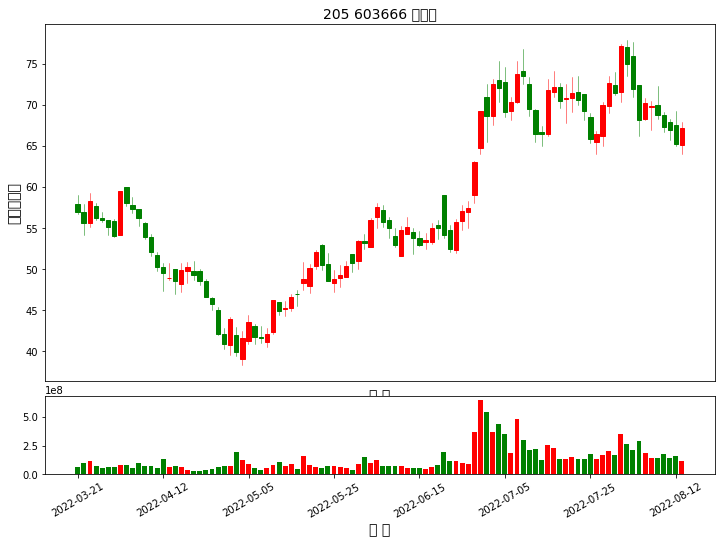

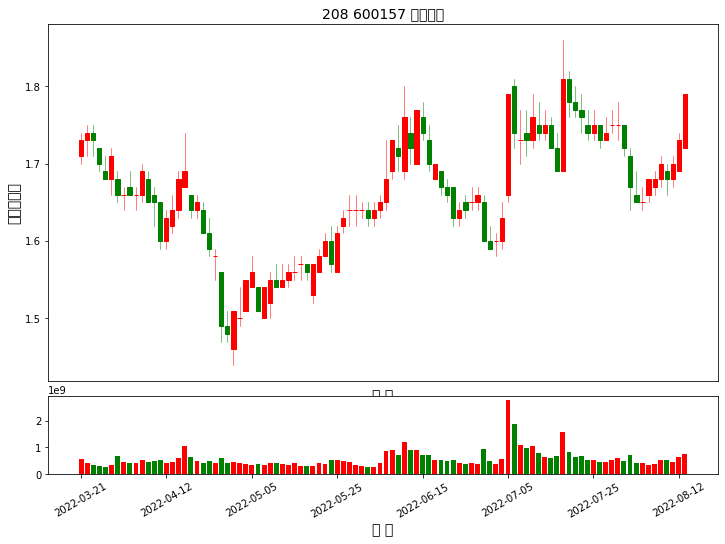

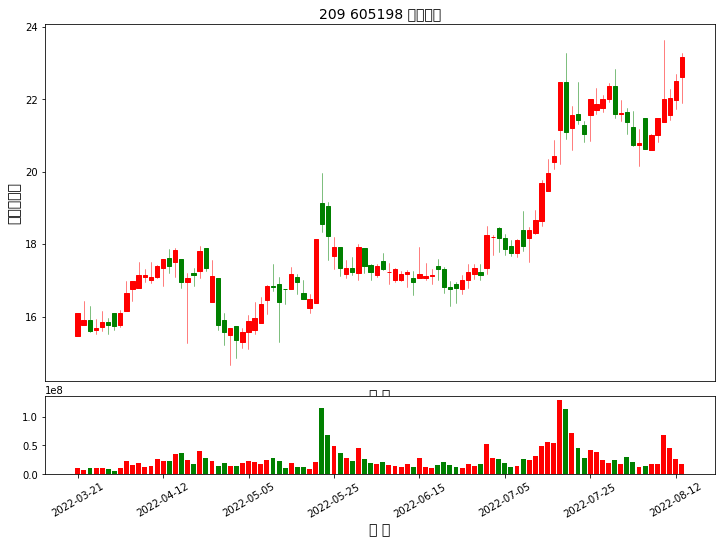

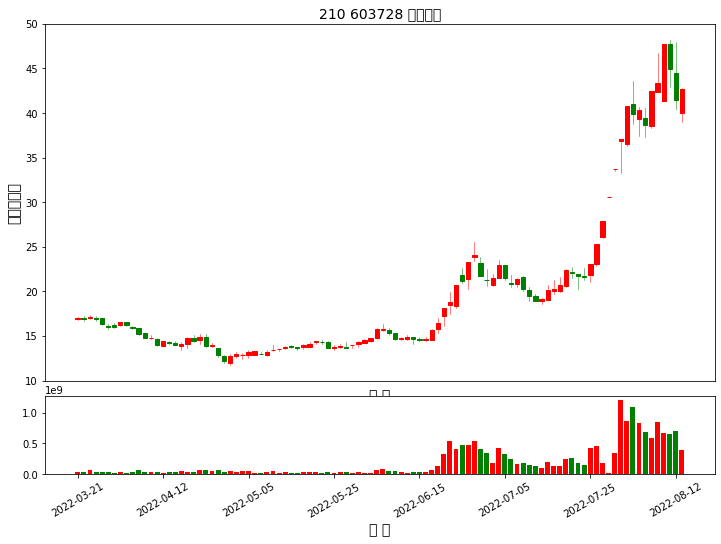

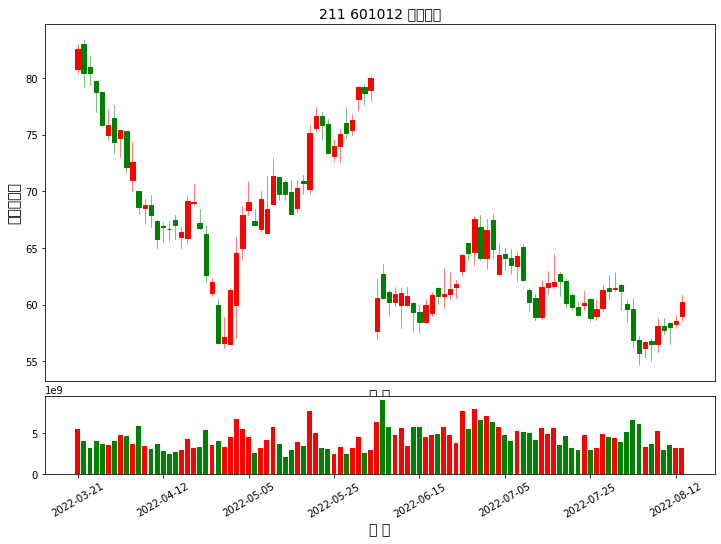

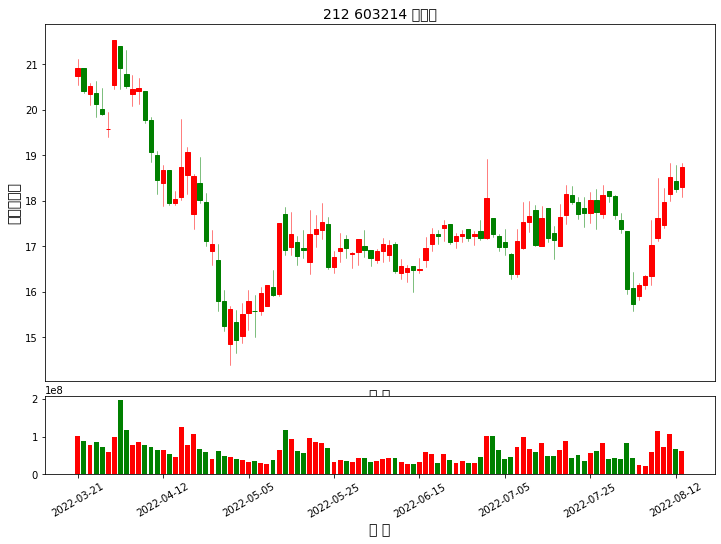

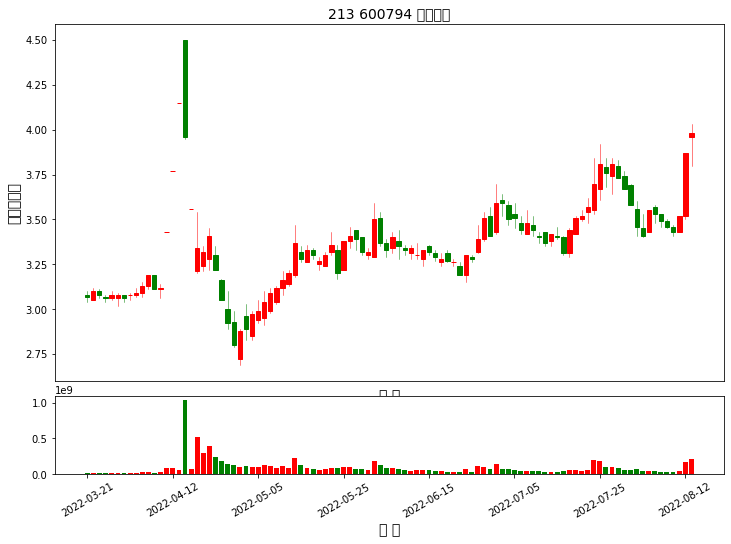

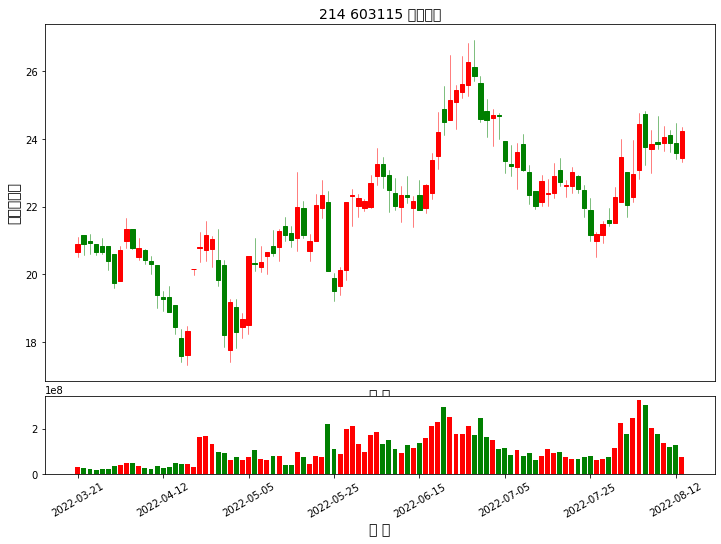

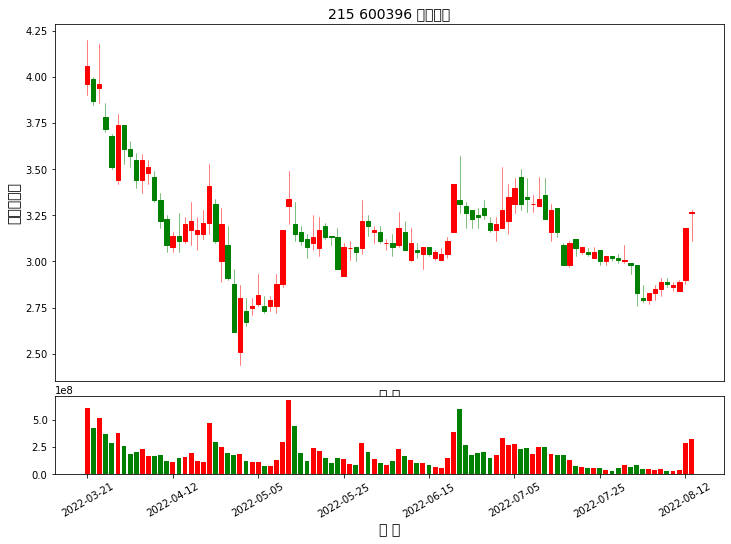

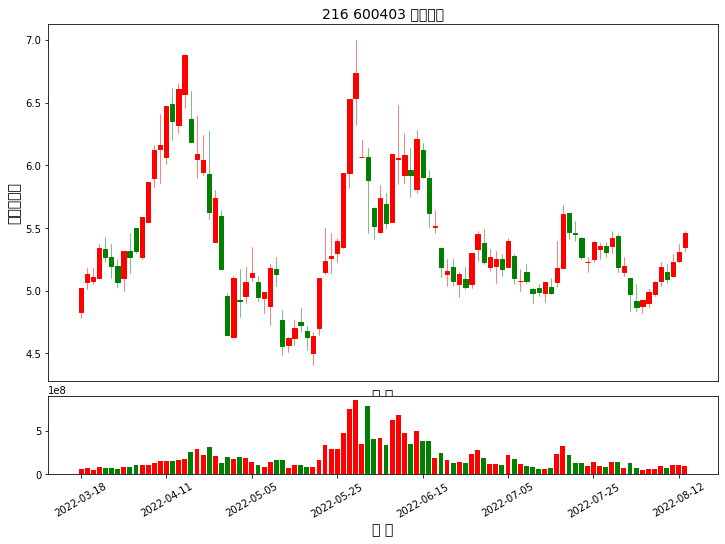

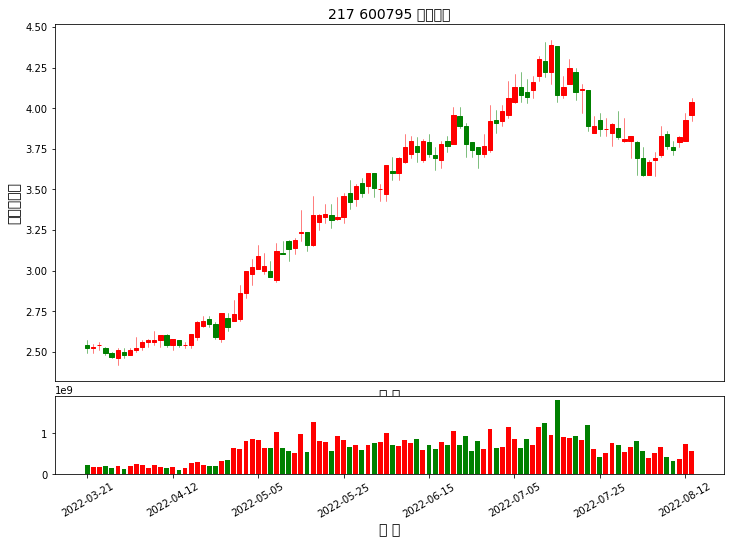

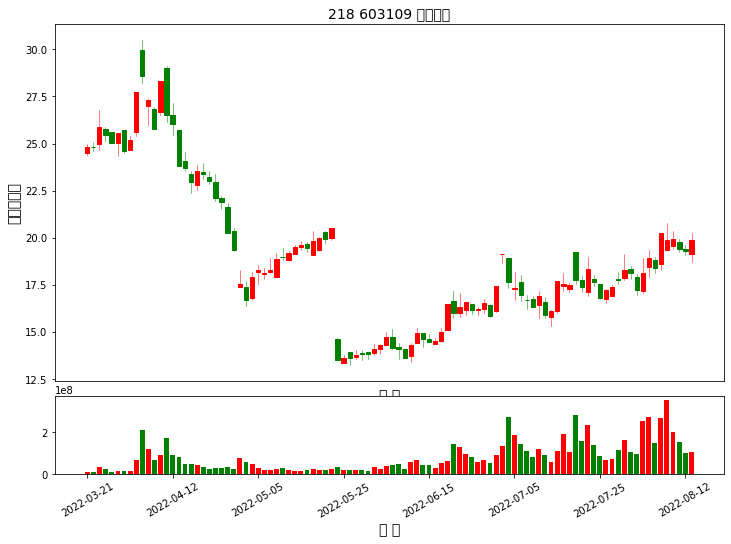

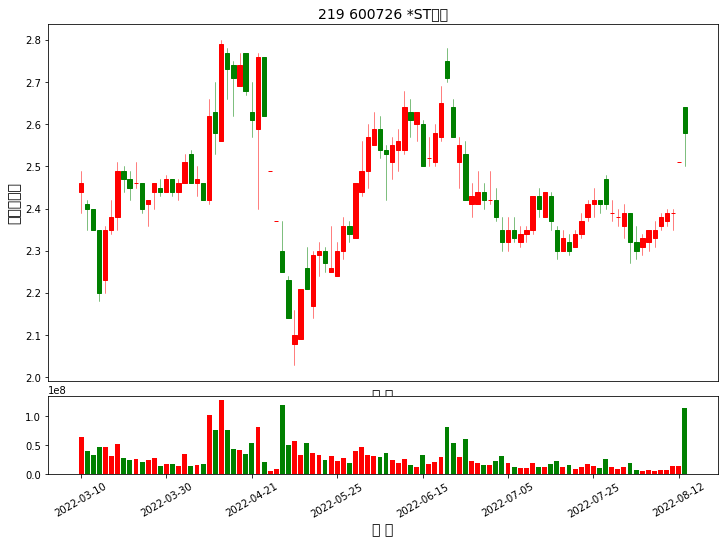

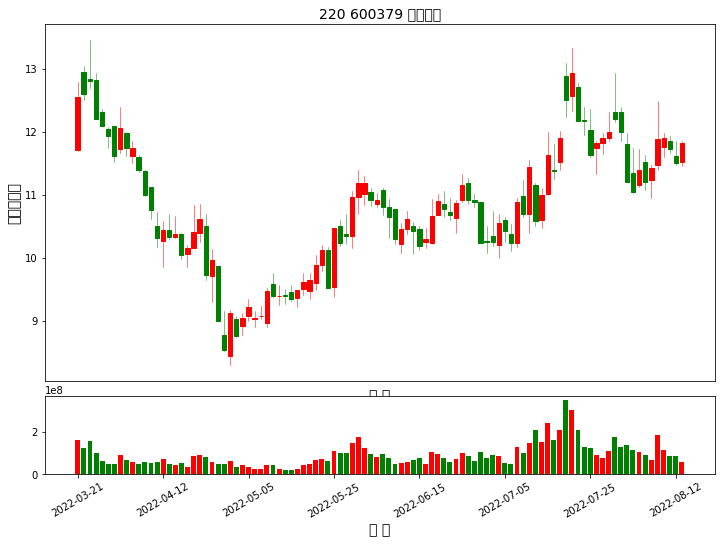

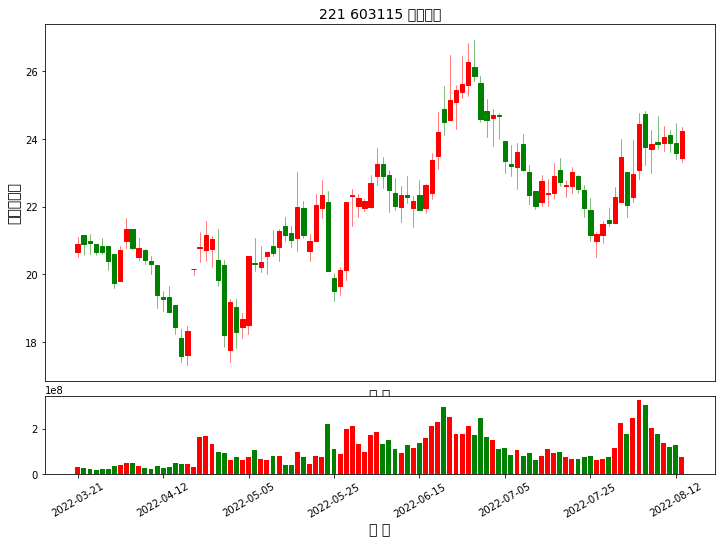

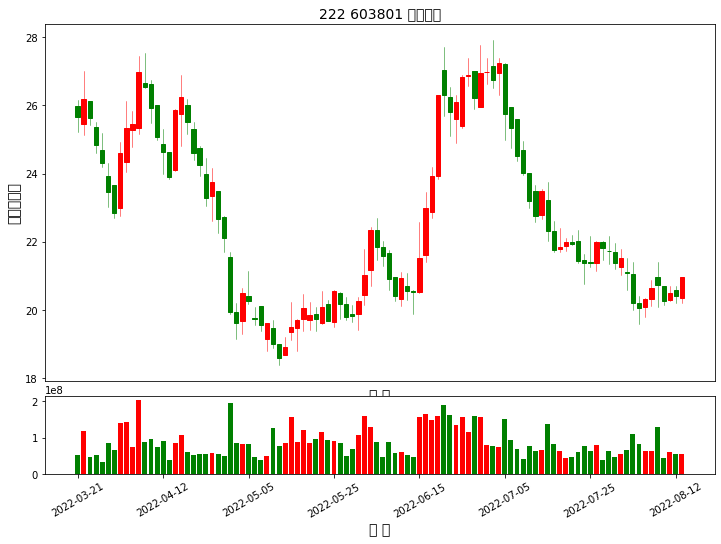

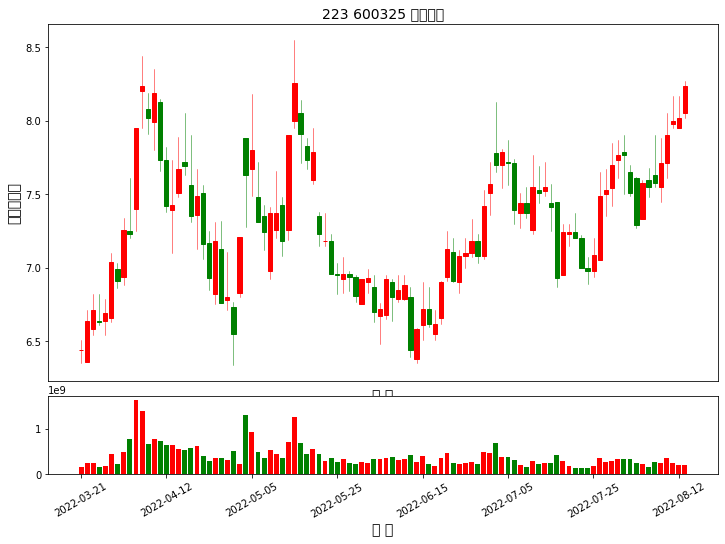

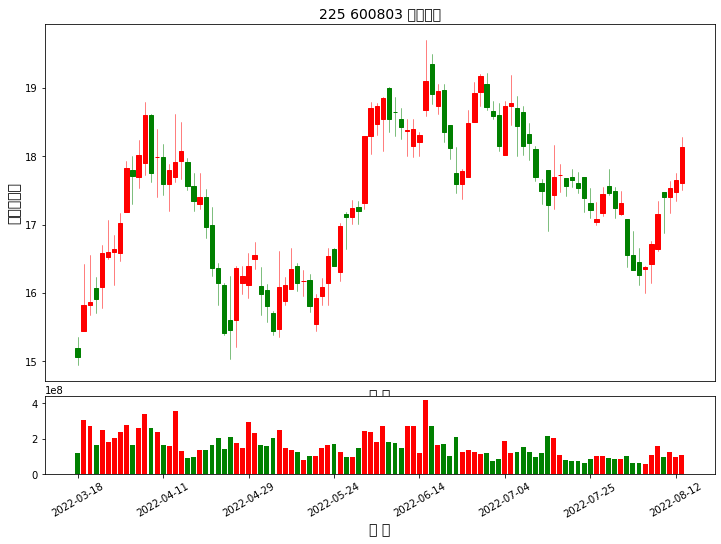

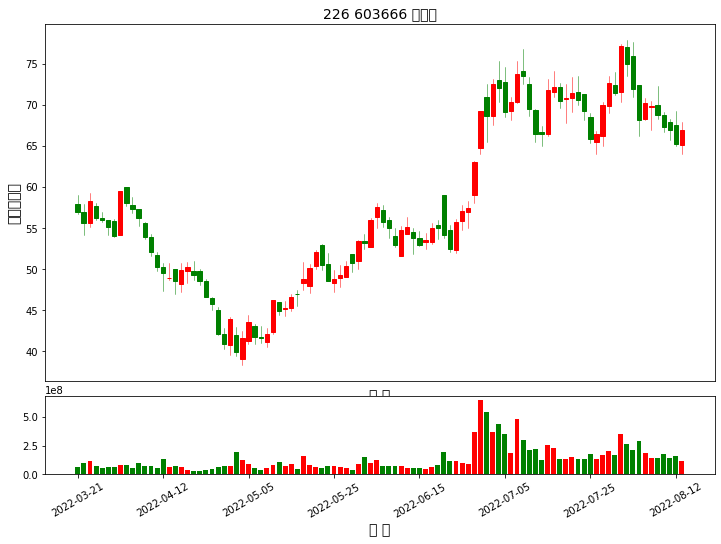

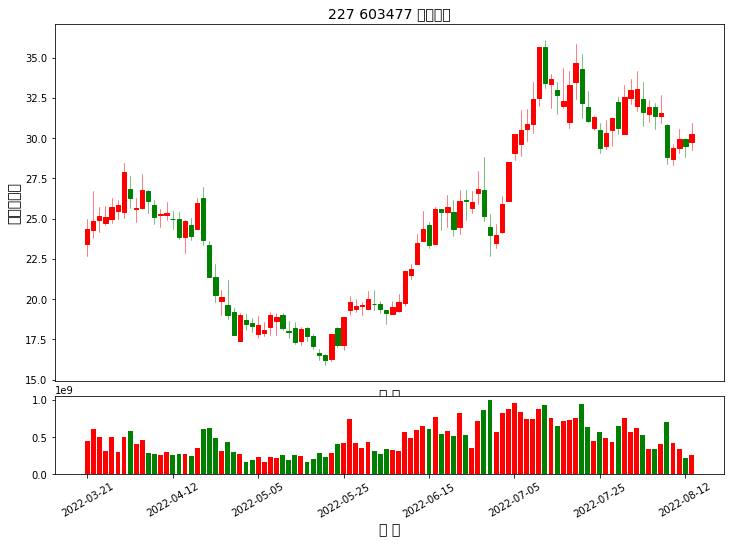

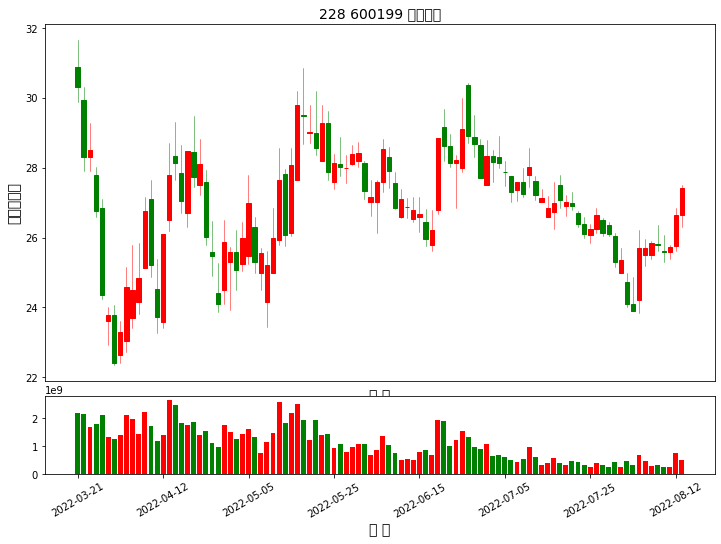

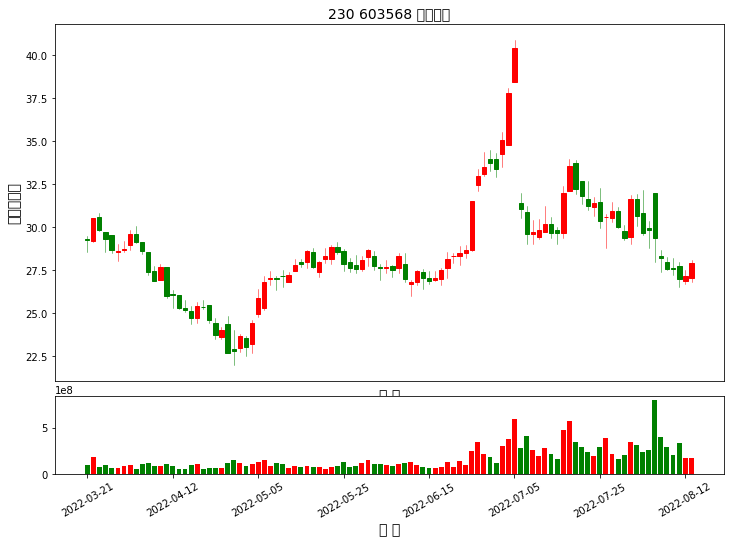

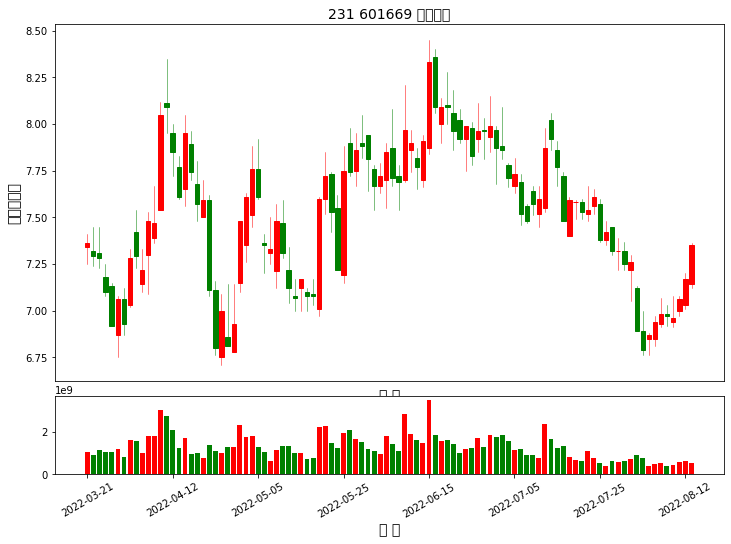

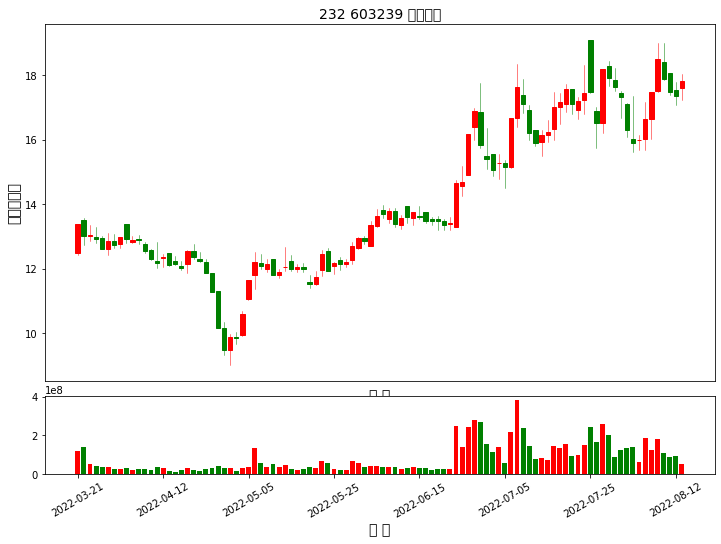

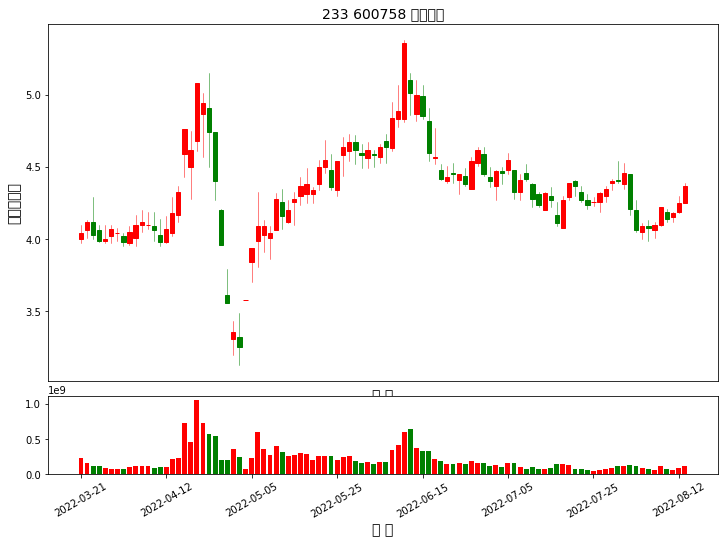

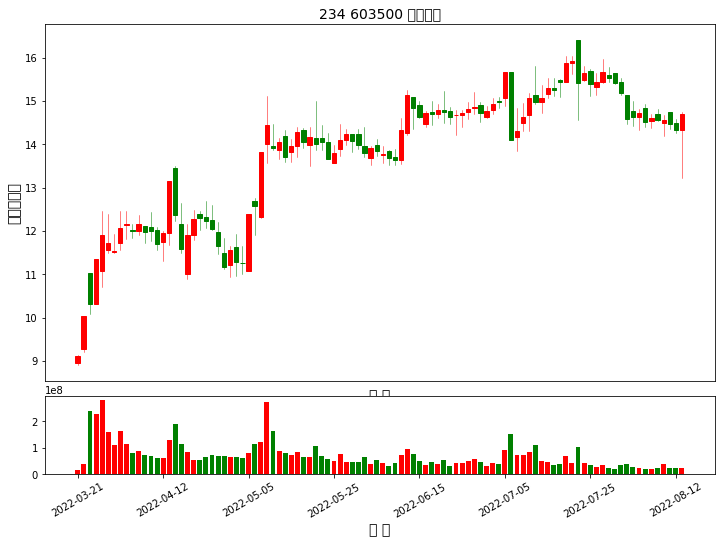

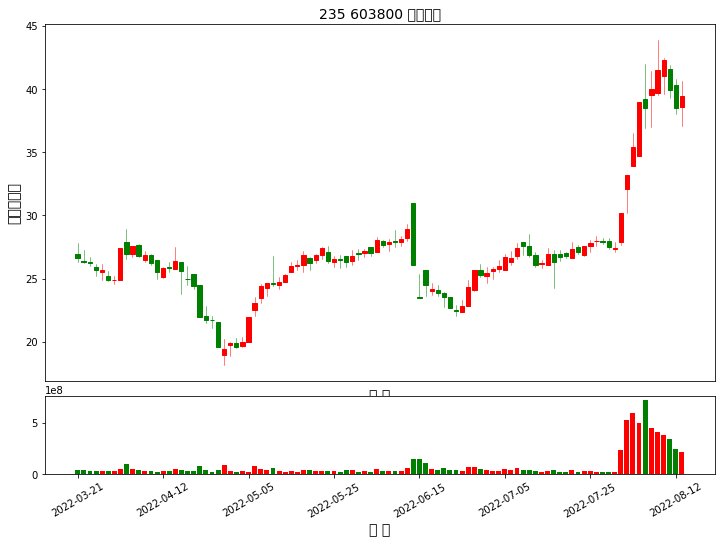

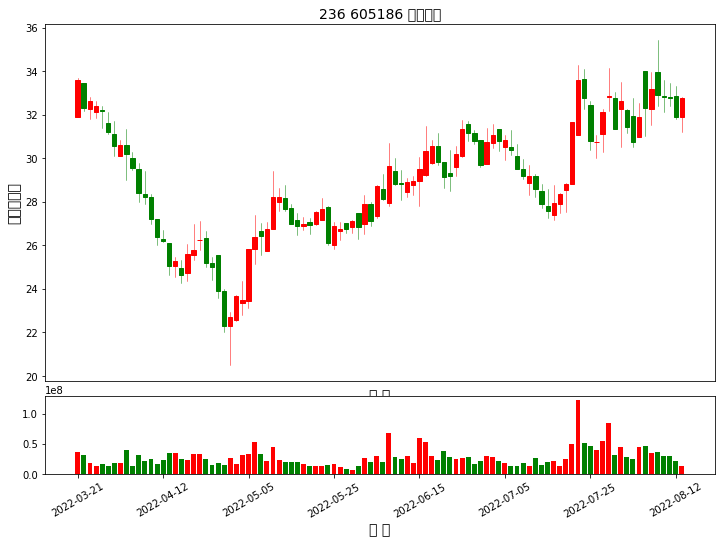

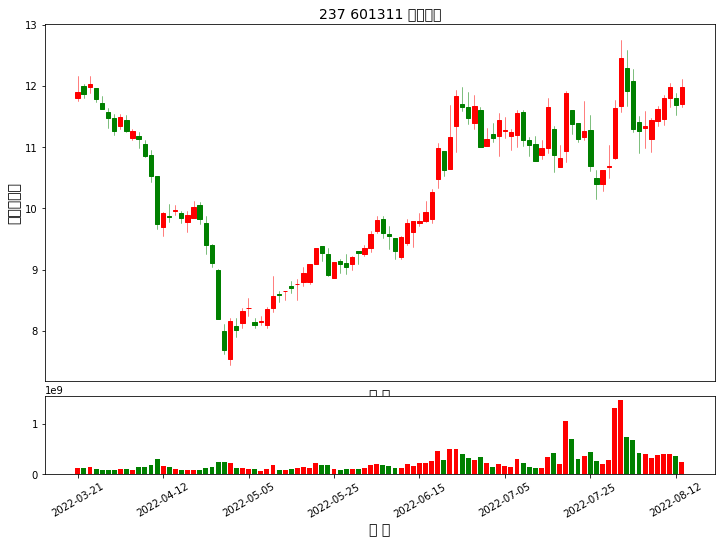

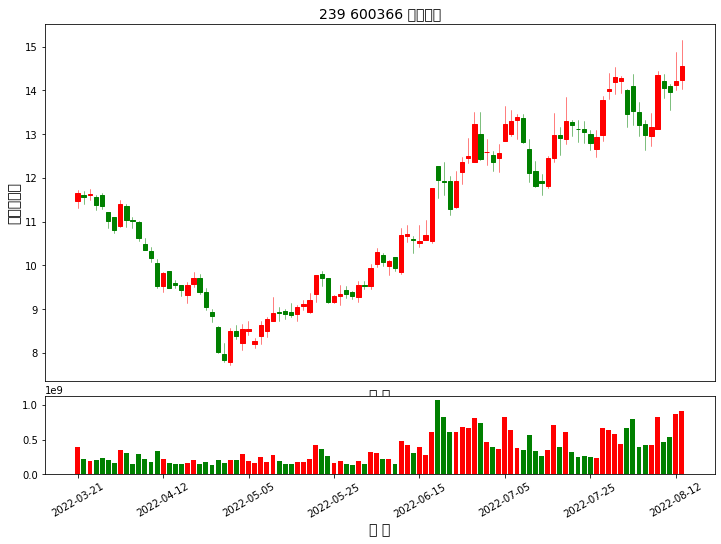

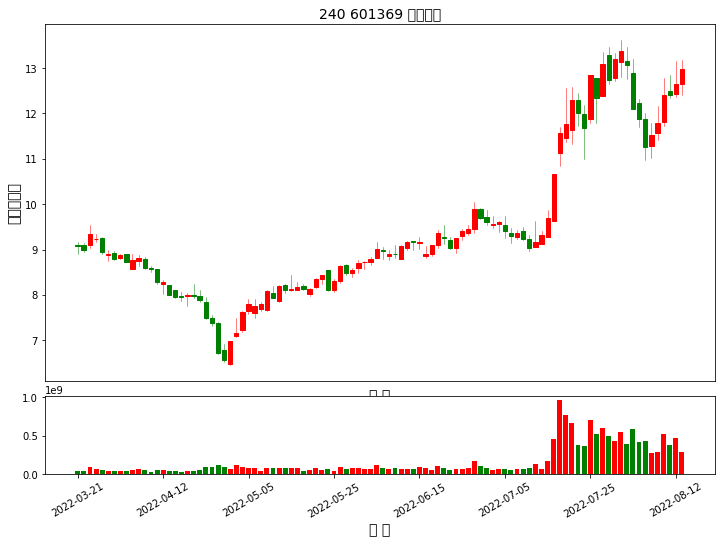

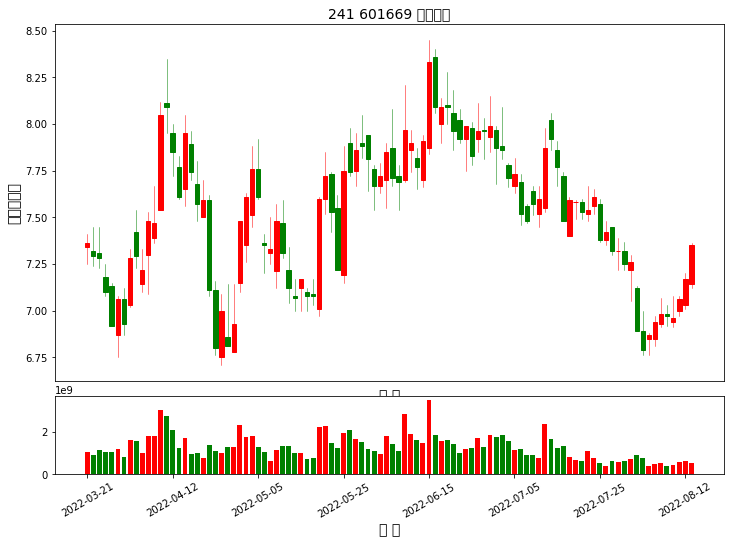

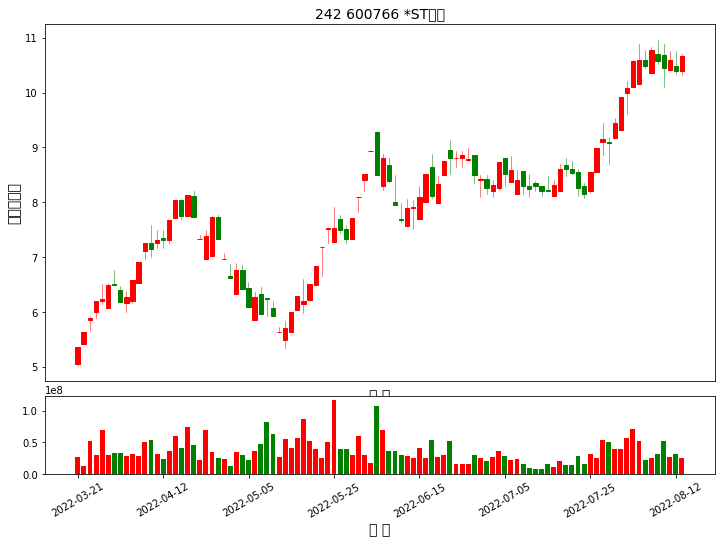

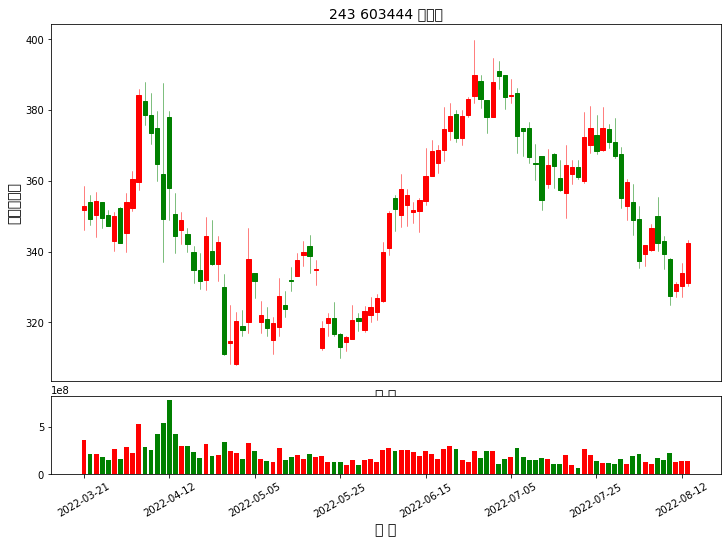

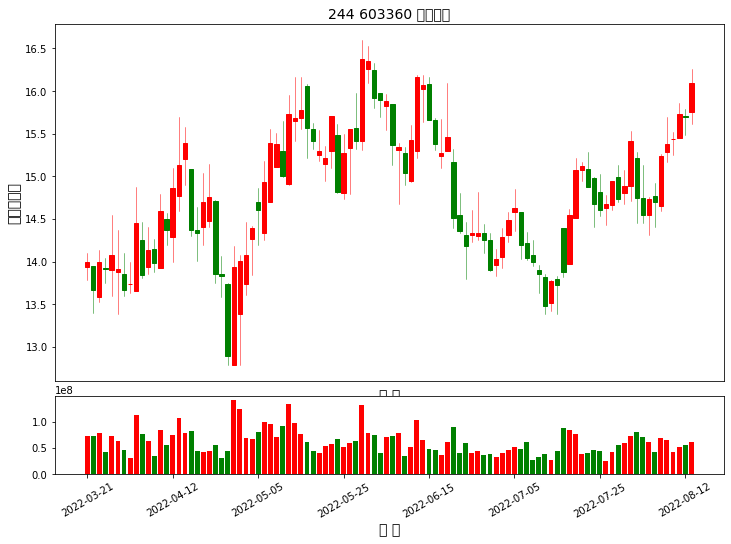

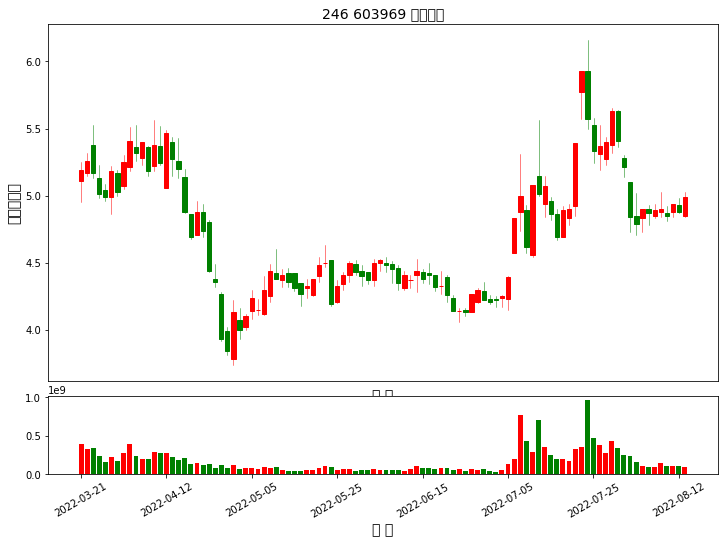

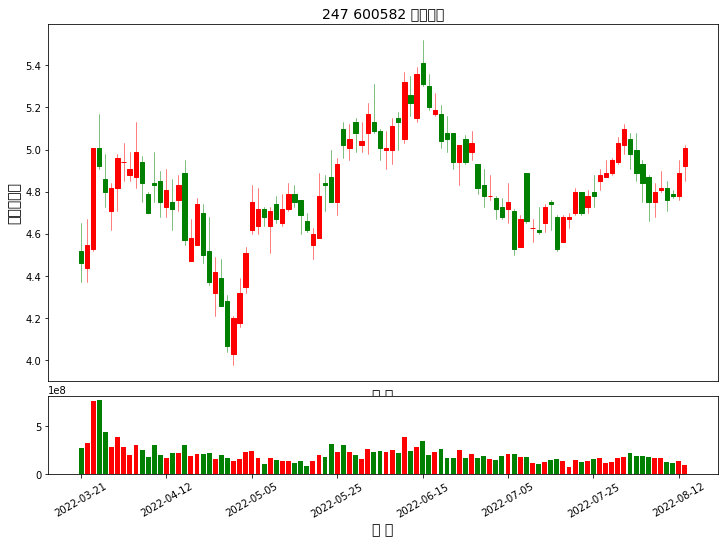

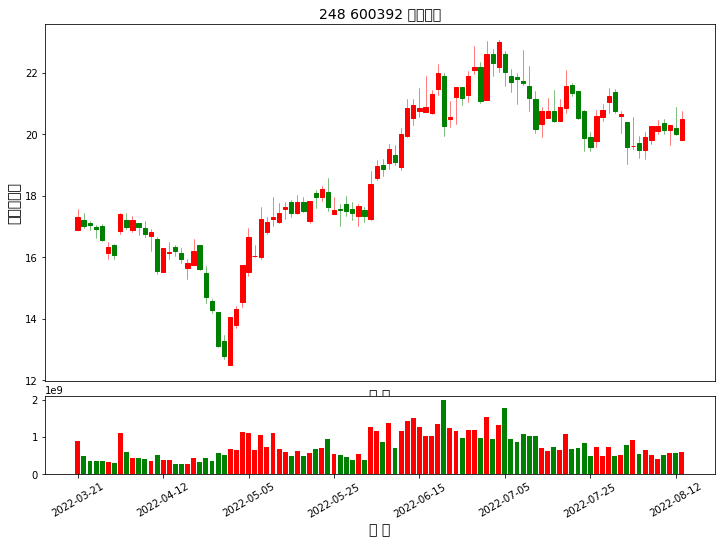

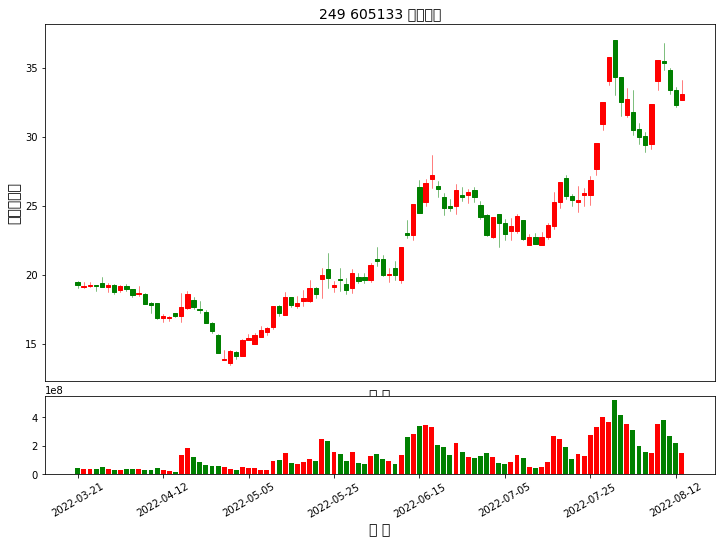

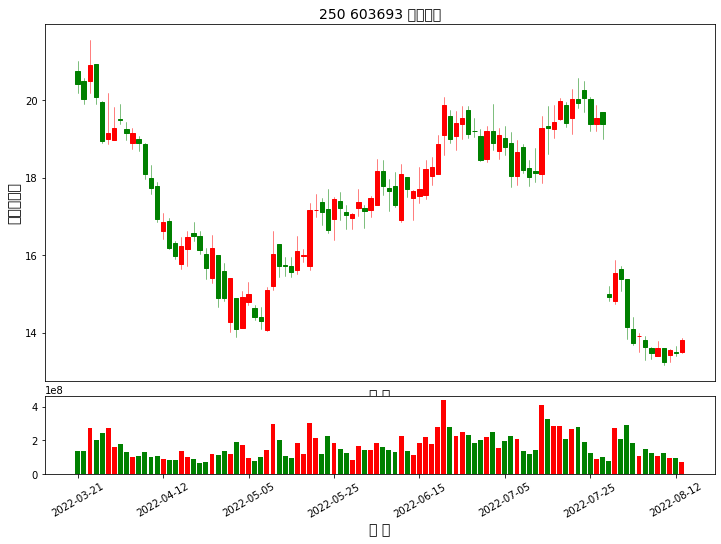

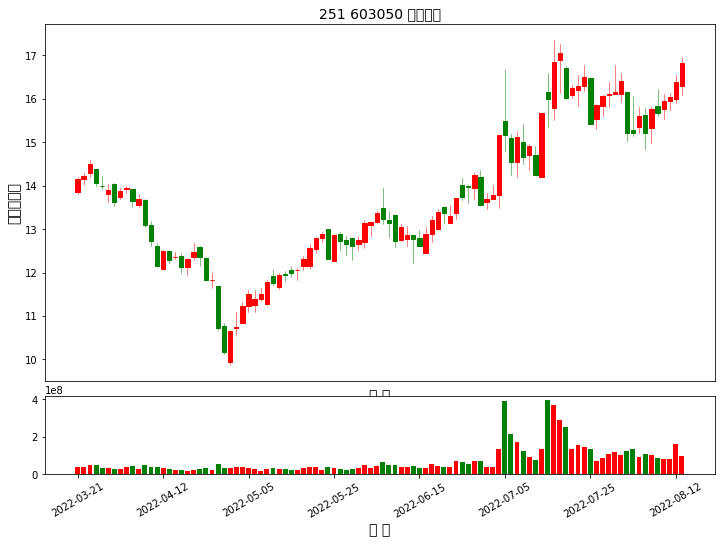

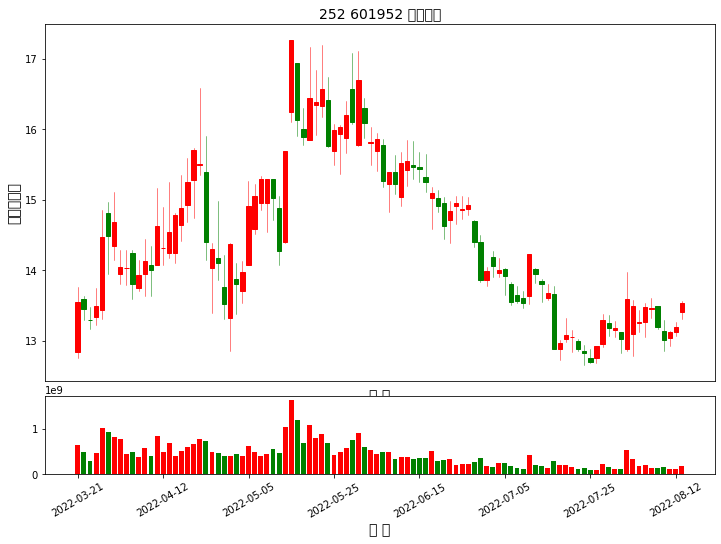

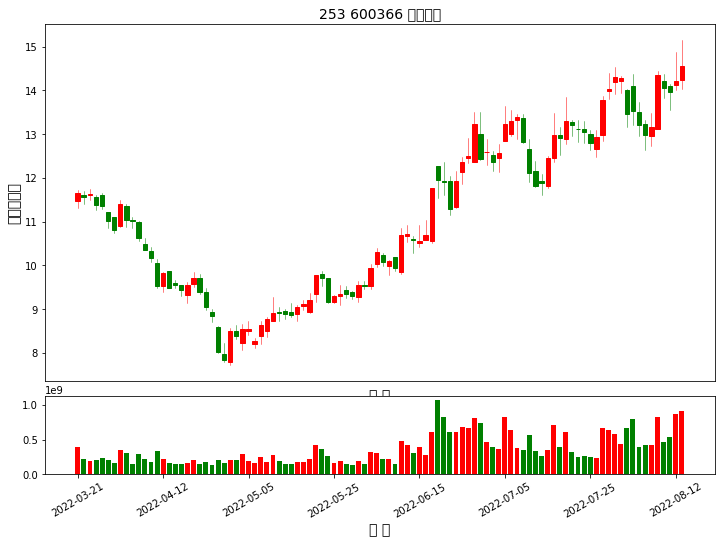

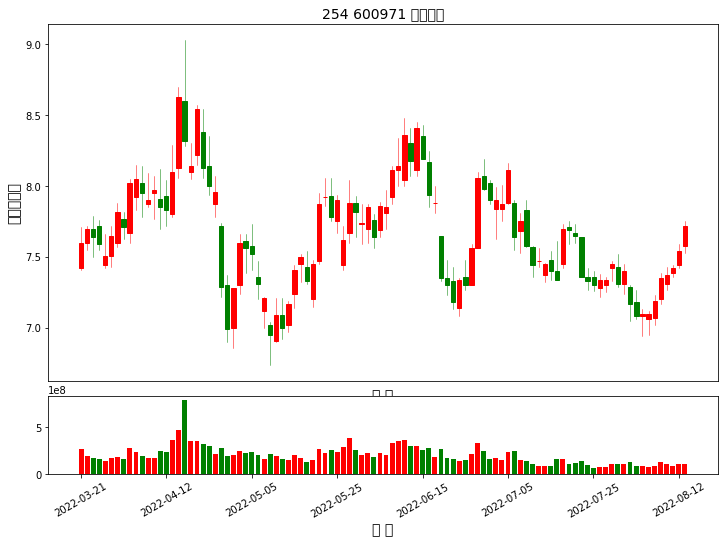

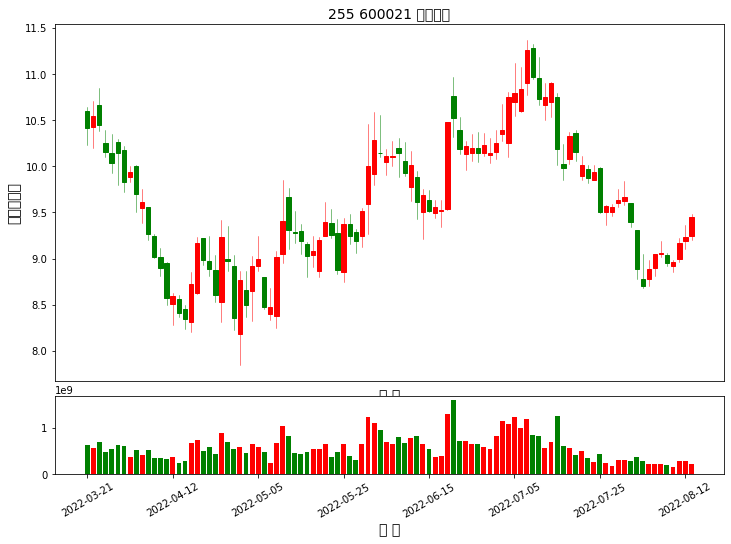

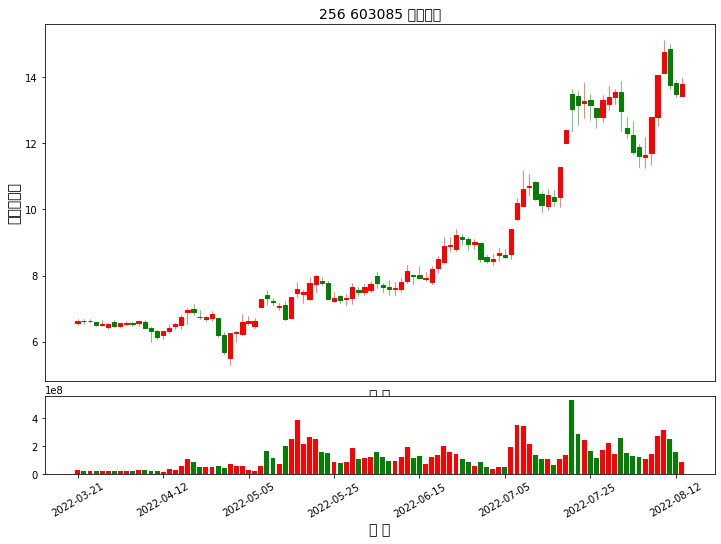

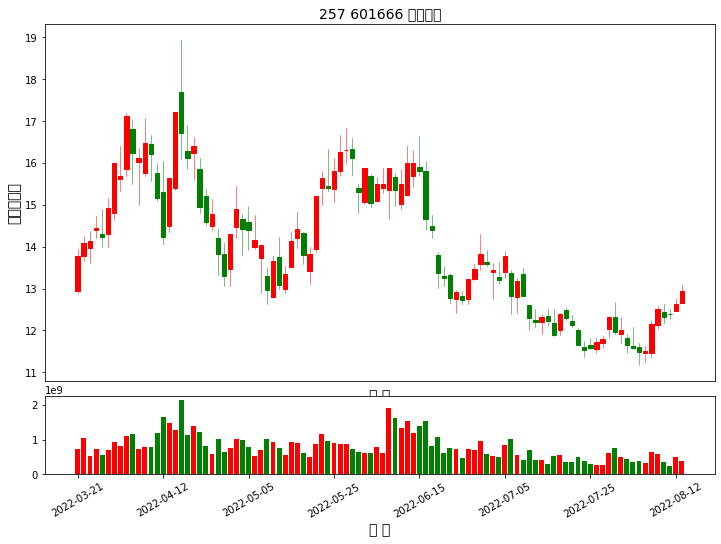

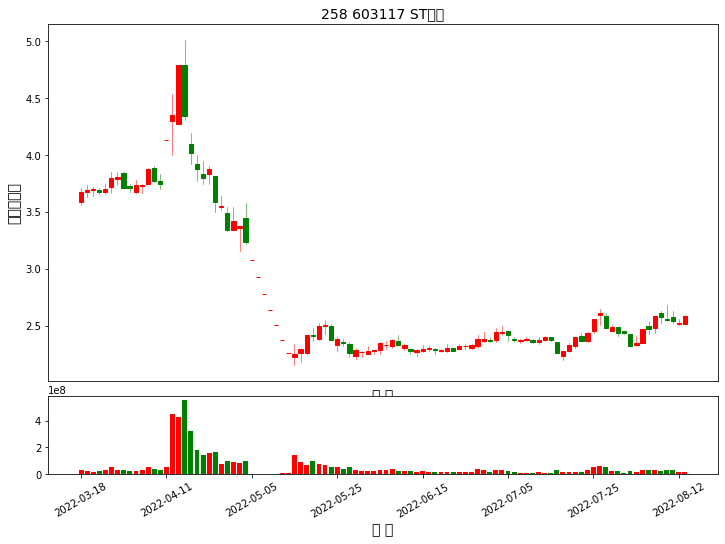

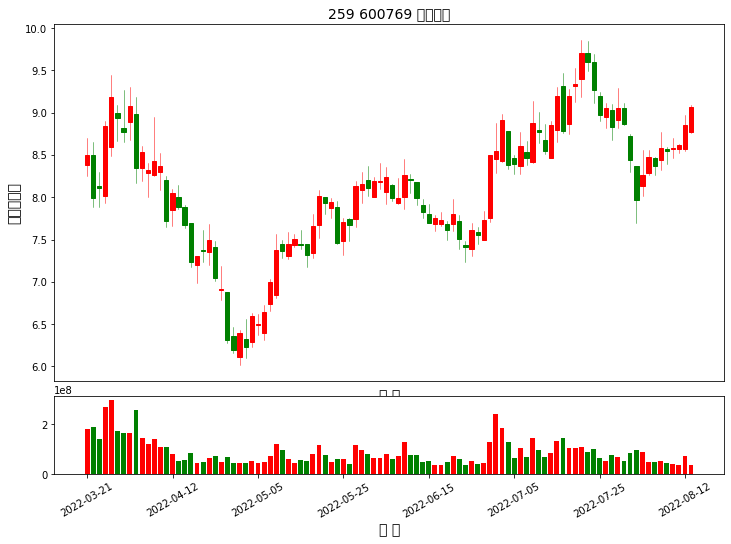

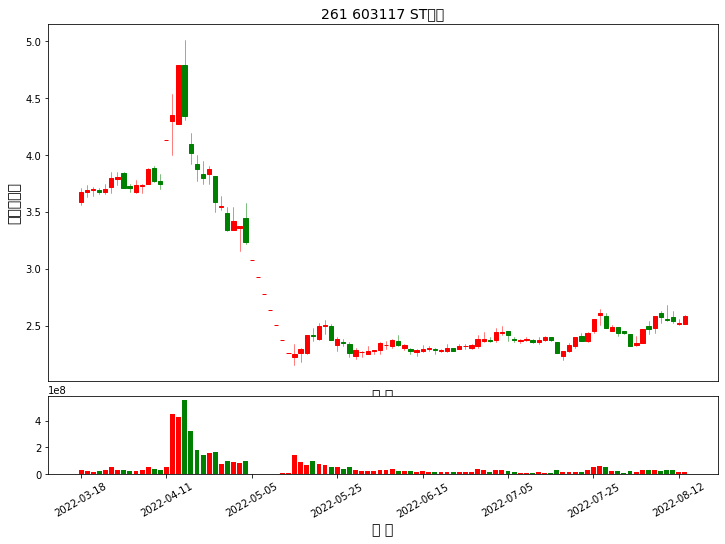

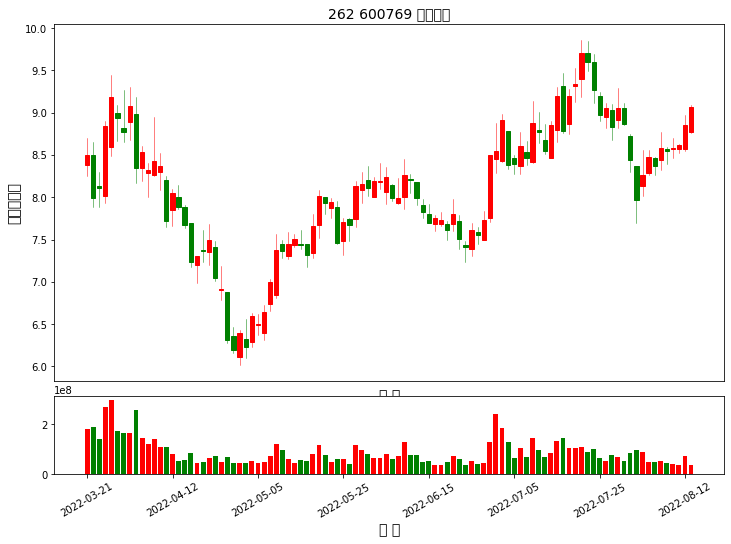

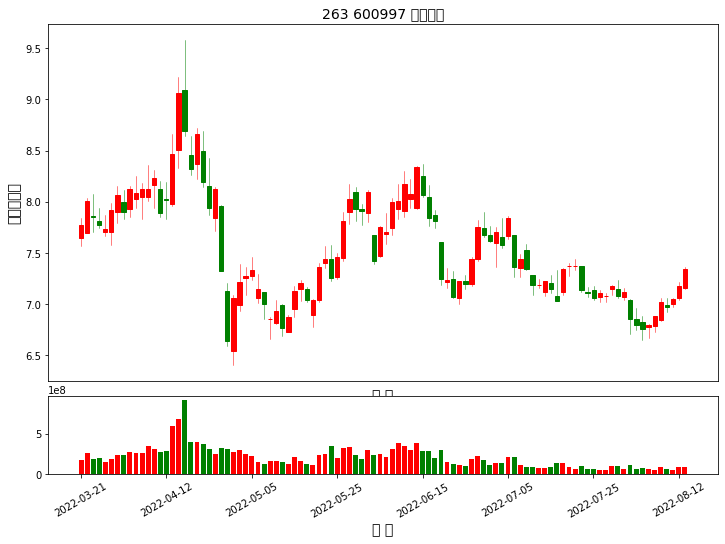

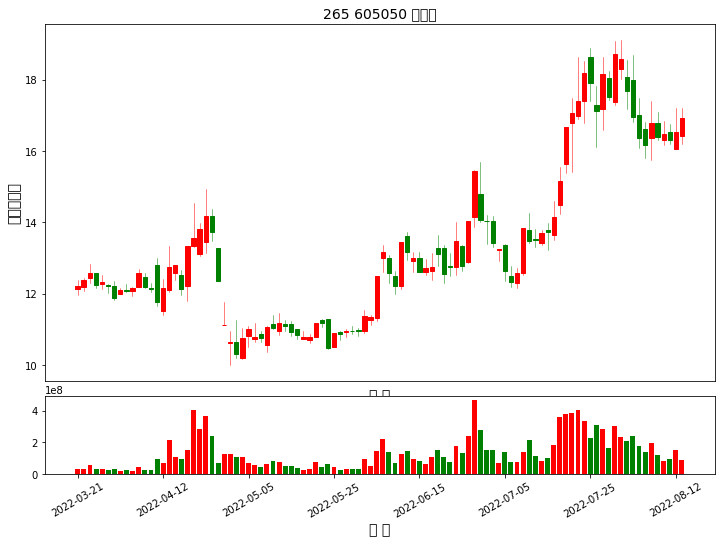

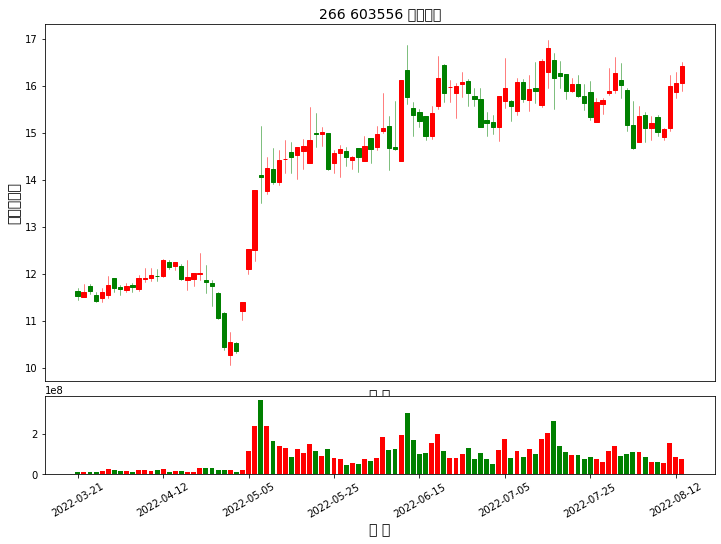

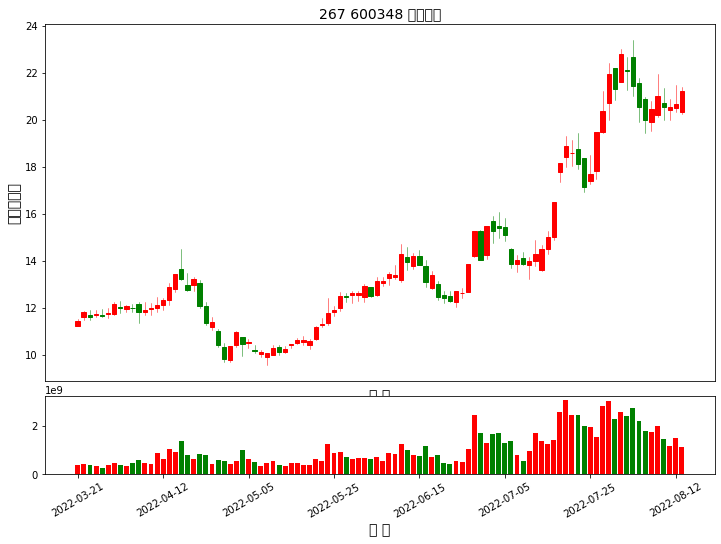

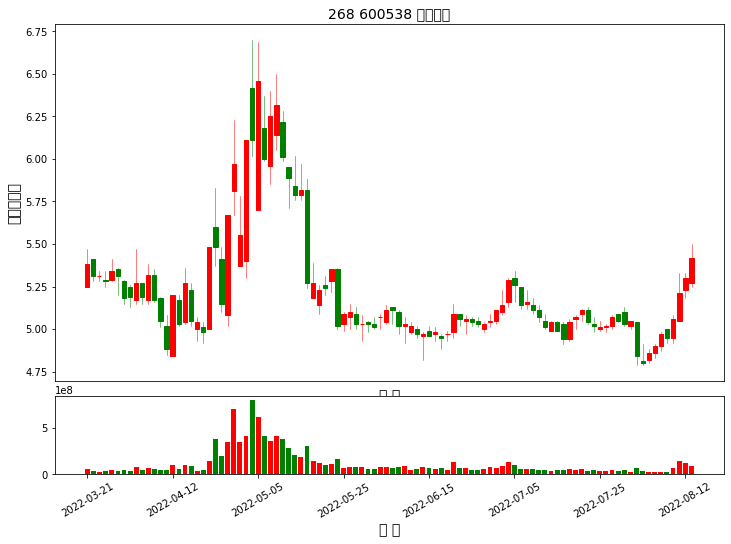

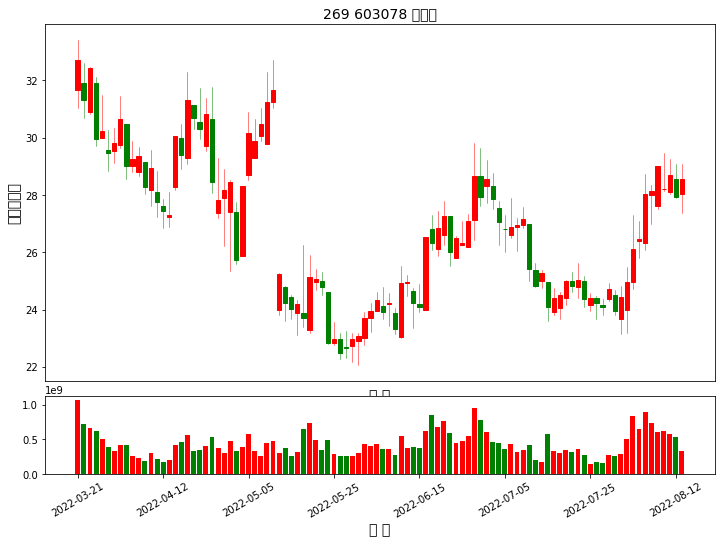

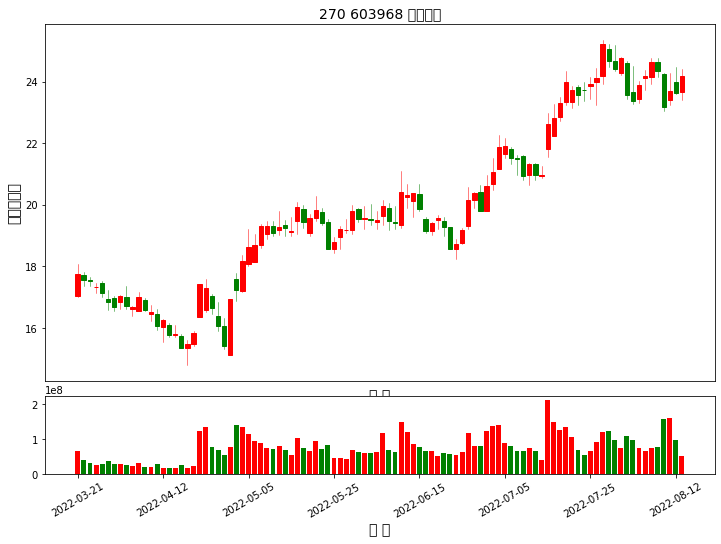

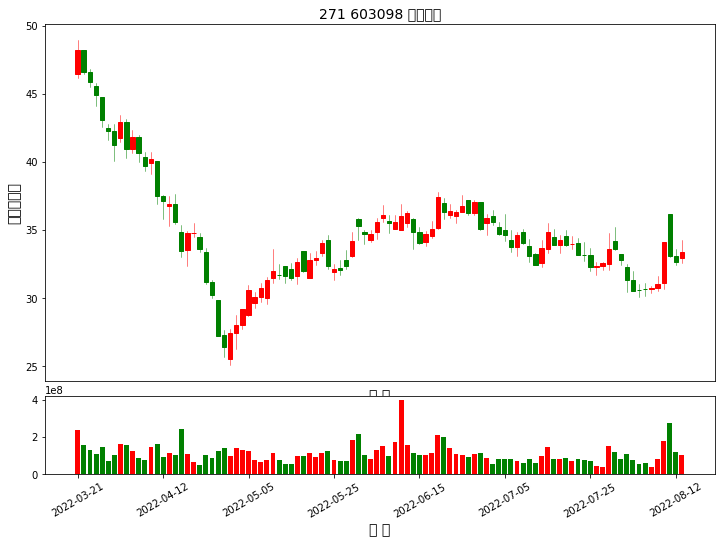

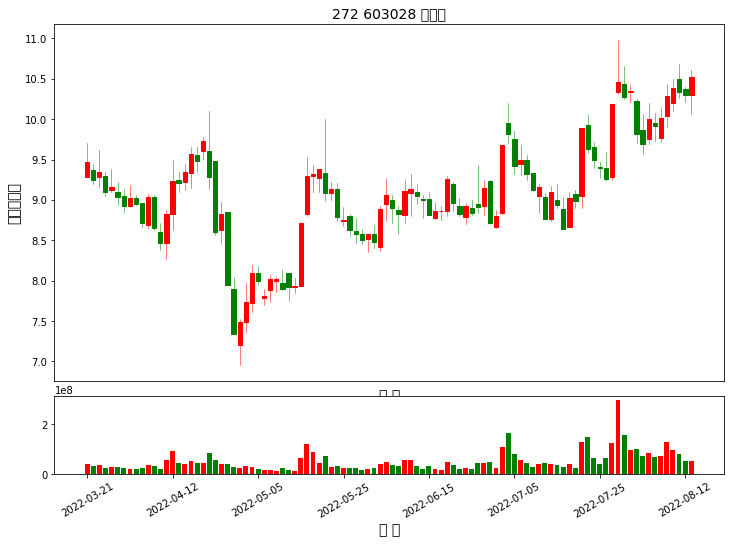

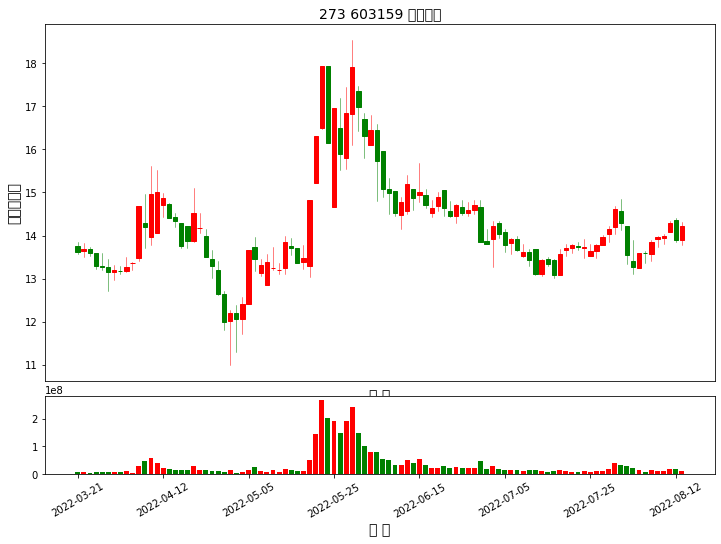

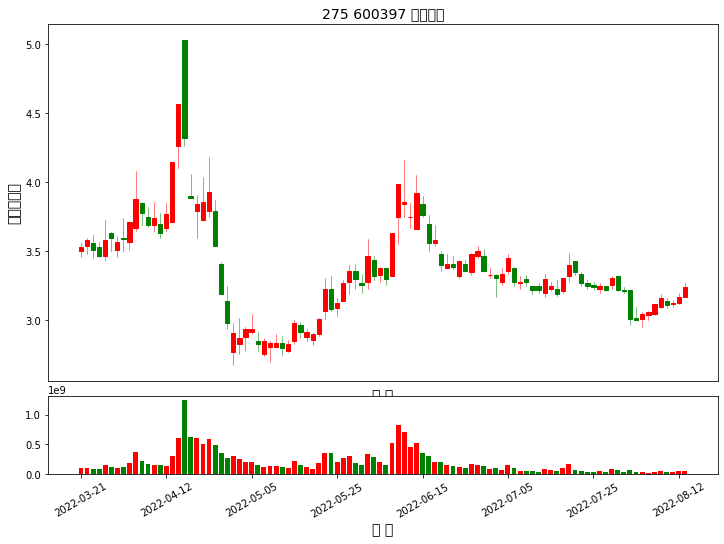

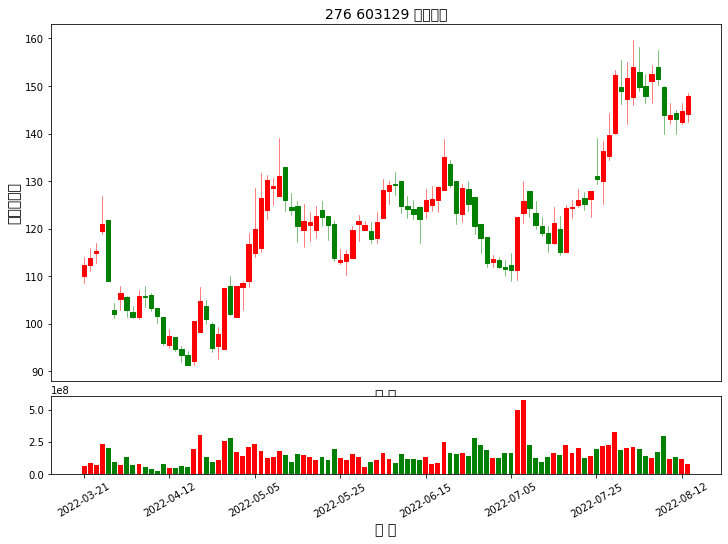

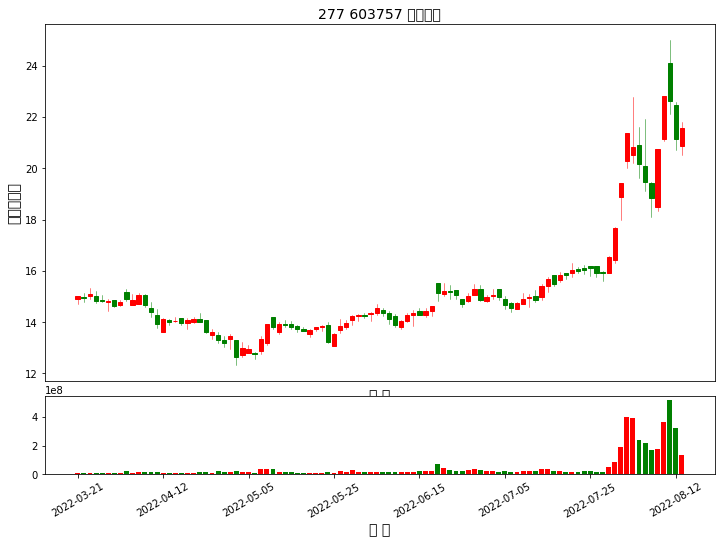

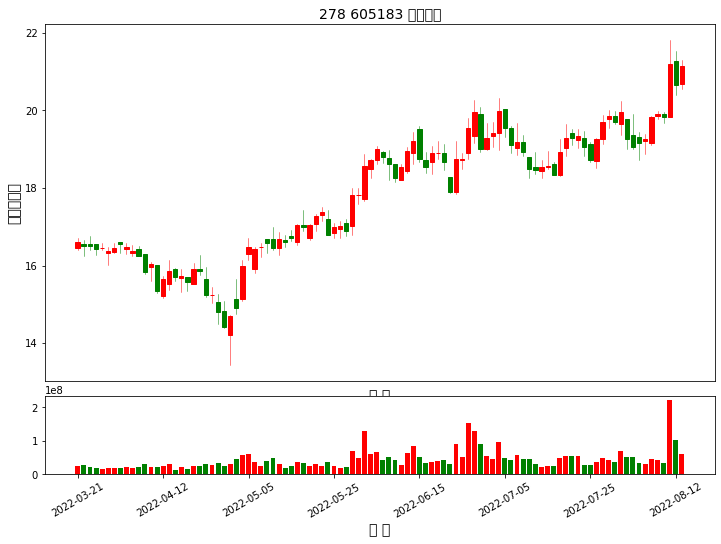

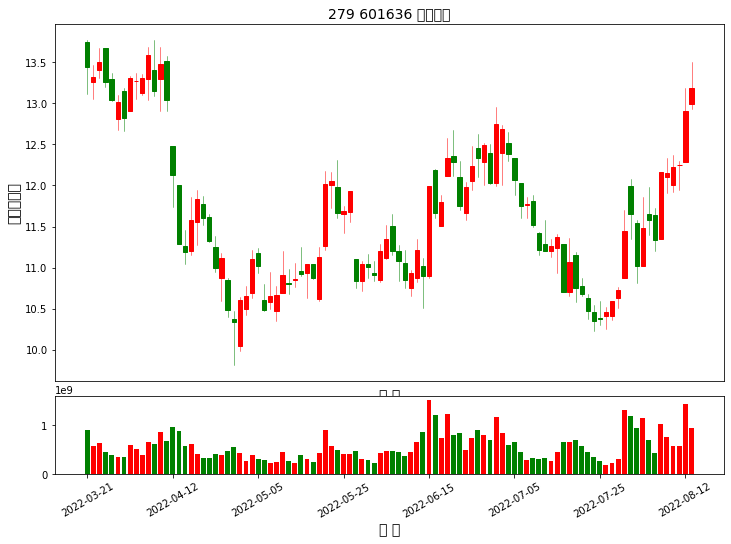

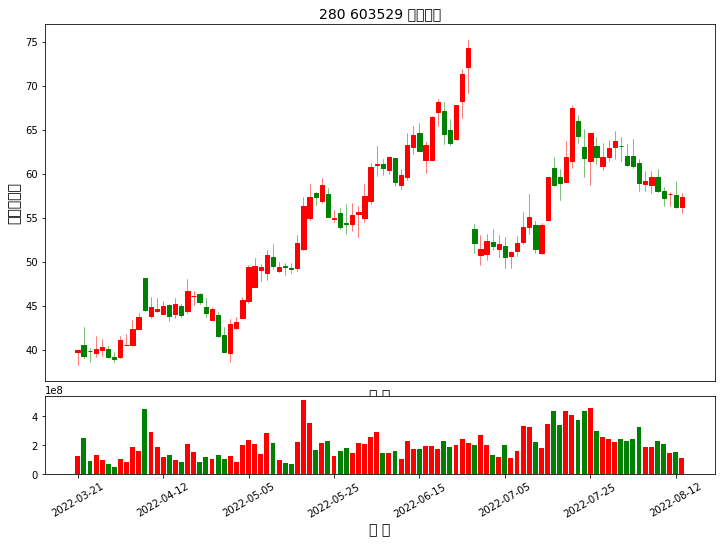

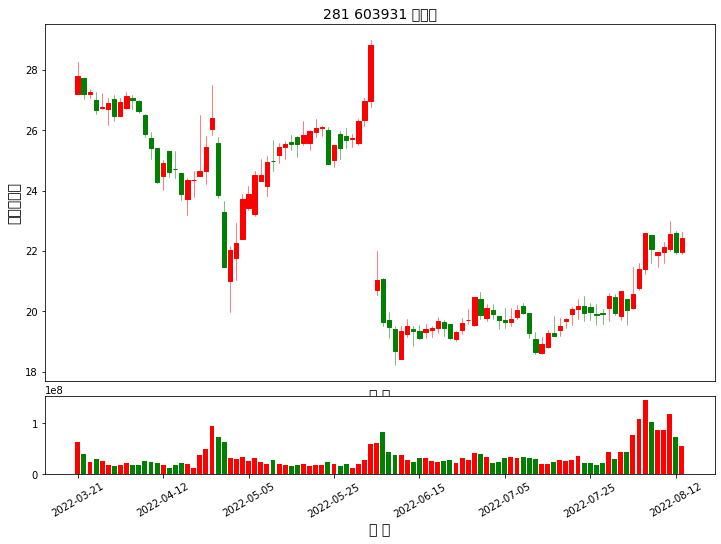

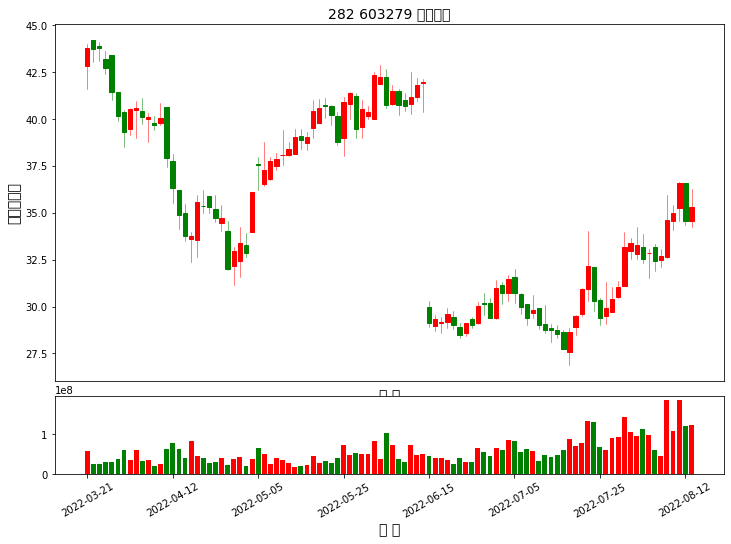

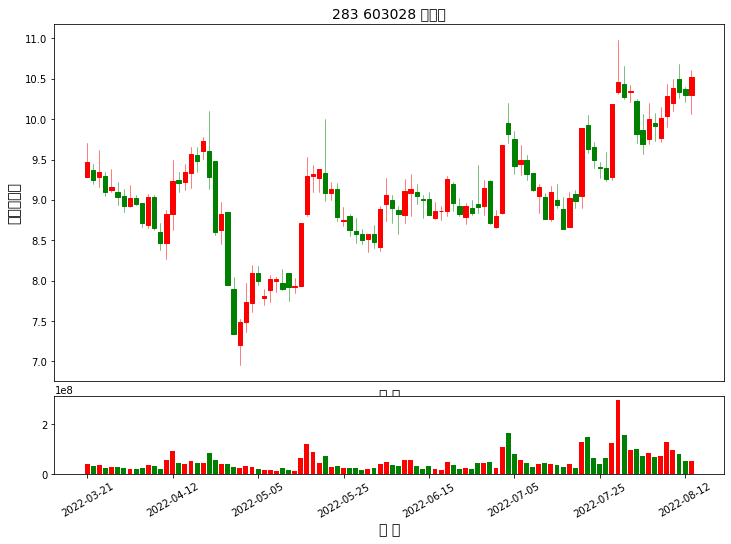

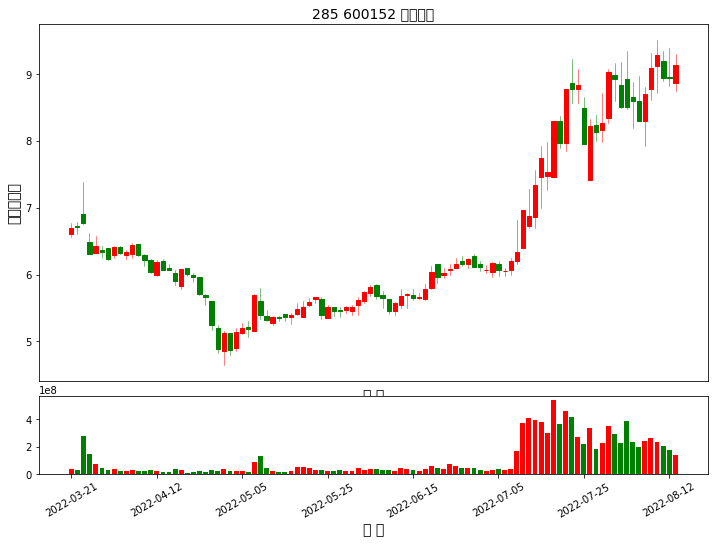

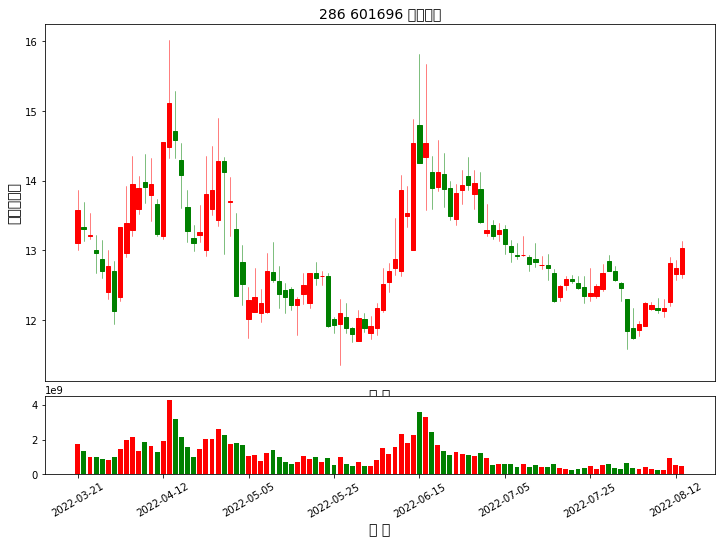

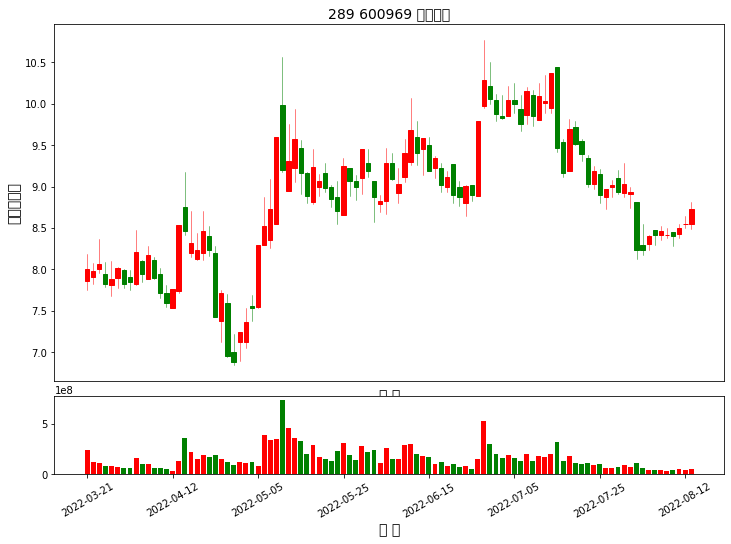

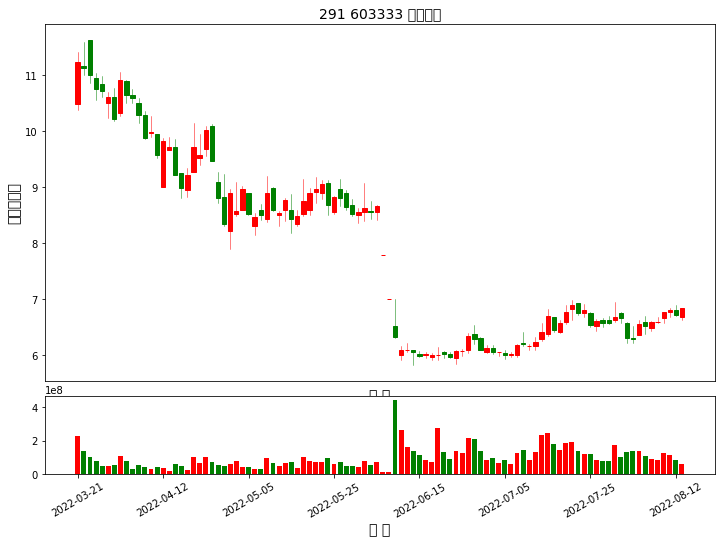

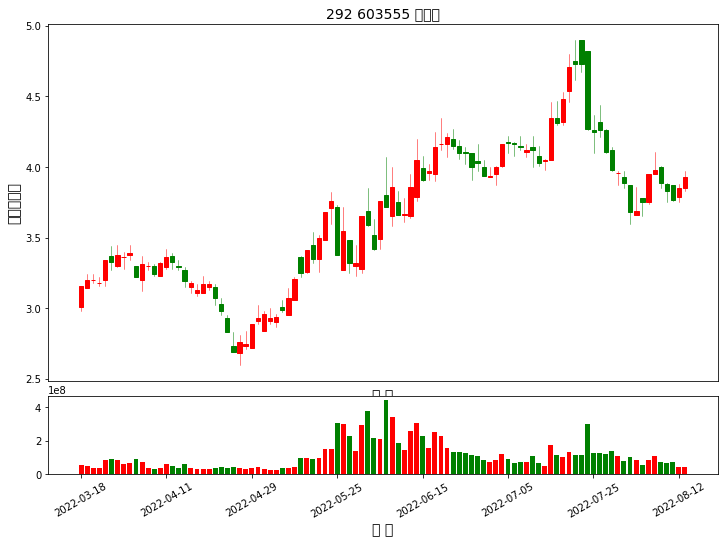

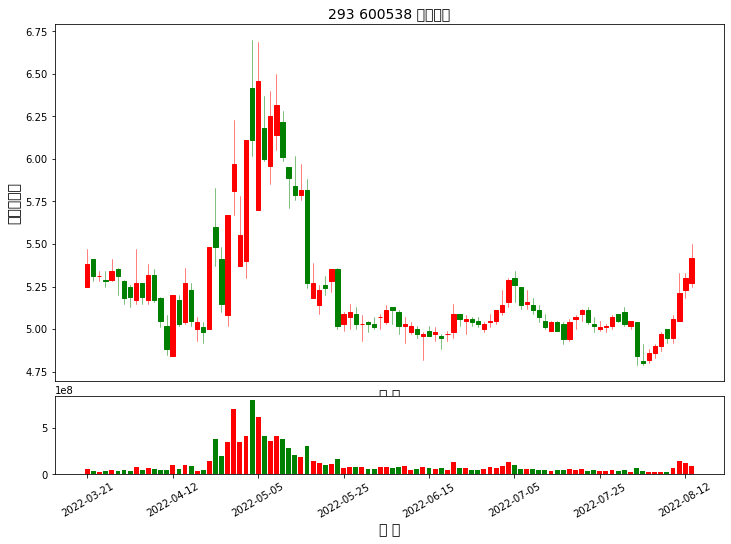

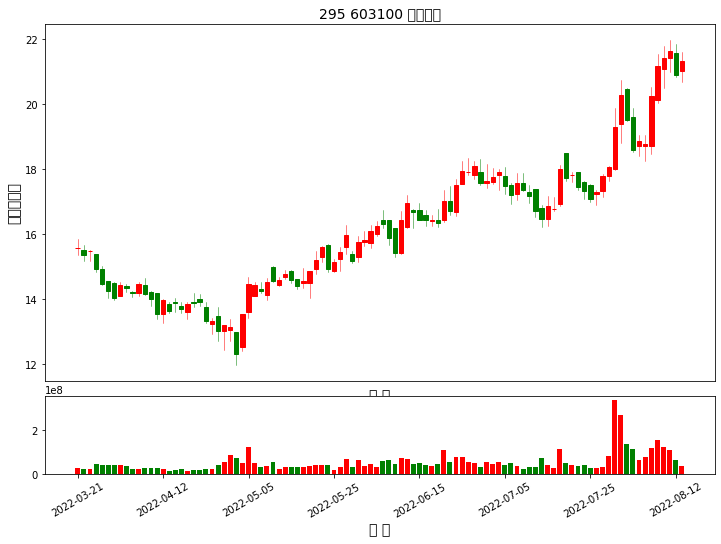

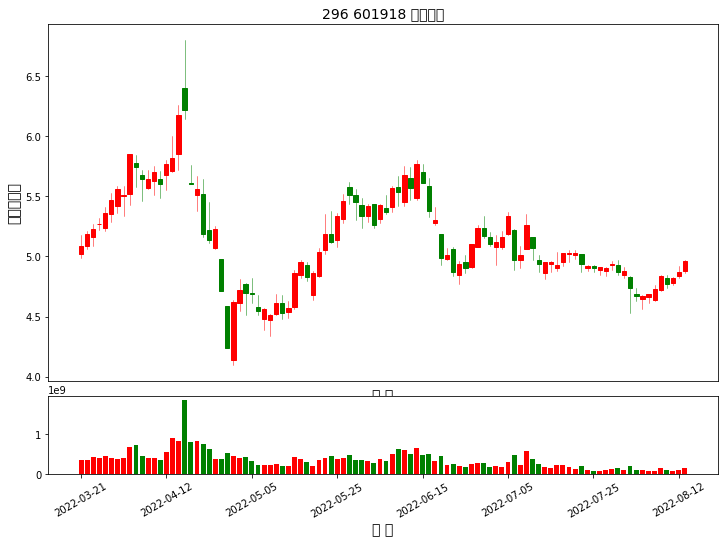

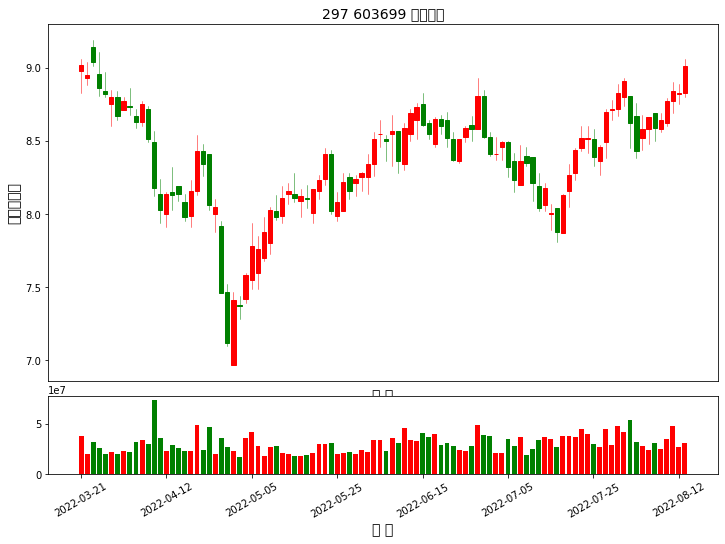

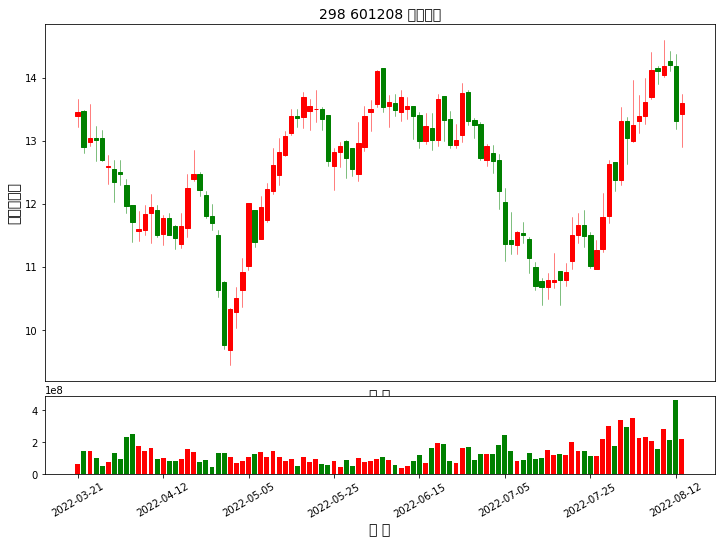

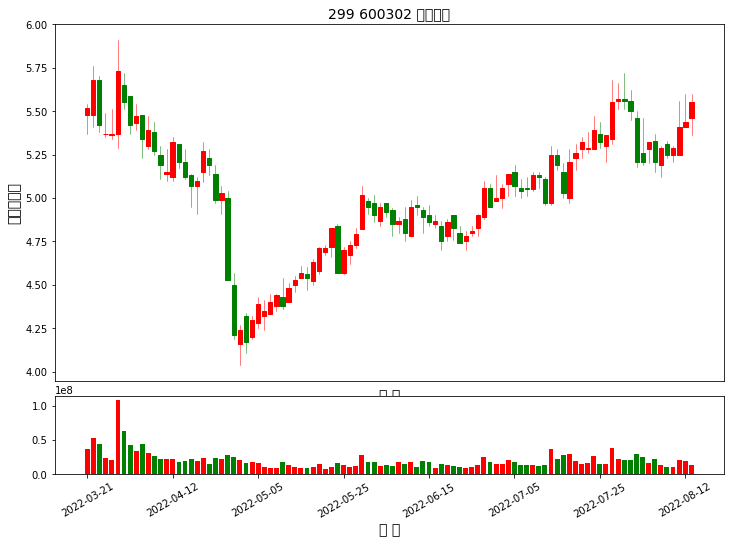

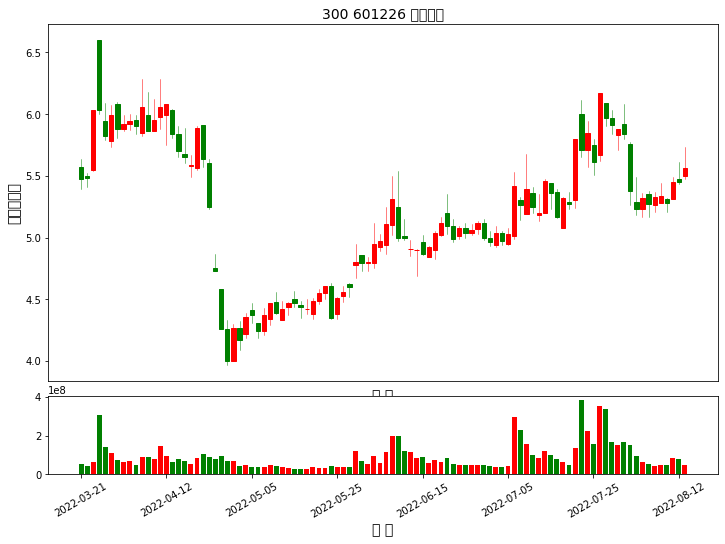

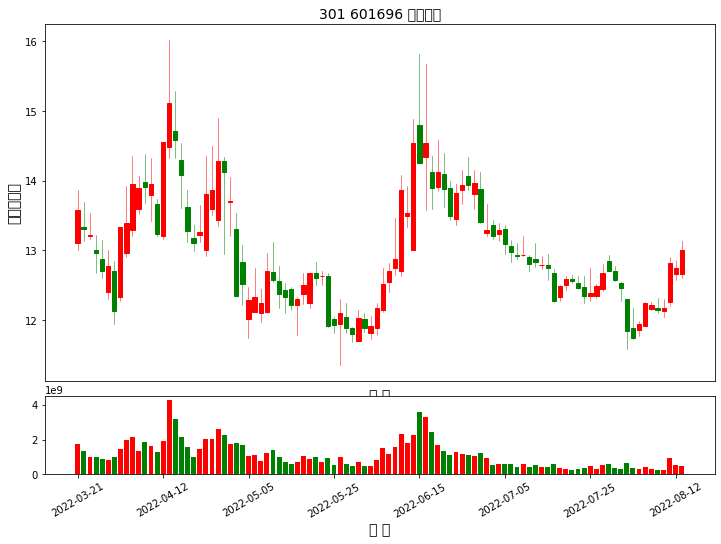

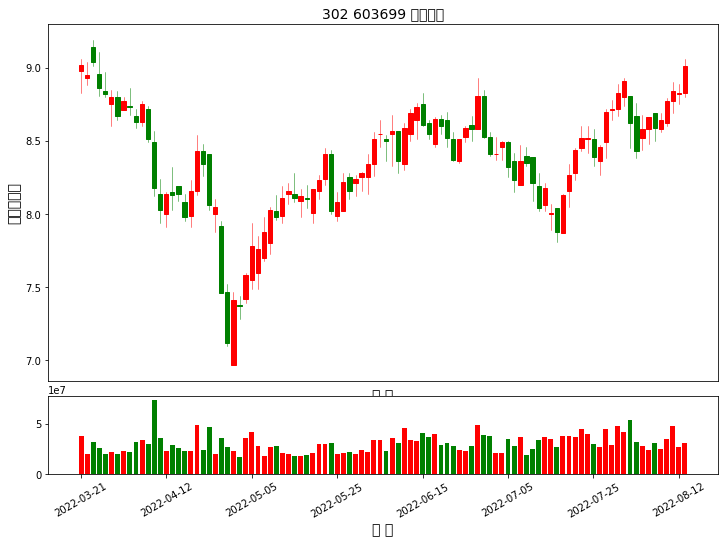

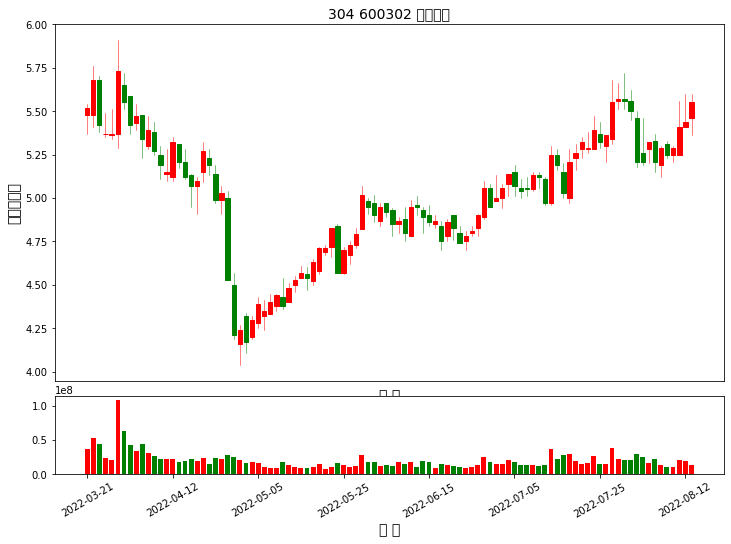

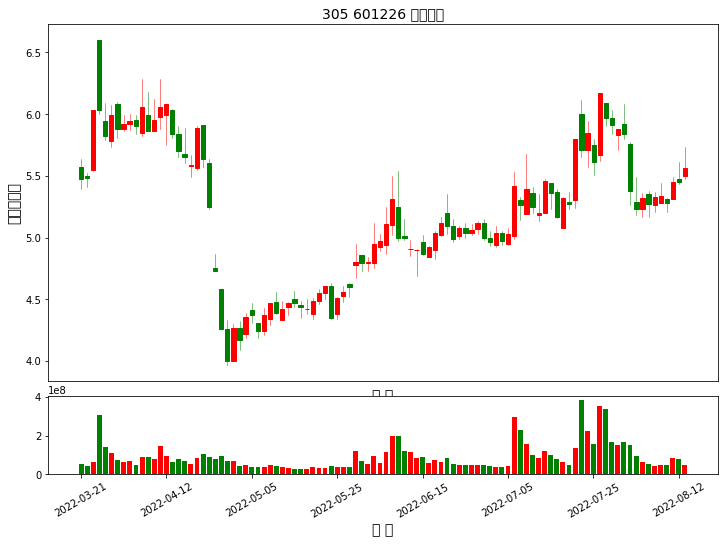

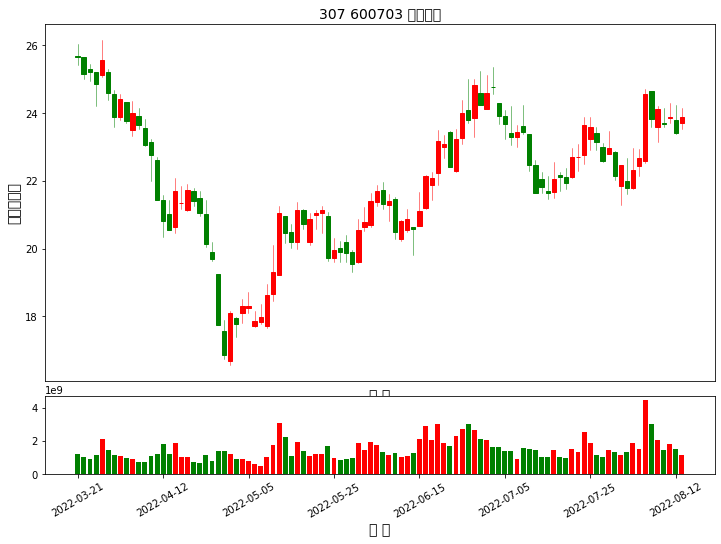

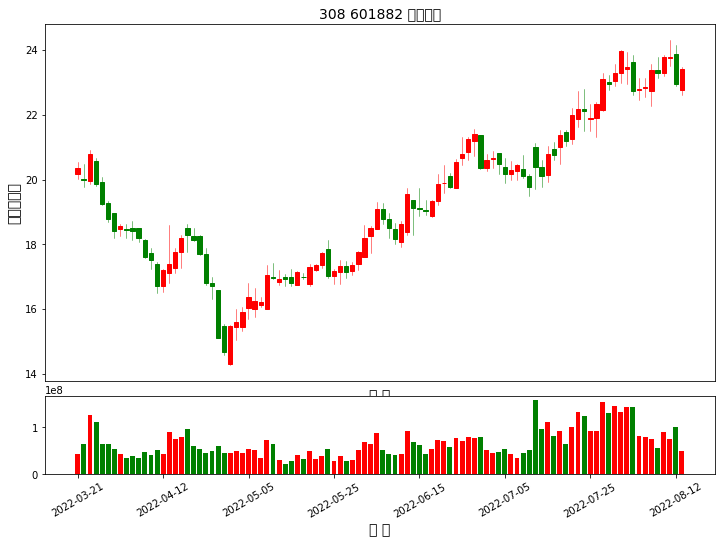

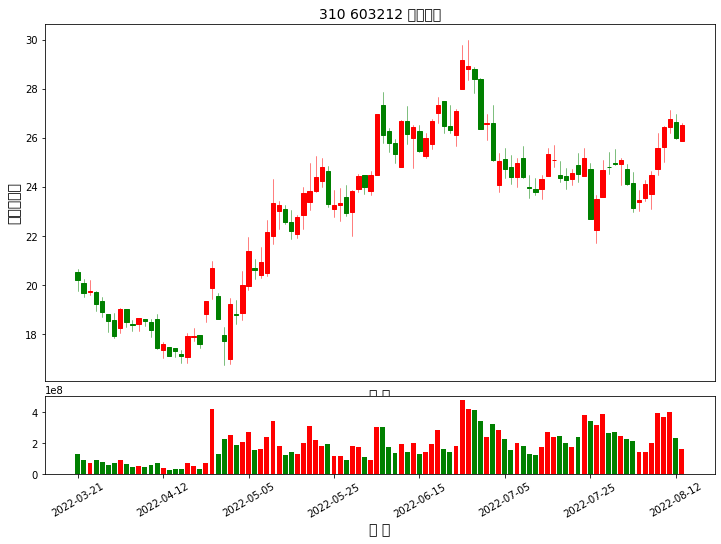

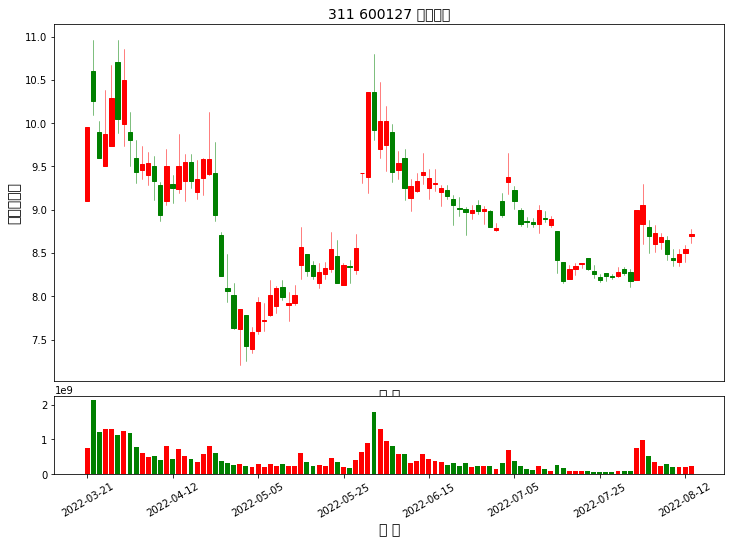

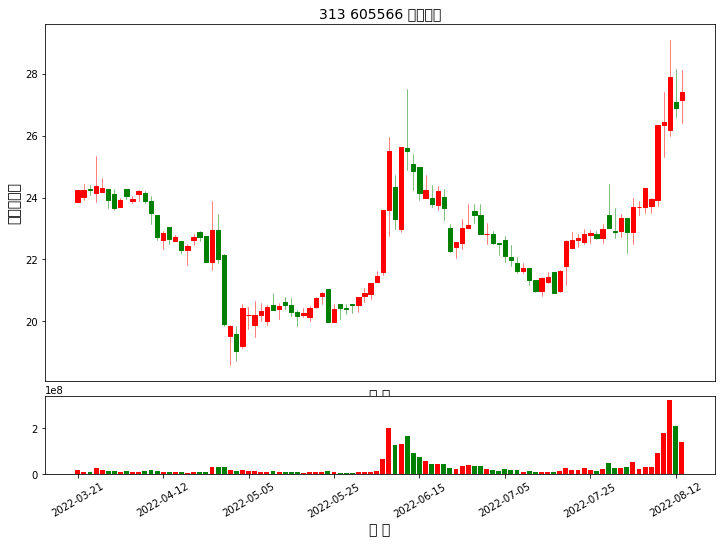

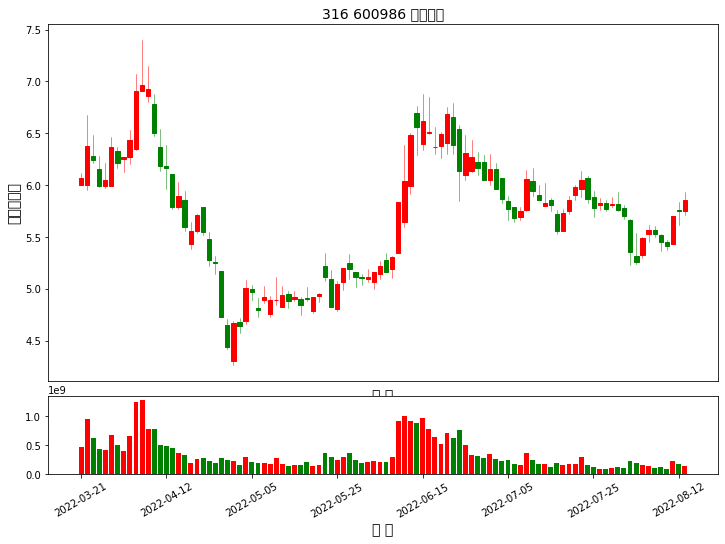

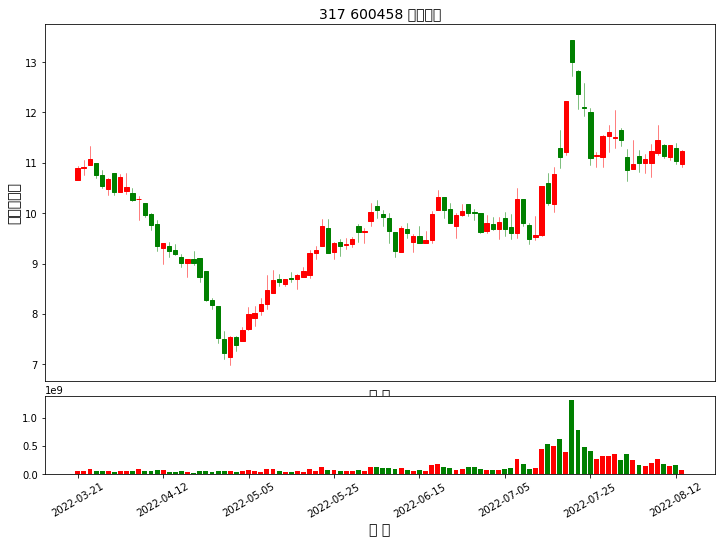

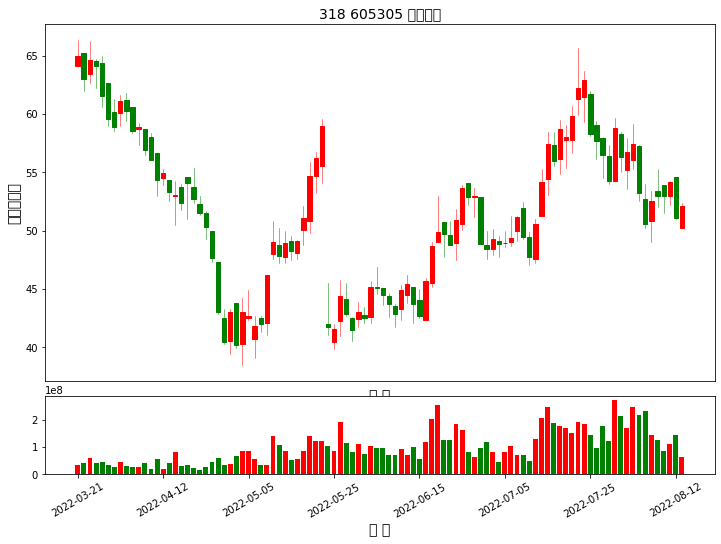

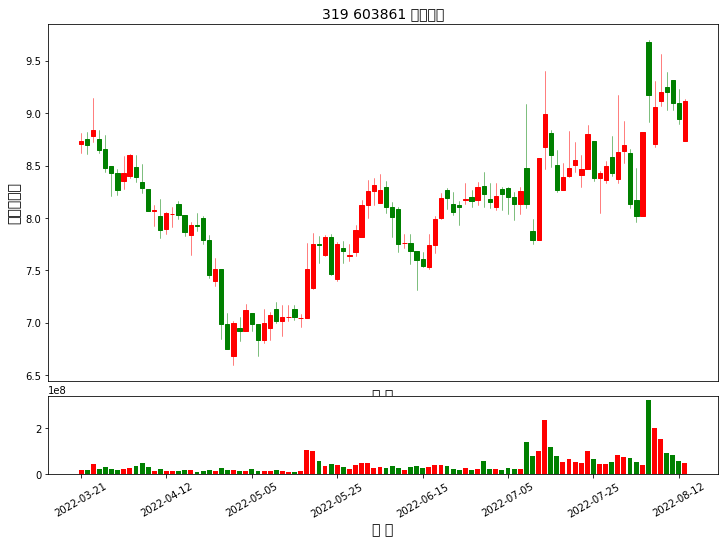

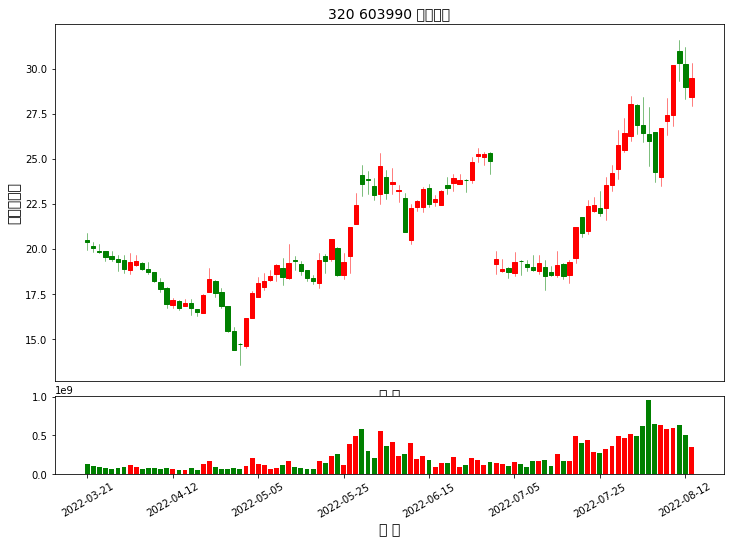

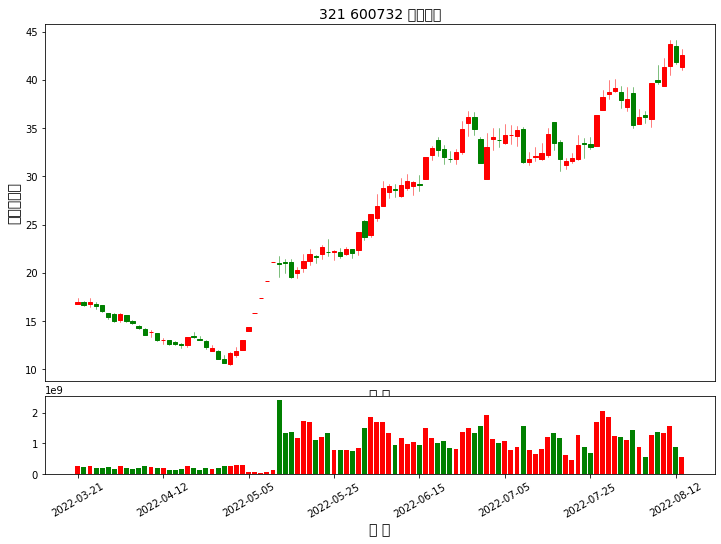

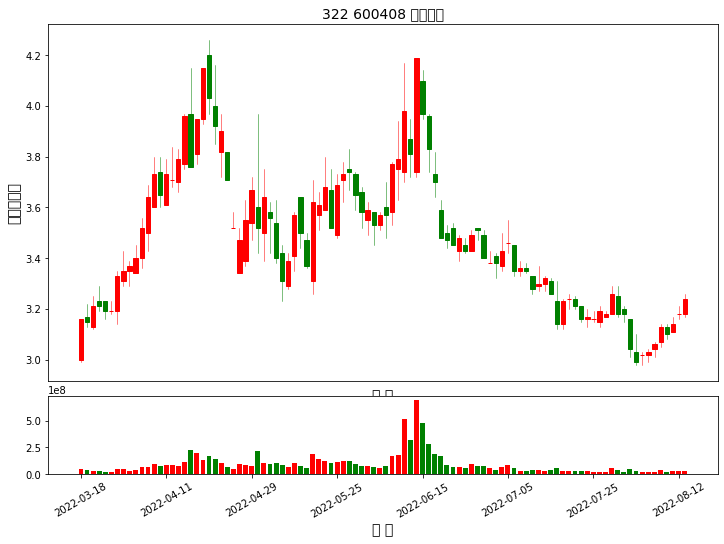

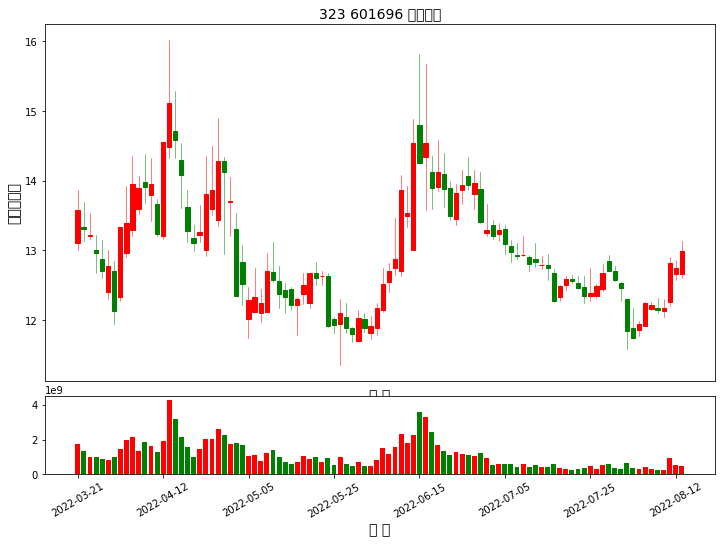

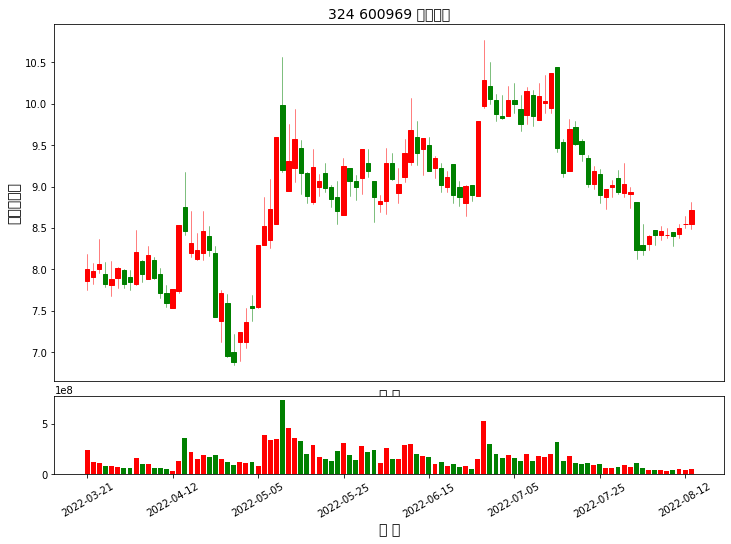

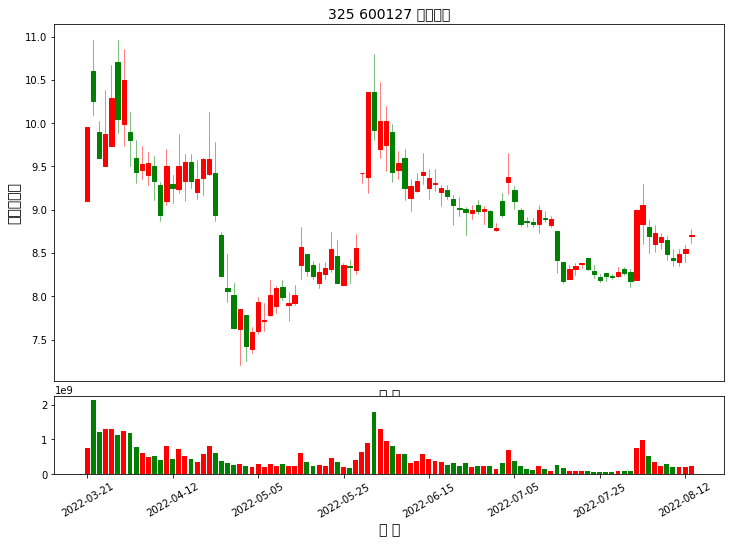

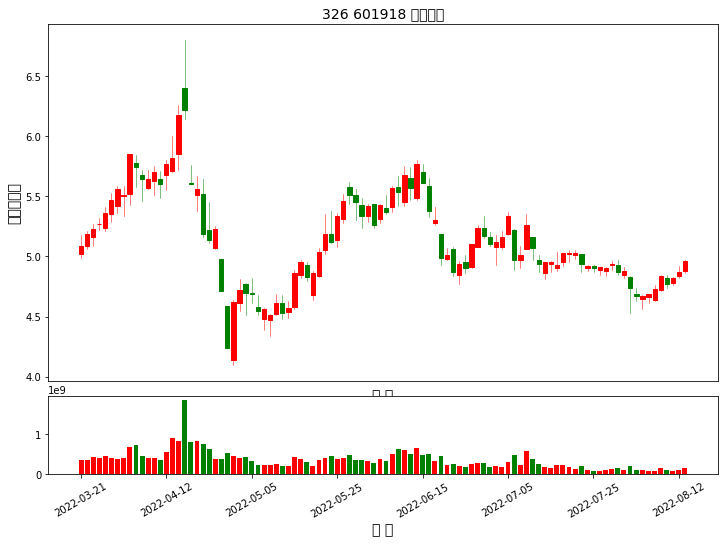

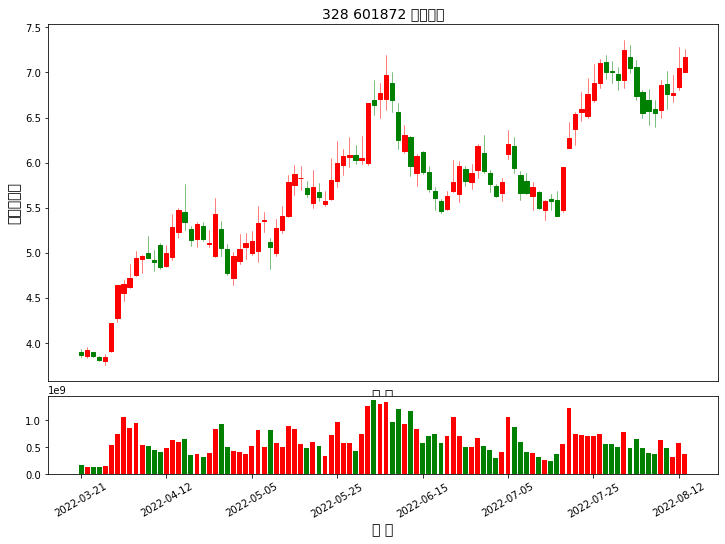

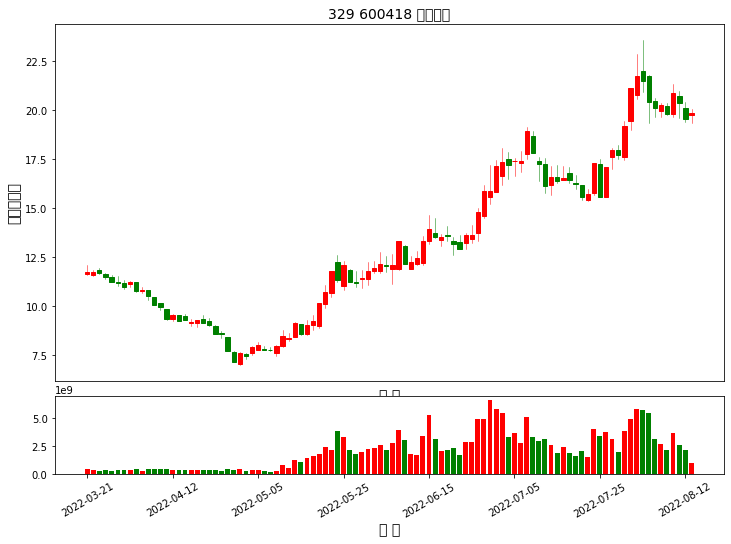

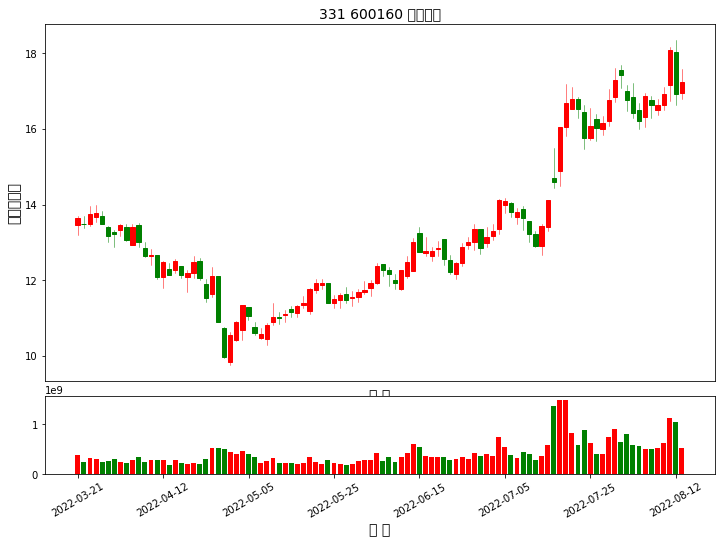

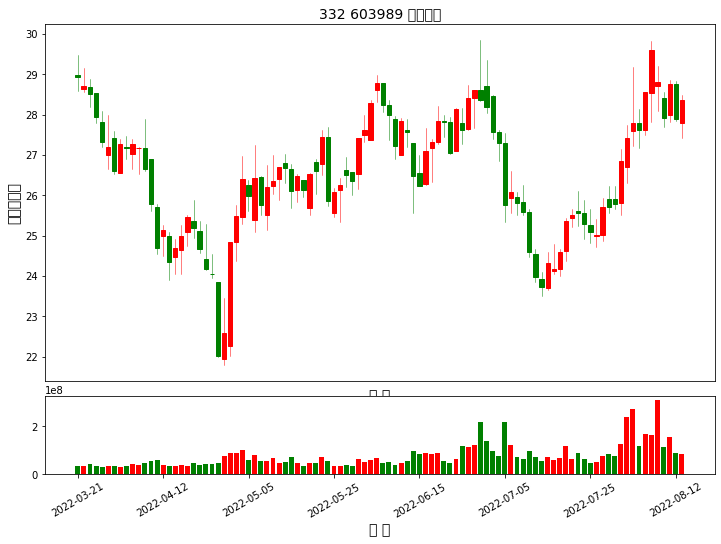

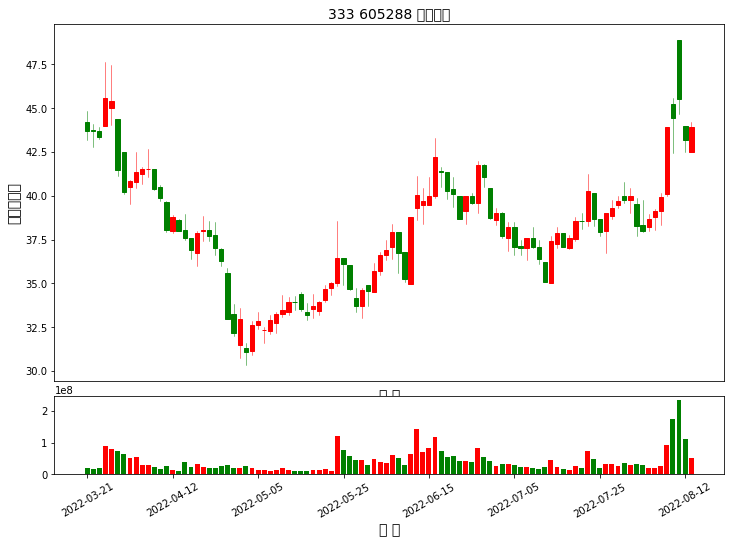

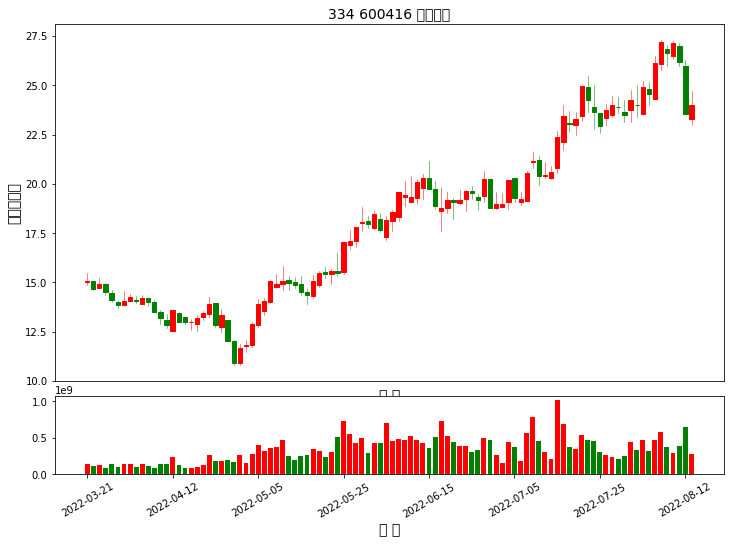

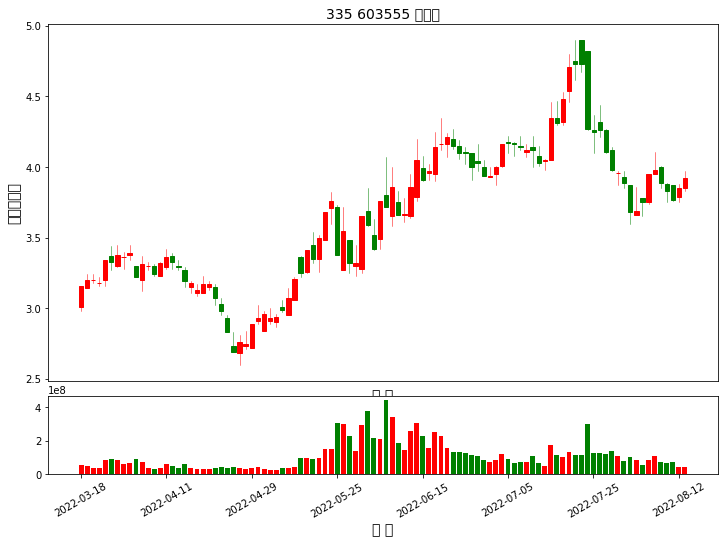

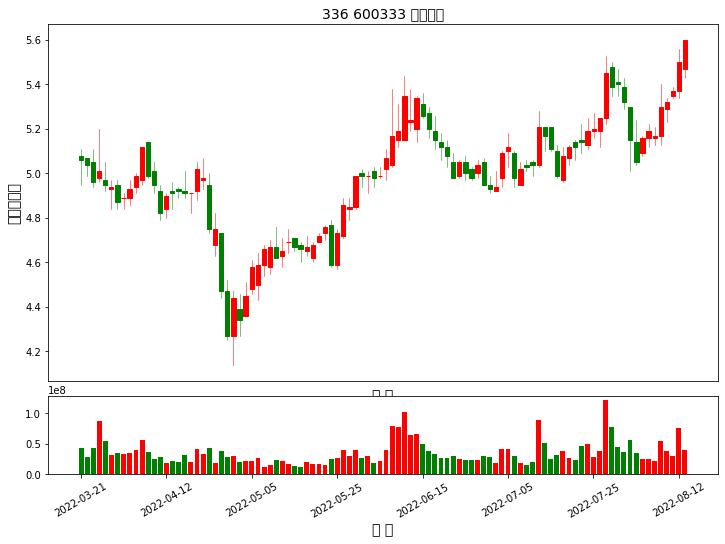

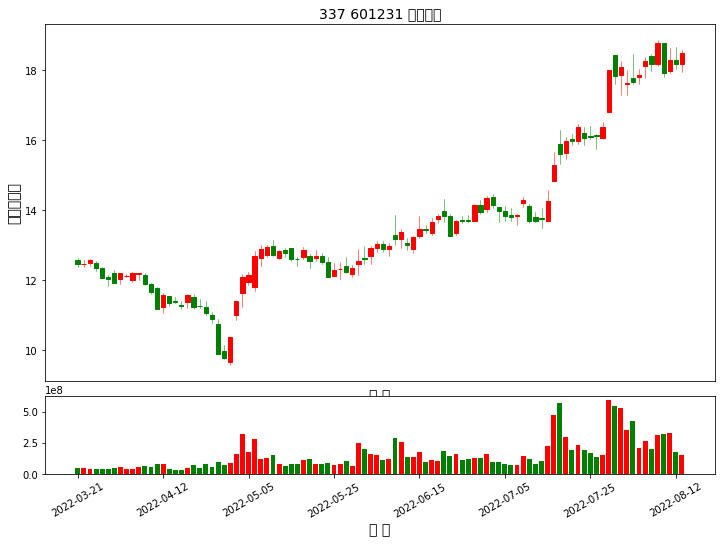

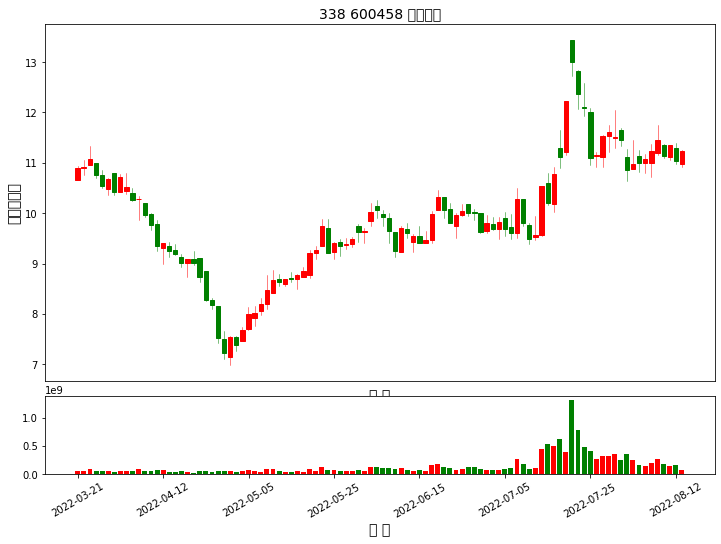

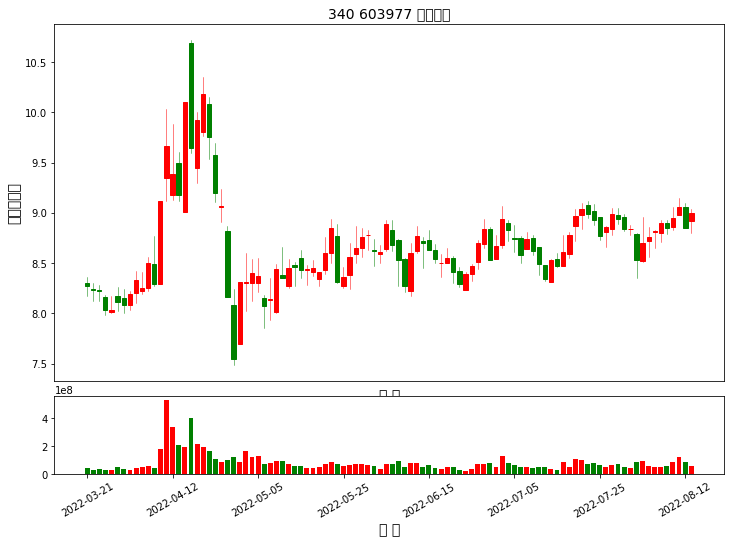

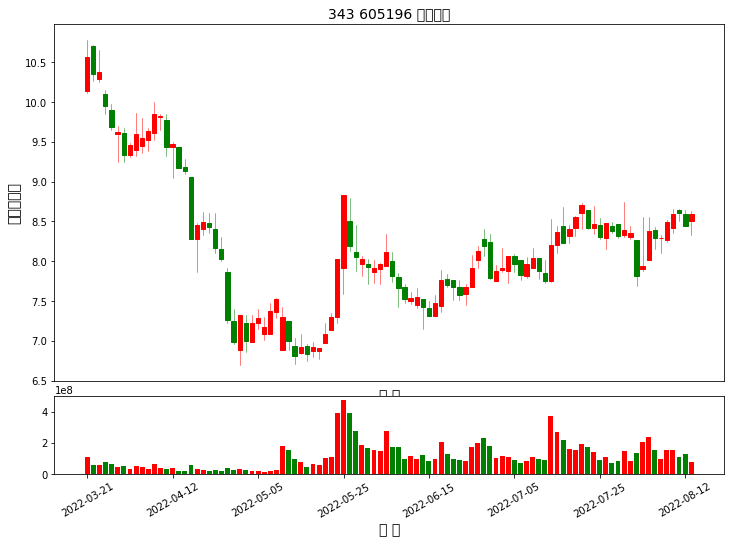

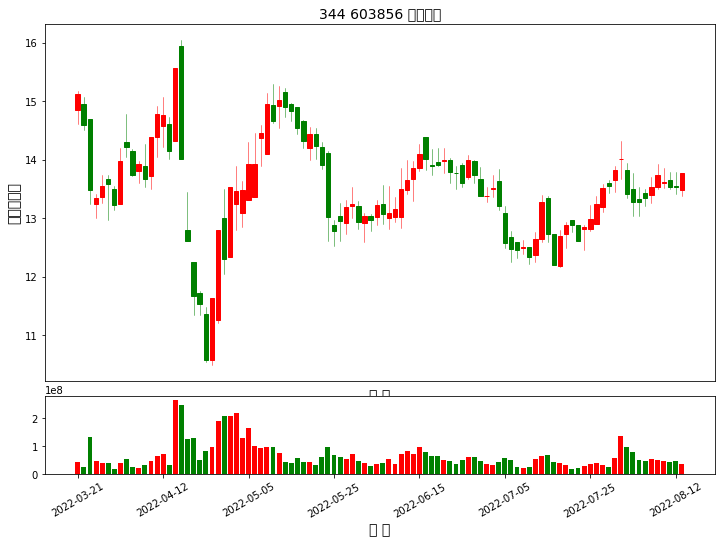

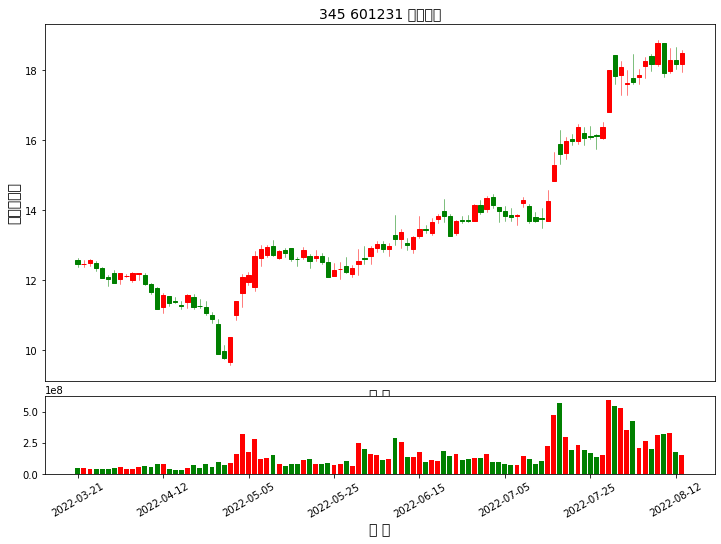

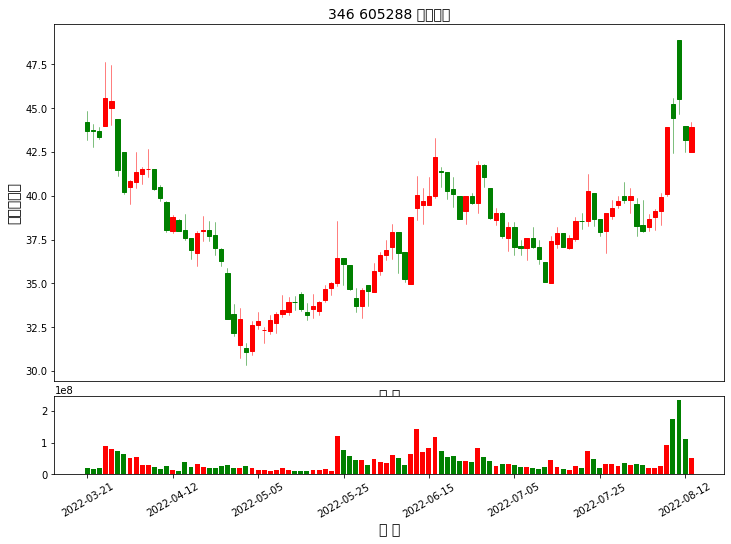

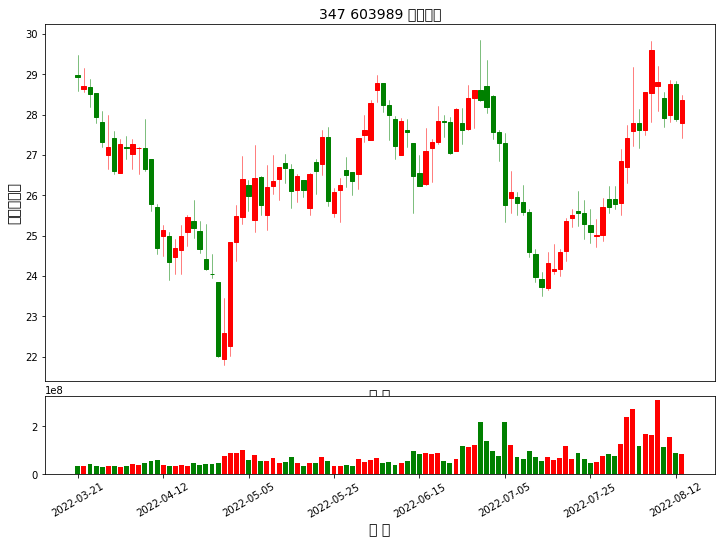

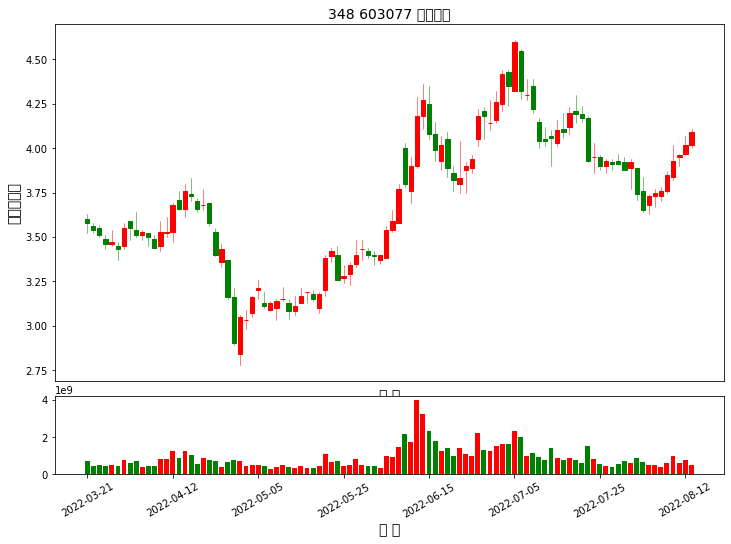

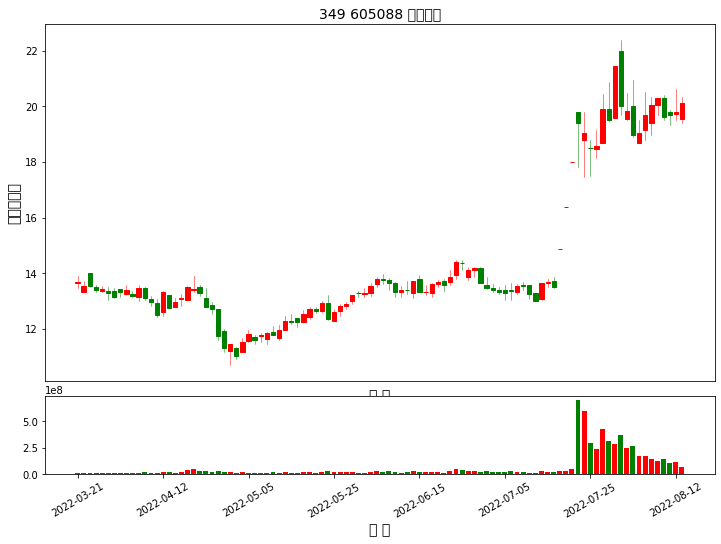

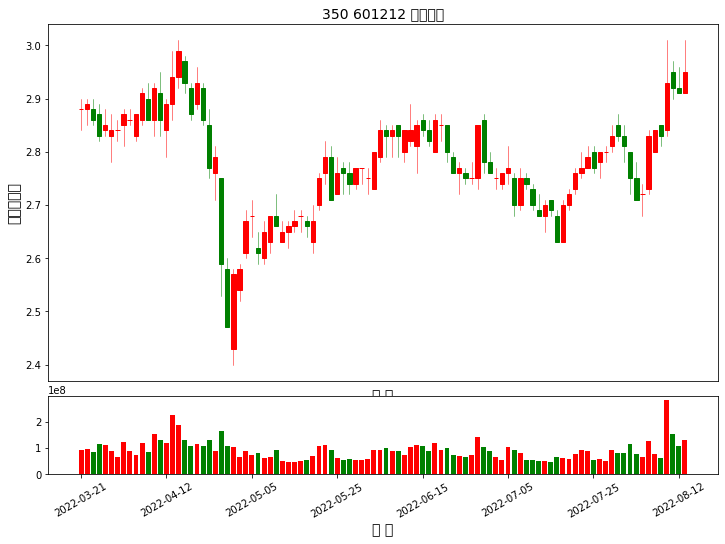

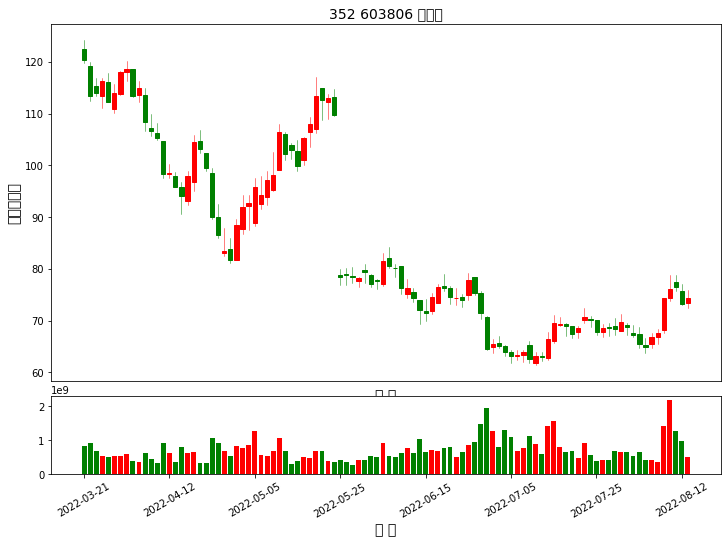

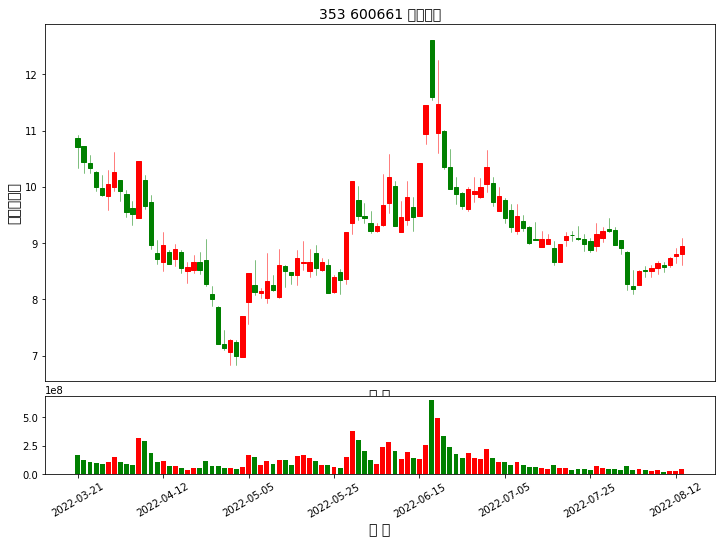

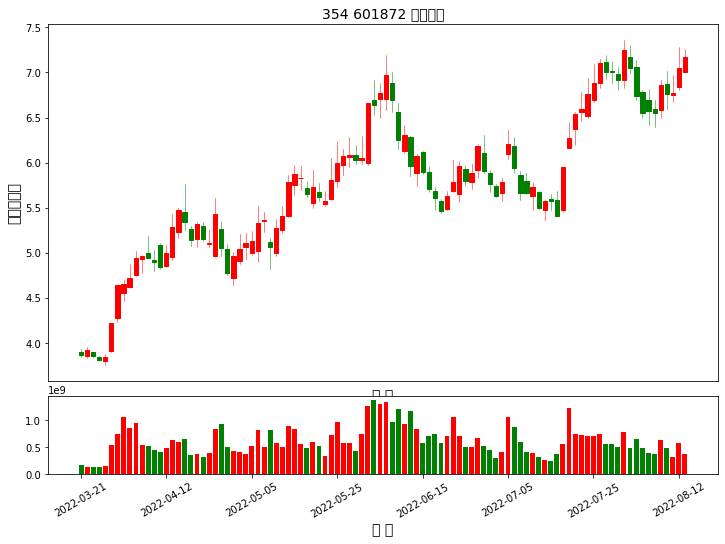

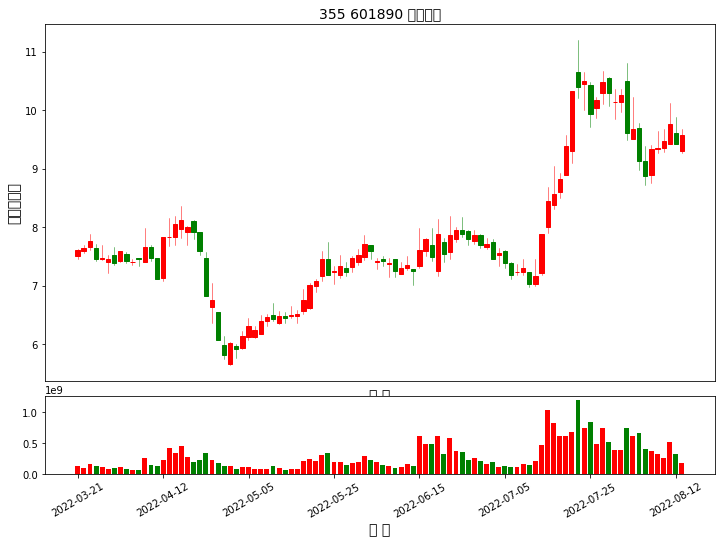

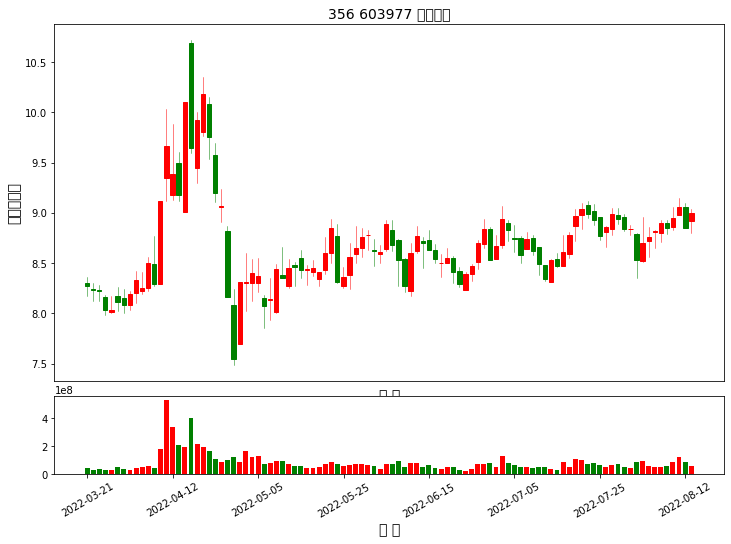

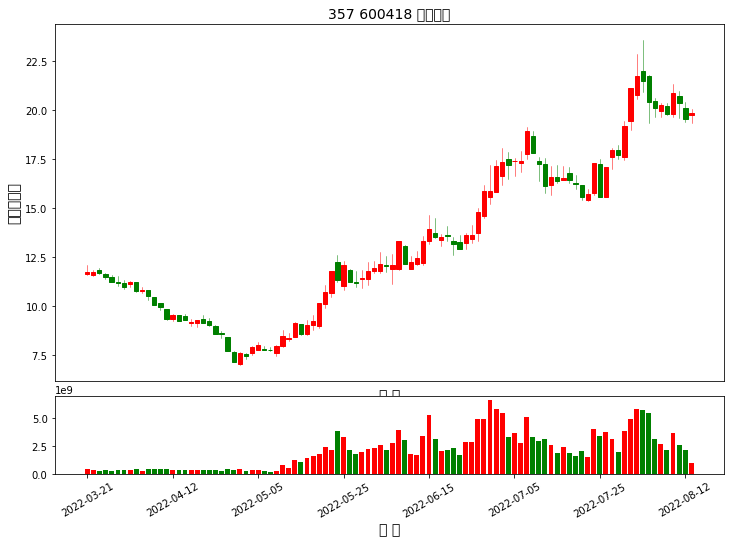

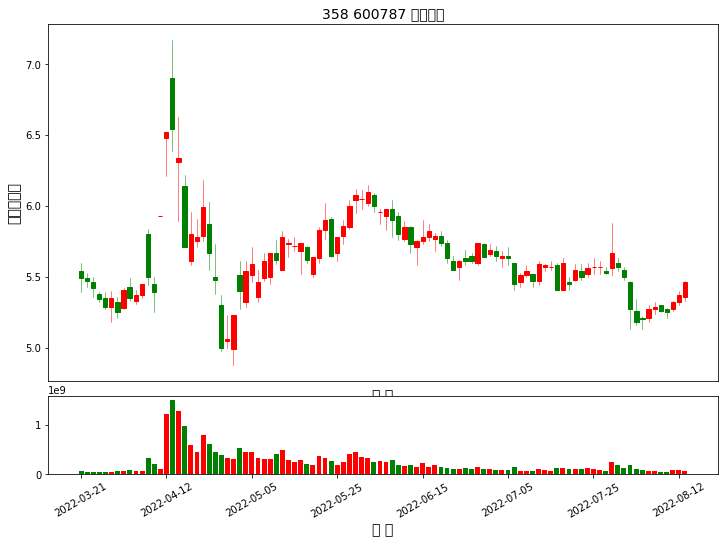

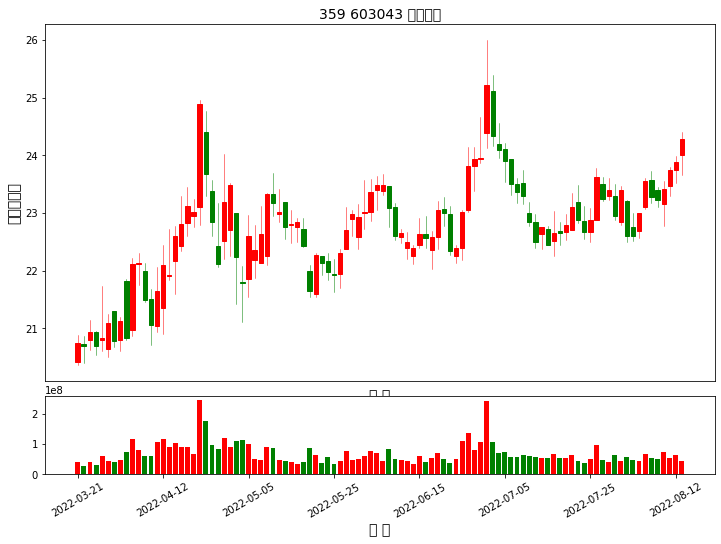

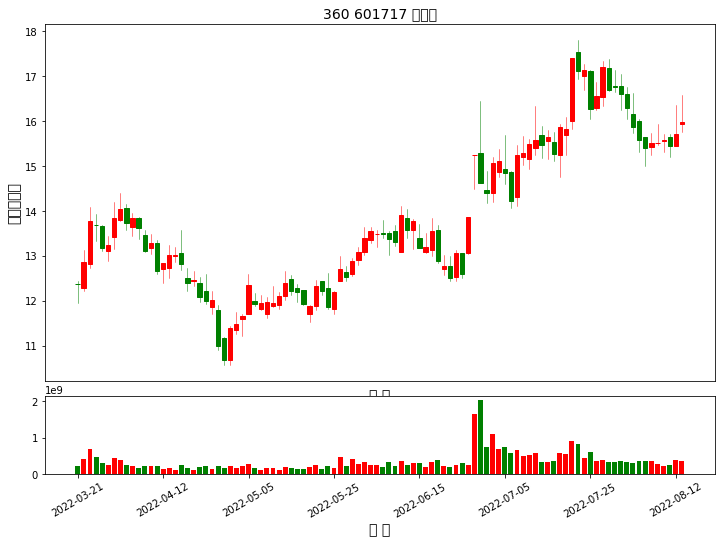

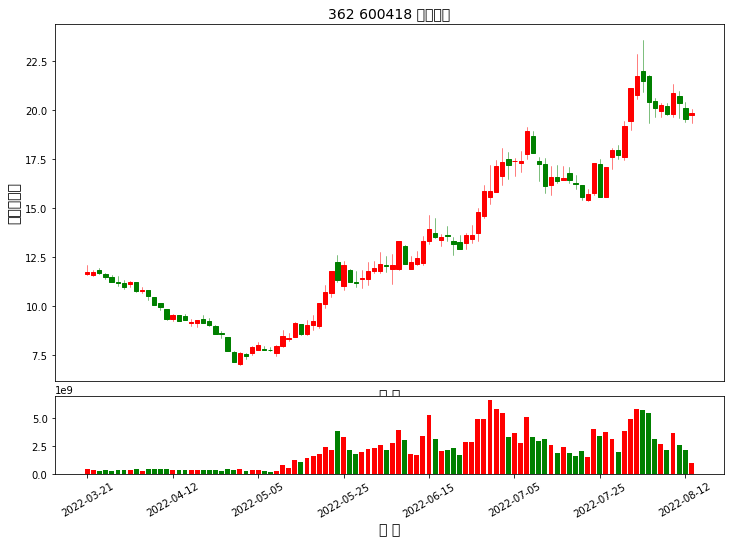

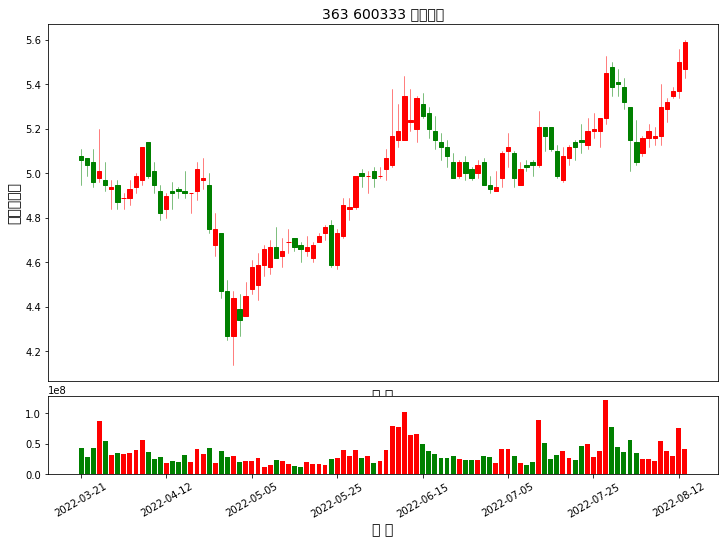

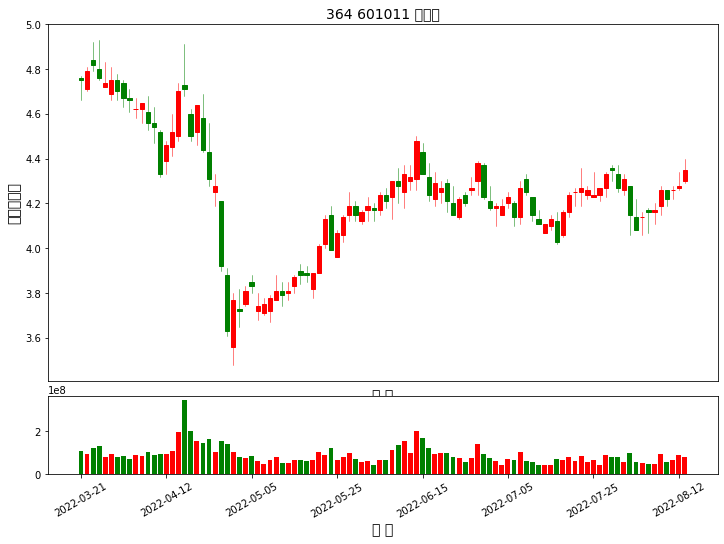

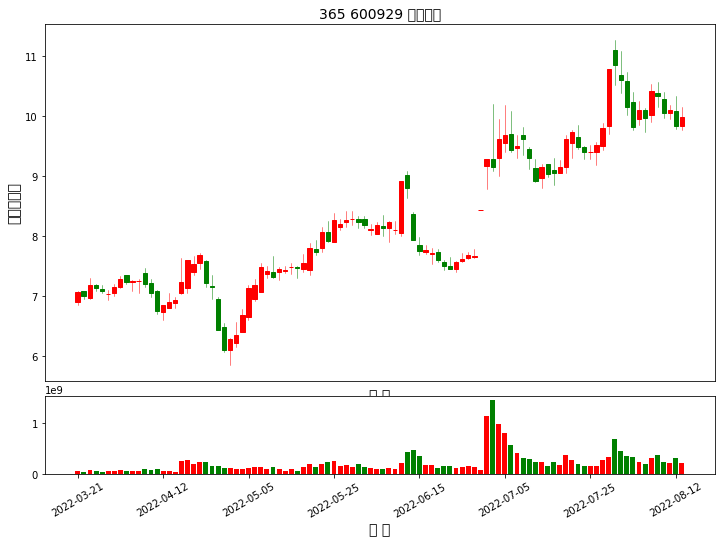

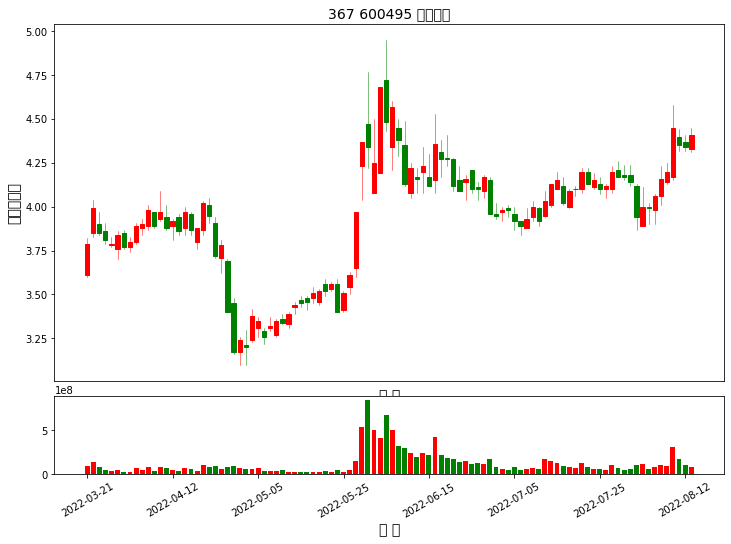

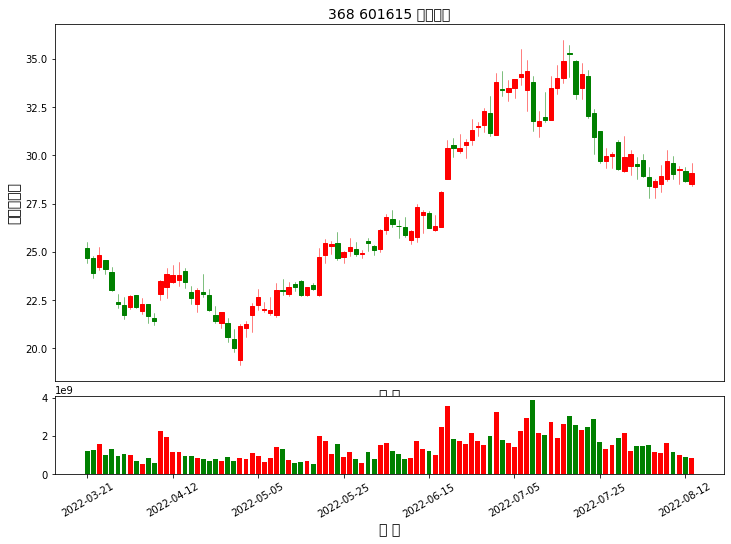

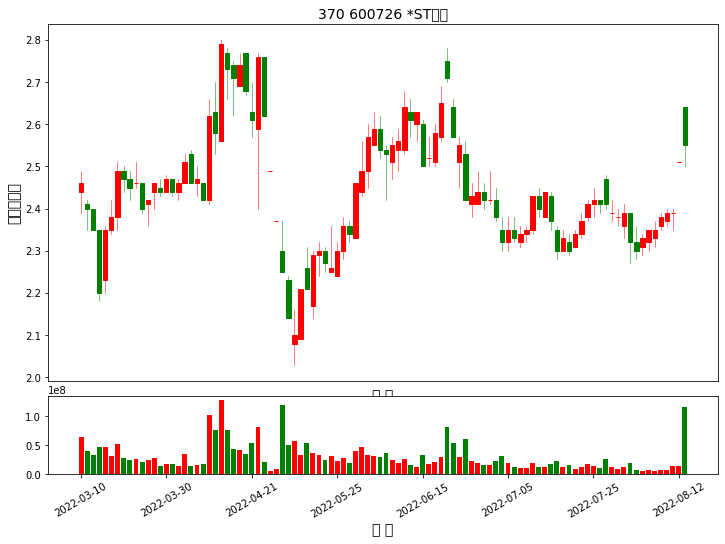

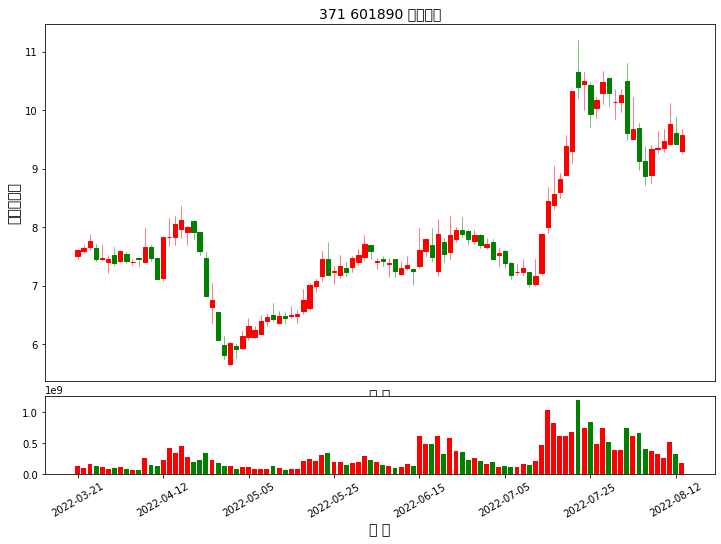

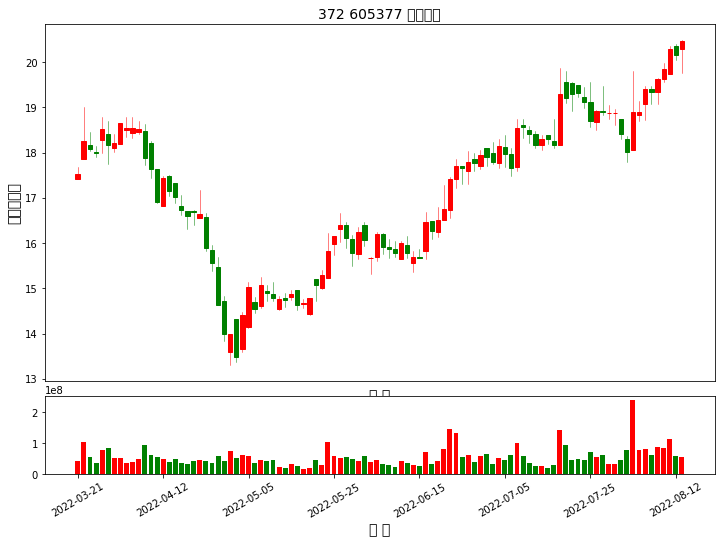

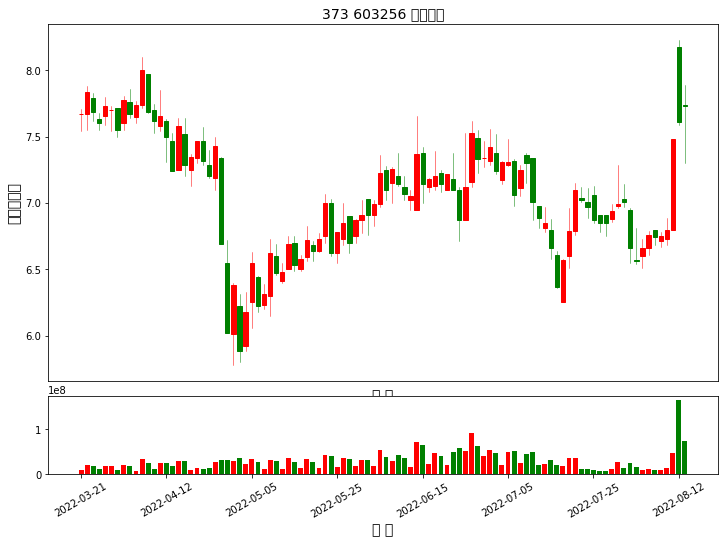

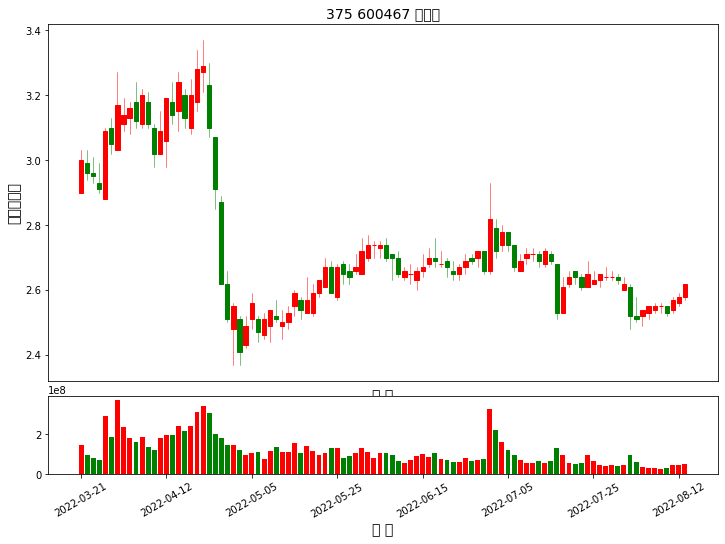

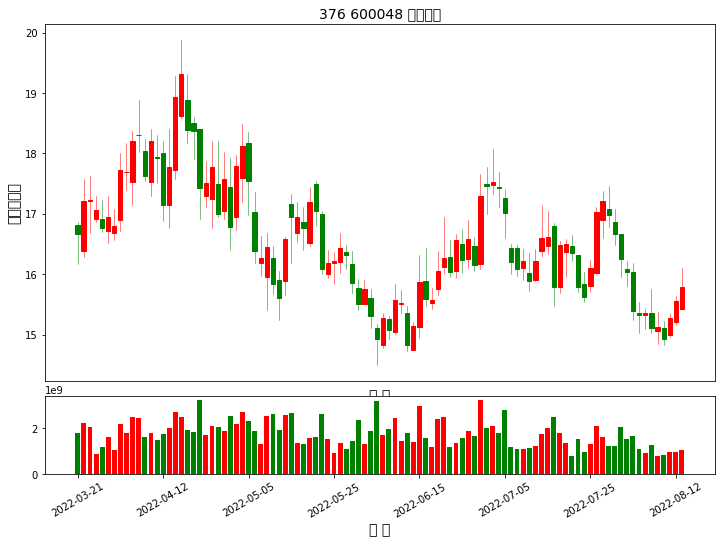

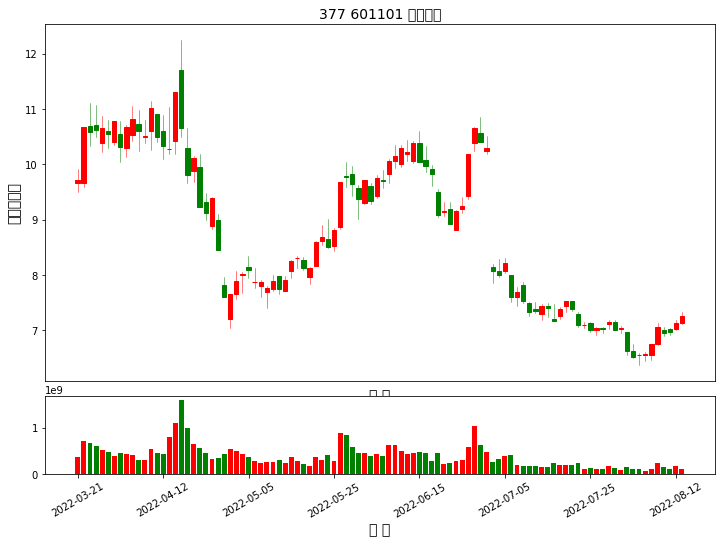

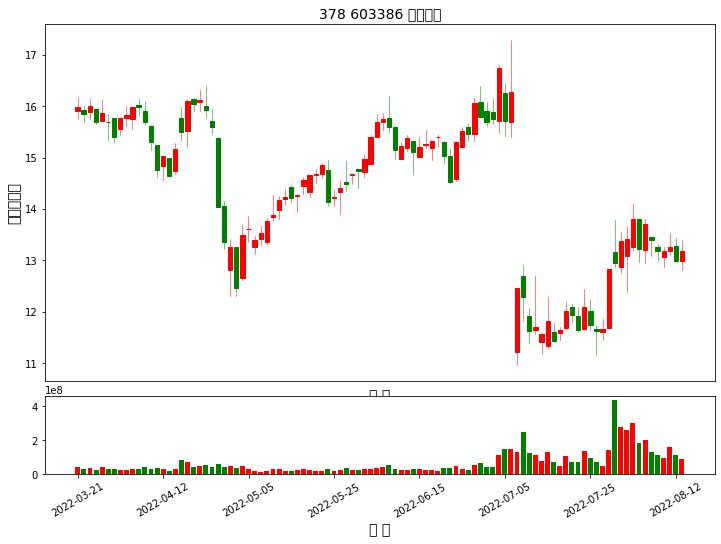

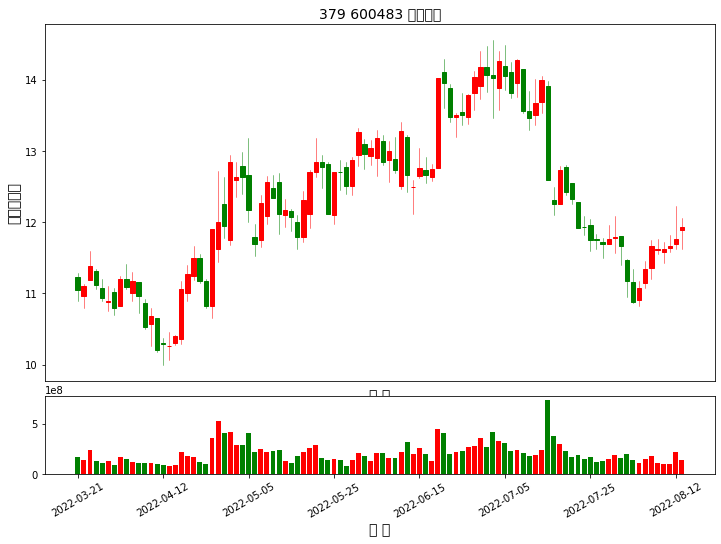

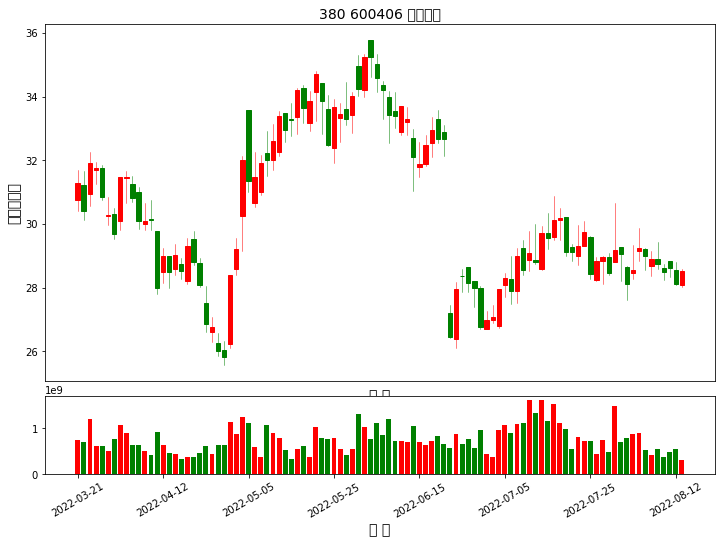

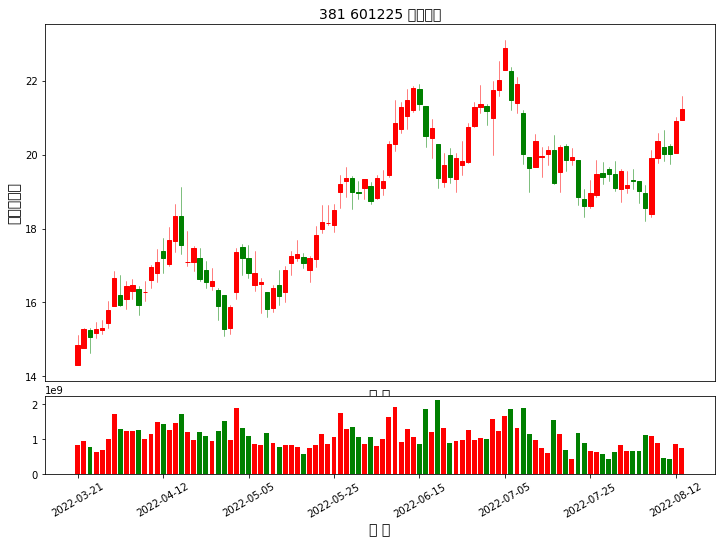

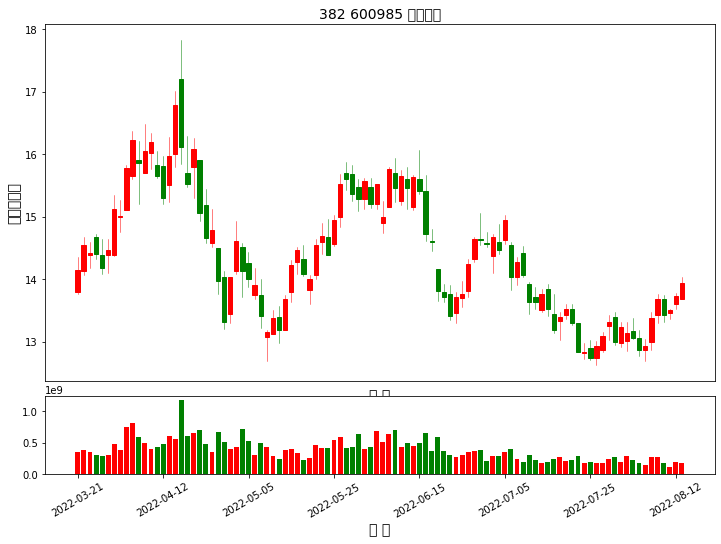

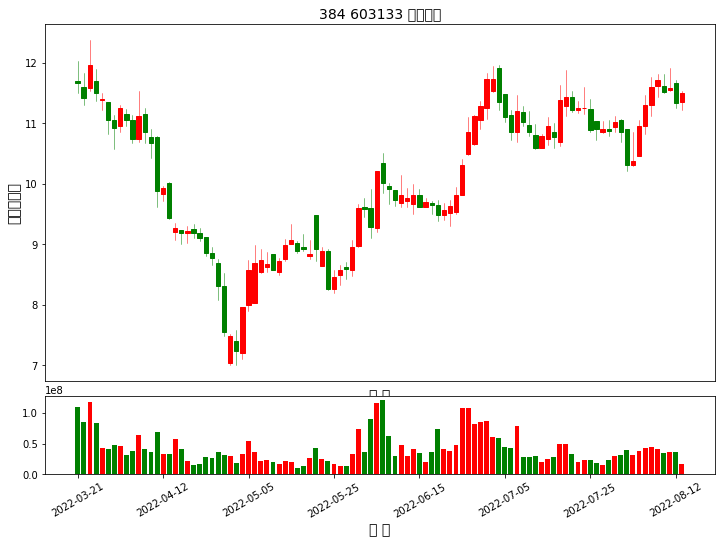

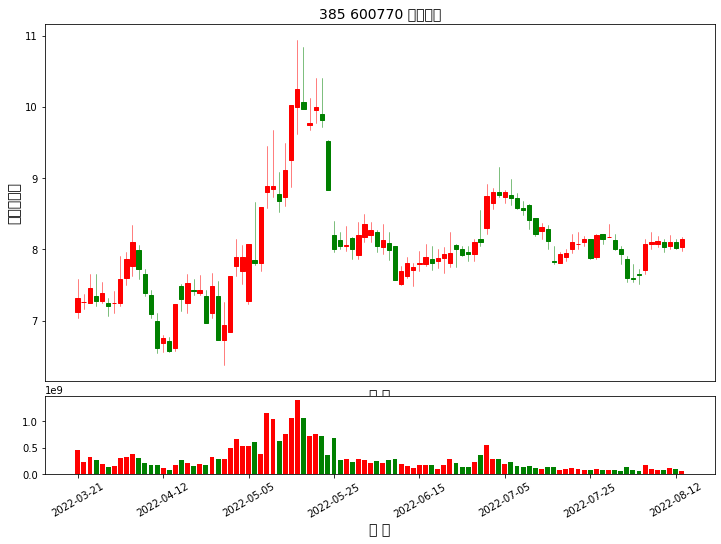

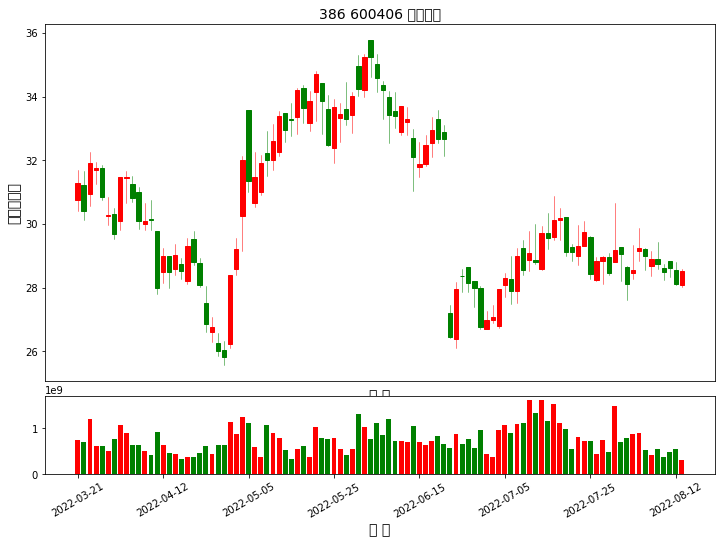

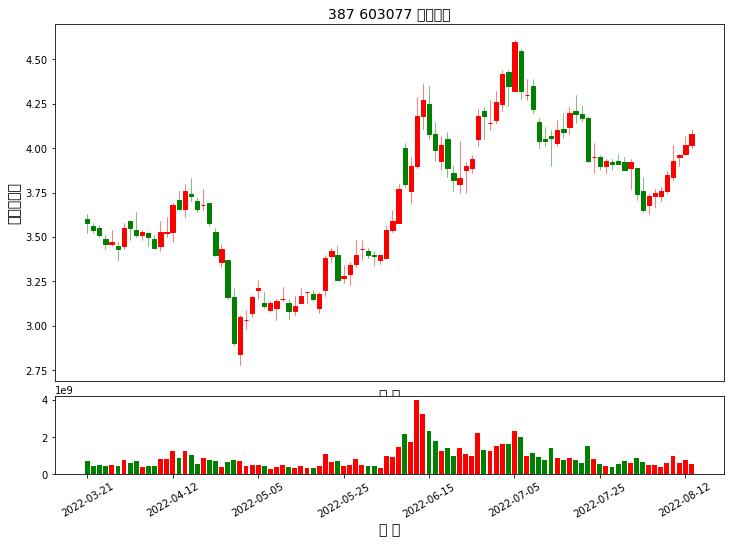

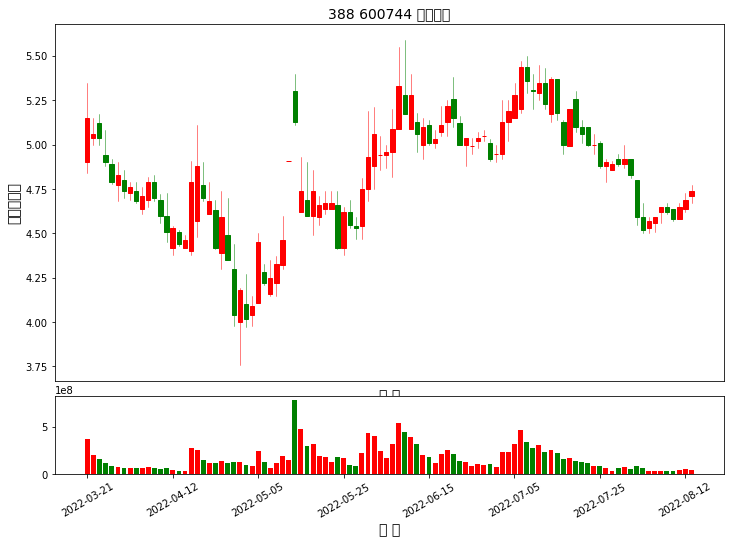

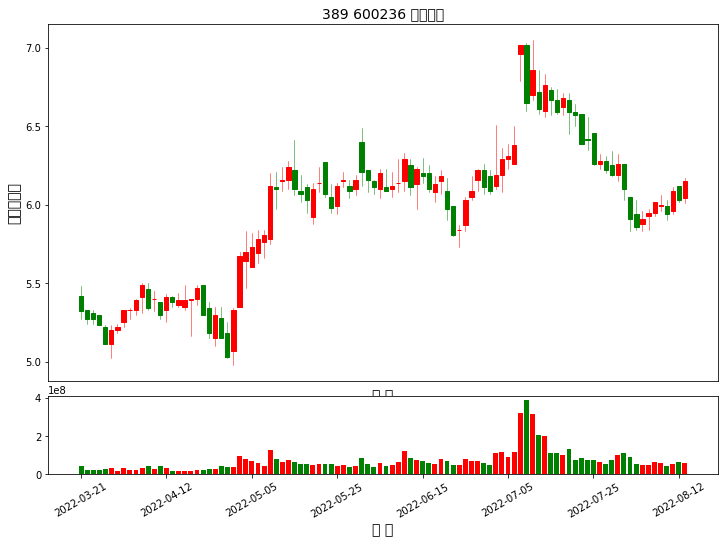

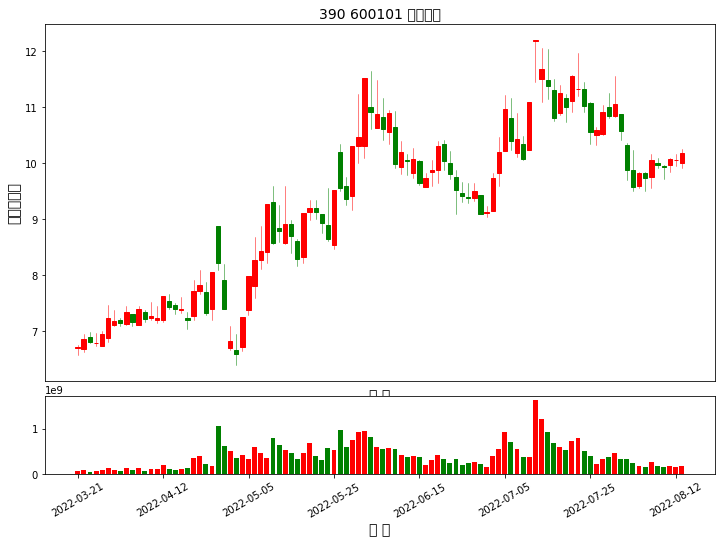

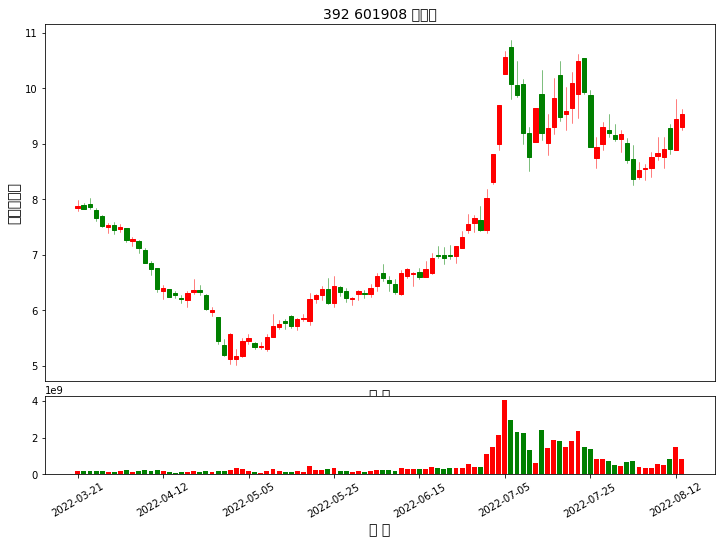

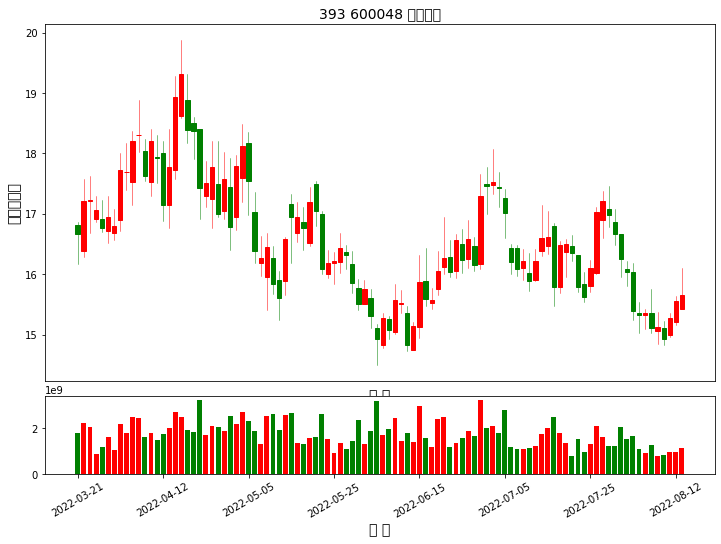

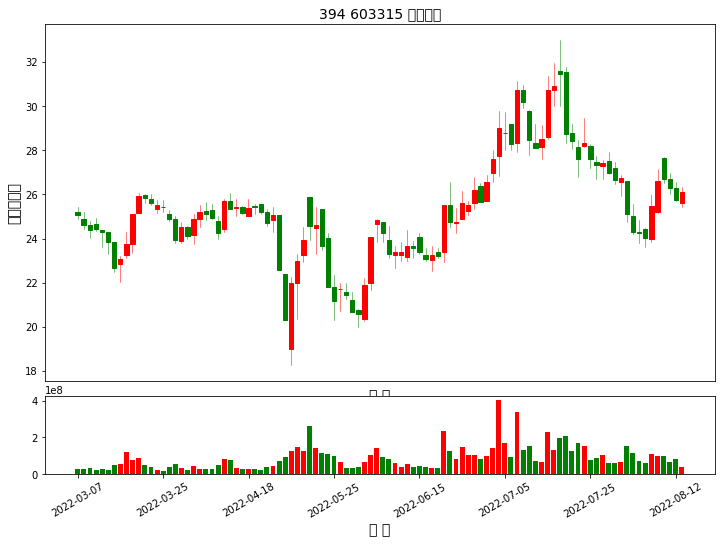

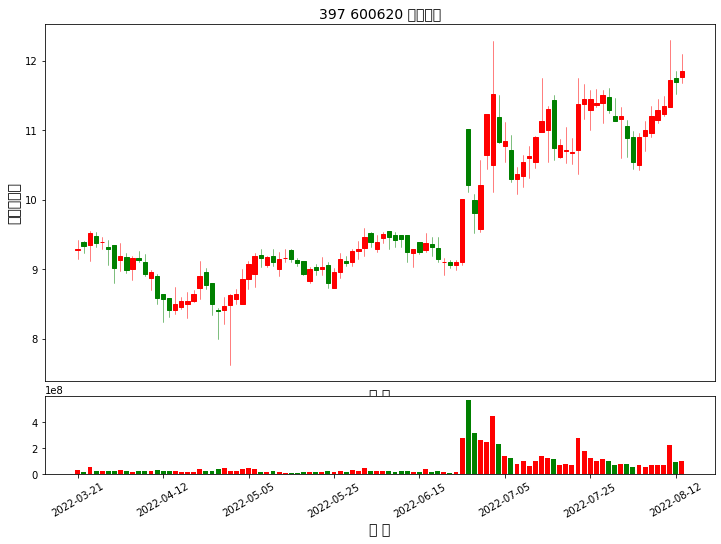

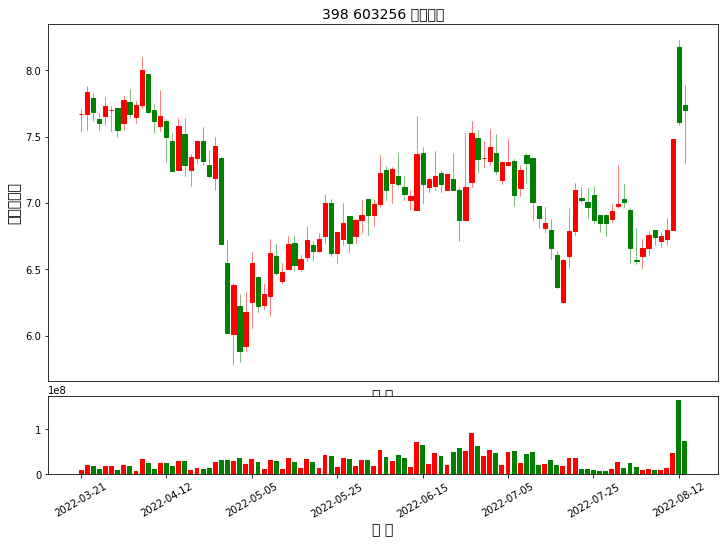

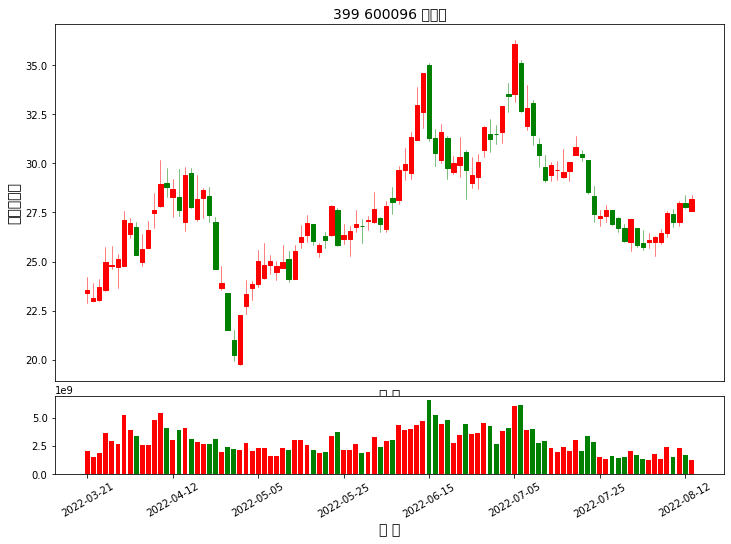

In [26]:
for i in range(11,21):
    start_idx = (i-1)*20
    status_code1, total, diff = request_all_code(i)
    if status_code1 != 200:
        print('request error', i)
    else:
        for infos in diff:
            start_idx += 1
            stock_code = infos['f12']
            name = infos['f14']
            status_code2, code, name, klines = get_klines(stock_code)
            if code.startswith('688'):
                continue
            if len(klines) <= 10:
                continue
            if status_code2 == 200:
                try:
                    print_klines(code, name, klines, start_idx)
                except:
                    print(str(start_idx)+' '+str(code)+' '+name, len(klines))
            else:
                print('request error', stock_code+' '+name)